### import libraries

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import seaborn as sns
from scipy.stats import ks_2samp, gaussian_kde
from scipy.stats import ttest_ind
from statsmodels.distributions.empirical_distribution import ECDF

# Add the parent directory of current directory to the Python path
sys.path.insert(0, os.path.abspath('..'))

from src.utils.process_session import *
from src.utils.optostim import *

### metadata and extract some data for writing codes

In [2]:
# metadata
Experiment = "GRM2_GtACR_optoinhibition"
Animals = ["SP159", "SP160"] ## "SP150"
Group = ["rILT-GtACR", "rILT-GtACR"]
Path_To_Raw_Data = "/mnt/ceph/data/bpod_raw_data"
Camera_Folder = "/mnt/ceph/projects/sequences/SP_FlyCap"
Output_Folder = os.path.join("/mnt/ceph/projects/sequences/analysed_data/behaviour_output", Experiment)


In [3]:
current_animal = Animals[1]
# print(current_animal)

all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
print(all_sessions_file_name)


/mnt/ceph/projects/sequences/analysed_data/behaviour_output/GRM2_GtACR_optoinhibition/SP160/SP160_transition_data_all_sessions.csv


In [4]:
allsessions_DF = pd.read_csv(all_sessions_file_name)
allsessions_DF.head()

Unnamed: 0  trial_id  transition_type  start_poke_port  end_poke_port  \
0           0         1               76                7              6   
1           1         1               66                6              6   
2           2         1               63                6              3   
3           3         1               33                3              3   
4           4         1               37                3              7   

   start_poke_in_timestamp  start_poke_out_timestamp  end_poke_in_timestamp  \
0                   5.8699                    5.8795                29.1035   
1                  29.1035                   29.1054                29.1058   
2                  29.1058                   29.1095                35.4481   
3                  35.4481                   35.5911                35.7508   
4                  35.7508                   37.3977                57.1123   

   end_poke_out_timestamp  out_in_latency  ...  camera_port_in_times  \
0                 29.1054         23.2240  ...                   NaN   
1                 29.1095          0.0004  ...                   NaN   
2                 35.5911          6.3386  ...                   NaN   
3                 37.3977          0.1597  ...                   NaN   
4                 57.6325         19.7146  ...                   NaN   

   camera_port_out_times  camera_trial_start_times  camera_trial_end_times  \
0                    NaN                       NaN                     NaN   
1                    NaN                       NaN                     NaN   
2                    NaN                       NaN                     NaN   
3                    NaN                       NaN                     NaN   
4                    NaN                       NaN                     NaN   

   cumulative_trial_id  session_id        date  day animal_id    group  
0                    1           0  2024-02-09  Fri     SP160  Control  
1                    1           0  2024-02-09  Fri     SP160  Control  
2                    1           0  2024-02-09  Fri     SP160  Control  
3                    1           0  2024-02-09  Fri     SP160  Control  
4                    1           0  2024-02-09  Fri     SP160  Control  

[5 rows x 29 columns]

In [5]:
# now loop through all Animals and concat the dataframes to create allsessions_DF

for i, current_animal in enumerate(Animals):
    print(current_animal)
    all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
    print(all_sessions_file_name)
    current_DF = pd.read_csv(all_sessions_file_name)
    if i == 0:
        allsessions_DF = current_DF
    else:
        allsessions_DF = pd.concat([allsessions_DF, current_DF], axis=0)

allsessions_DF.head()

SP159
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/GRM2_GtACR_optoinhibition/SP159/SP159_transition_data_all_sessions.csv
SP160
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/GRM2_GtACR_optoinhibition/SP160/SP160_transition_data_all_sessions.csv


Unnamed: 0  trial_id  transition_type  start_poke_port  end_poke_port  \
0           0         1               78                7              8   
1           1         1               81                8              1   
2           2         1               17                1              7   
3           3         1               77                7              7   
4           4         1               77                7              7   

   start_poke_in_timestamp  start_poke_out_timestamp  end_poke_in_timestamp  \
0                  78.6553                   79.8236               127.8733   
1                 127.8733                  127.8852               134.3304   
2                 134.3304                  135.3762               143.1877   
3                 143.1877                  143.2589               144.1375   
4                 144.1375                  144.1815               144.2479   

   end_poke_out_timestamp  out_in_latency  ...  camera_port_in_times  \
0                127.8852         48.0497  ...                   NaN   
1                135.3762          6.4452  ...                   NaN   
2                143.2589          7.8115  ...                   NaN   
3                144.1815          0.8786  ...                   NaN   
4                146.1018          0.0664  ...                   NaN   

   camera_port_out_times  camera_trial_start_times  camera_trial_end_times  \
0                    NaN                       NaN                     NaN   
1                    NaN                       NaN                     NaN   
2                    NaN                       NaN                     NaN   
3                    NaN                       NaN                     NaN   
4                    NaN                       NaN                     NaN   

   cumulative_trial_id  session_id        date  day animal_id    group  
0                    1           0  2024-02-09  Fri     SP159  Control  
1                    1           0  2024-02-09  Fri     SP159  Control  
2                    1           0  2024-02-09  Fri     SP159  Control  
3                    1           0  2024-02-09  Fri     SP159  Control  
4                    1           0  2024-02-09  Fri     SP159  Control  

[5 rows x 29 columns]

In [6]:
# get session settings loop through all Animals and concat the dataframes to create session_settings_DF
# append name of current animal to the session_settings_DF

for i, current_animal in enumerate(Animals):
    print(current_animal)
    current_DF = get_session_details(Output_Folder, current_animal)
    current_DF['Animal'] = current_animal
    if i == 0:
        session_details_DF = current_DF
    else:
        session_details_DF = pd.concat([session_details_DF, current_DF], axis=0)

session_details_DF.head()

SP159
SP160


session_id                 session       date  file_number  day  \
0           0  00_20240209_122917_Fri 2024-02-09       122917  Fri   
1           1  01_20240210_130054_Sat 2024-02-10       130054  Sat   
2           2  02_20240211_111128_Sun 2024-02-11       111128  Sun   
3           3  03_20240212_130049_Mon 2024-02-12       130049  Mon   
4           4  04_20240213_123737_Tue 2024-02-13       123737  Tue   

   opto_session stim_port opto_chance pulse_duration pulse_interval  \
0         False      None        None           None           None   
1         False      None        None           None           None   
2         False      None        None           None           None   
3         False      None        None           None           None   
4         False      None        None           None           None   

  train_duration train_delay  variable_train_delay mu_variable_delay  \
0           None        None                 False              None   
1           None        None                 False              None   
2           None        None                 False              None   
3           None        None                 False              None   
4           None        None                 False              None   

  sigma_variable_delay lower_bound_variableDelay upper_bound_variableDelay  \
0                 None                      None                      None   
1                 None                      None                      None   
2                 None                      None                      None   
3                 None                      None                      None   
4                 None                      None                      None   

  experiment_type Animal  
0      1_Training  SP159  
1      1_Training  SP159  
2      1_Training  SP159  
3      1_Training  SP159  
4      1_Training  SP159

In [7]:
# get all unique animals in the session_settings_DF and loop through them to get the opto session ids
# create a dictionary with key as animal name and value as opto session ids
opto_sessions_dict = { 'SP159': [19], 'SP160': [19]
}

## Note: SP150 is not included in the opto_sessions_dict because of different strategy (it uses hand to trigger port 4)
## 'SP150': [36, 37, 38, 39, 40, 41, 42, 42, 43] 

# Print opto_sessions_dict before removing
print("Before removing:", opto_sessions_dict)

# # anything in opto_sessions_dict before session 53 is older protocol and needs to be removed
# # remove sessions with id less than 53 from the dictionary
# for animal, sessions in opto_sessions_dict.items():
#     opto_sessions_dict[animal] = [session for session in sessions if session >= 53]

# Print opto_sessions_dict after removing
print("After removing:", opto_sessions_dict)



Before removing: {'SP159': [19], 'SP160': [19]}
After removing: {'SP159': [19], 'SP160': [19]}


In [8]:
# for all sessions with opto_stim, get the opto_stim settings from settings.json file in each session folder
# the session folders are organised in os.path.join(Output_Folder, current_animal, f'{current_animal}, session)
# read the value of PulseDuration and append the value to a column named stim_duration to allsessions_DF

# filter sessions only with stim_duration = 1.5
stim_duration_value = 1.5

# Set to hold session IDs for which OptoStim is True
opto_true_sessions = set()

# Check if the 'stim_duration' column exists, if not, create it
if 'stim_duration' not in allsessions_DF.columns:
    allsessions_DF['stim_duration'] = np.nan

for current_animal in opto_sessions_dict.keys():
    opto_session_ids = opto_sessions_dict[current_animal]

    for current_session in opto_session_ids:
        session_folder = session_details_DF['session'].loc[(session_details_DF['session_id'] == current_session) & (session_details_DF['Animal'] == current_animal)].to_string(index=False).strip()
        settings_file_name = os.path.join(Output_Folder, current_animal, 'Preprocessed', session_folder, 'settings.json')
        print(settings_file_name) # for debugging

        with open(settings_file_name) as f:
            data = json.load(f)

        # Check if OptoStim is True AND PulseDuration matches stim_duration_value
        if data.get('OptoStim', False) and data.get('PulseDuration') == stim_duration_value:
            opto_true_sessions.add(current_session)
            mask = (allsessions_DF['session_id'] == current_session) & (allsessions_DF['animal_id'] == current_animal)
            allsessions_DF.loc[mask, 'stim_duration'] = stim_duration_value

# Filter allsessions_DF to keep only rows where session_id is in opto_true_sessions
allsessions_DF = allsessions_DF[allsessions_DF['session_id'].isin(opto_true_sessions)]

allsessions_DF.head()


/mnt/ceph/projects/sequences/analysed_data/behaviour_output/GRM2_GtACR_optoinhibition/SP159/Preprocessed/19_20240229_120201_Thu/settings.json
/mnt/ceph/projects/sequences/analysed_data/behaviour_output/GRM2_GtACR_optoinhibition/SP160/Preprocessed/19_20240229_120452_Thu/settings.json


Unnamed: 0  trial_id  transition_type  start_poke_port  end_poke_port  \
61391           0         1               21                2              1   
61392           1         1               13                1              3   
61393           2         1               37                3              7   
61394           3         1               73                7              3   
61395           4         1               37                3              7   

       start_poke_in_timestamp  start_poke_out_timestamp  \
61391                  17.7079                   18.4110   
61392                  18.7561                   19.0774   
61393                  19.7729                   19.8256   
61394                  20.0884                   20.2008   
61395                  20.4065                   20.5152   

       end_poke_in_timestamp  end_poke_out_timestamp  out_in_latency  ...  \
61391                18.7561                 19.0774          0.3451  ...   
61392                19.7729                 19.8256          0.6955  ...   
61393                20.0884                 20.2008          0.2628  ...   
61394                20.4065                 20.5152          0.2057  ...   
61395                20.7536                 20.7927          0.2384  ...   

       camera_port_out_times  camera_trial_start_times  \
61391                    NaN                       NaN   
61392                    NaN                       NaN   
61393                    NaN                       NaN   
61394                    NaN                       NaN   
61395                    NaN                       NaN   

       camera_trial_end_times  cumulative_trial_id  session_id        date  \
61391                     NaN                 7309          19  2024-02-29   
61392                     NaN                 7309          19  2024-02-29   
61393                     NaN                 7309          19  2024-02-29   
61394                     NaN                 7309          19  2024-02-29   
61395                     NaN                 7309          19  2024-02-29   

       day animal_id    group  stim_duration  
61391  Thu     SP159  Control            1.5  
61392  Thu     SP159  Control            1.5  
61393  Thu     SP159  Control            1.5  
61394  Thu     SP159  Control            1.5  
61395  Thu     SP159  Control            1.5  

[5 rows x 30 columns]

In [9]:
# get the transition data for all sessions with opto_condition == 1

# For sessions where opto_condition is 1 (Opto)
allsessions_DF_opto = allsessions_DF[allsessions_DF['opto_condition'] == 1]

# For sessions where opto_condition is NaN (Control)
control_df = allsessions_DF[allsessions_DF['opto_condition'].isna()]

In [10]:
allsessions_DF_opto.head()

Unnamed: 0  trial_id  transition_type  start_poke_port  end_poke_port  \
61455          64        10               32                3              2   
61456          65        10               21                2              1   
61457          66        10               16                1              6   
61458          67        10               63                6              3   
61459          68        10               37                3              7   

       start_poke_in_timestamp  start_poke_out_timestamp  \
61455                  67.2013                   67.3150   
61456                  67.4930                   67.6235   
61457                  67.9113                   67.9618   
61458                  68.2842                   68.3288   
61459                  68.7269                   68.7724   

       end_poke_in_timestamp  end_poke_out_timestamp  out_in_latency  ...  \
61455                67.4930                 67.6235          0.1780  ...   
61456                67.9113                 67.9618          0.2878  ...   
61457                68.2842                 68.3288          0.3224  ...   
61458                68.7269                 68.7724          0.3981  ...   
61459                68.9391                 69.8257          0.1667  ...   

       camera_port_out_times  camera_trial_start_times  \
61455                    NaN                       NaN   
61456                    NaN                       NaN   
61457                    NaN                       NaN   
61458                    NaN                       NaN   
61459                    NaN                       NaN   

       camera_trial_end_times  cumulative_trial_id  session_id        date  \
61455                     NaN                 7318          19  2024-02-29   
61456                     NaN                 7318          19  2024-02-29   
61457                     NaN                 7318          19  2024-02-29   
61458                     NaN                 7318          19  2024-02-29   
61459                     NaN                 7318          19  2024-02-29   

       day animal_id    group  stim_duration  
61455  Thu     SP159  Control            1.5  
61456  Thu     SP159  Control            1.5  
61457  Thu     SP159  Control            1.5  
61458  Thu     SP159  Control            1.5  
61459  Thu     SP159  Control            1.5  

[5 rows x 30 columns]

In [11]:
control_df.head()
control_df['animal_id'].unique()

array(['SP159', 'SP160'], dtype=object)

In [12]:
# Count the occurrences of each unique value in 'opto_condition'
opto_condition_counts = allsessions_DF_opto['opto_condition'].value_counts()
print('summary of opto-transitions \n', opto_condition_counts)

# Count the occurrences of each unique value in 'opto_stimulated_port'
opto_stimulated_port_counts = allsessions_DF_opto['opto_stimulated_port'].value_counts()
print('specific ports \n', opto_stimulated_port_counts)

summary of opto-transitions 
 opto_condition
1.0    1612
Name: count, dtype: int64
specific ports 
 opto_stimulated_port
1.0    561
4.0    394
2.0    359
3.0    298
Name: count, dtype: int64


In [13]:
control_df.groupby(['end_poke_port', 'start_poke_port']).size().unstack()

start_poke_port      1      2       3     4    5      6      7    8
end_poke_port                                                      
1                 77.0  961.0     2.0   NaN  NaN    2.0   14.0  NaN
2                 26.0   96.0   292.0   2.0  3.0   15.0  837.0  1.0
3                 64.0   26.0   177.0  12.0  2.0  718.0  910.0  4.0
4                  1.0    2.0     3.0   7.0  1.0    2.0    5.0  1.0
5                  3.0    3.0     NaN   NaN  1.0    1.0    1.0  NaN
6                867.0  152.0     NaN   NaN  2.0   78.0   12.0  NaN
7                 20.0   14.0  1422.0   1.0  NaN  301.0  371.0  NaN
8                  NaN    1.0     1.0   NaN  NaN    1.0    2.0  9.0

In [14]:
# Create mapping from old port numbers to new names
port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5'}

# If there are other ports not included in the correct sequence, map them to X, Y, Z
# Note: replace 4, 5, 8 with actual port numbers if different
port_mapping.update({4: 'port X', 5: 'port Y', 8: 'port Z'})

In [15]:
def plot_vertical_transition_matrix(df, normalize=False, display_numbers=False, additional_title=None, ax=None, colorbar=True):
    # Create a copy of df
    df_copy = df.copy()

    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by end and start port and count the number of each transition
    transition_counts = df_copy.groupby(['end_poke_port', 'start_poke_port']).size().unstack(fill_value=0)

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)

    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values)

    if normalize:
        # Normalize columns to get transition probabilities
        column_sums = transition_counts.sum(axis=0, keepdims=True)
        column_sums[column_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / column_sums
        # print("Column sums after normalization:", transition_counts.sum(axis=0))  # Debug line to check the column sums ## for debugging
        colorbar_label = 'Transition Probabilities'
        title = 'State Transition Matrix'

    else:
        colorbar_label = 'Number of Transitions'
        title = 'Absolute Transition Matrix'

    # Add the additional title if specified by the user
    if additional_title:
        title = title + '\n' + additional_title

    # If no Axes object was provided, create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Plotting transition matrix, only select first 4 columns (Start Ports 1 to 4)
    cax = sns.heatmap(transition_counts[:,:4], annot=display_numbers, cmap='YlGnBu', vmin=0, vmax=0.9, ax=ax,
                      xticklabels=ordered_ports[:4], yticklabels=ordered_ports[::-1], cbar=colorbar, fmt='.2f')
    ax.set_title(title)
    ax.set_xlabel('Start Port')
    ax.set_ylabel('End Port')
    ax.set_aspect('equal')  # set aspect ratio
    # Add a horizontal line in between rows of port 5 and port X
    ax.axhline(y=3, color='k', linewidth=1)

    # Add a colorbar with label
    if colorbar:
        cbar = cax.collections[0].colorbar
        cbar.set_label(colorbar_label)

    # Save the figure
    save_path = os.path.join(Output_Folder, current_animal, 'plots', f'{additional_title}_heatmap.png')

    # Ensure the directory exists
    os.makedirs(os.path.join(Output_Folder, current_animal, 'plots'), exist_ok=True)

    plt.tight_layout()
   
    if ax is None:
        plt.show()  # Only show the plot if no Axes object was provided. If an Axes was provided, plt.show() should be called externally.


In [16]:

plot_vertical_transition_matrix(control_df, normalize=True, display_numbers=True, additional_title= 'Non-stimulated trials')
plt.show()

In [17]:
# filter opto_df for opto_condition == 1 and stim_duration == 1.5
# print(opto_df['stim_duration'].unique()) for debugging
stim_duration = 1.5
opto_df_1_5 = allsessions_DF_opto.loc[(allsessions_DF_opto['stim_duration'] == stim_duration)]
print(opto_df_1_5['stim_duration'].unique()) 


[1.5]


In [18]:
# set colorbar value range 0-0.9
# cbar = ax.collections[0].colorbar
# cbar.set_ticks([0, 0.9])
optostim_port_1 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 1]
optostim_port_2 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 2]
optostim_port_3 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 3]
optostim_port_4 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 4]


In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_vertical_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, additional_title= 'Port 1 opto-inihibition: 1500 ms', ax=ax)


In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_vertical_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, additional_title= 'Port 2 opto-inihibition: 1500 ms', ax=ax)

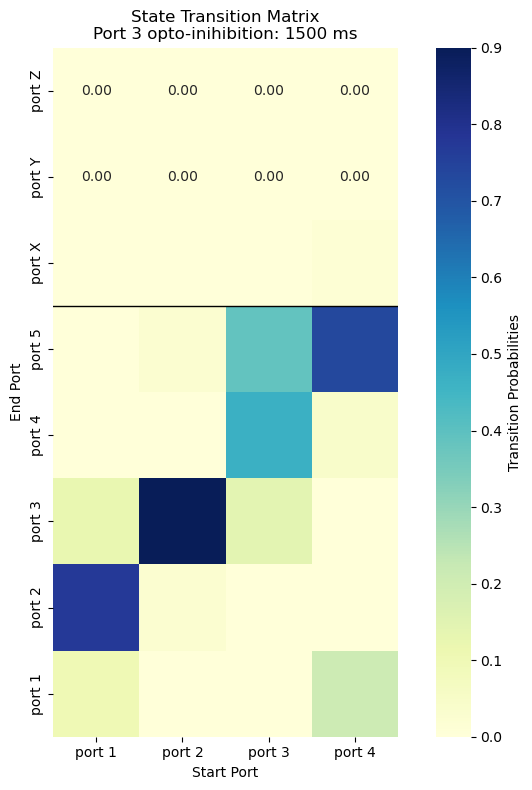

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_vertical_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, additional_title= 'Port 3 opto-inihibition: 1500 ms', ax=ax)

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_vertical_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, additional_title= 'Port 4 opto-inihibition: 1500 ms', ax=ax)

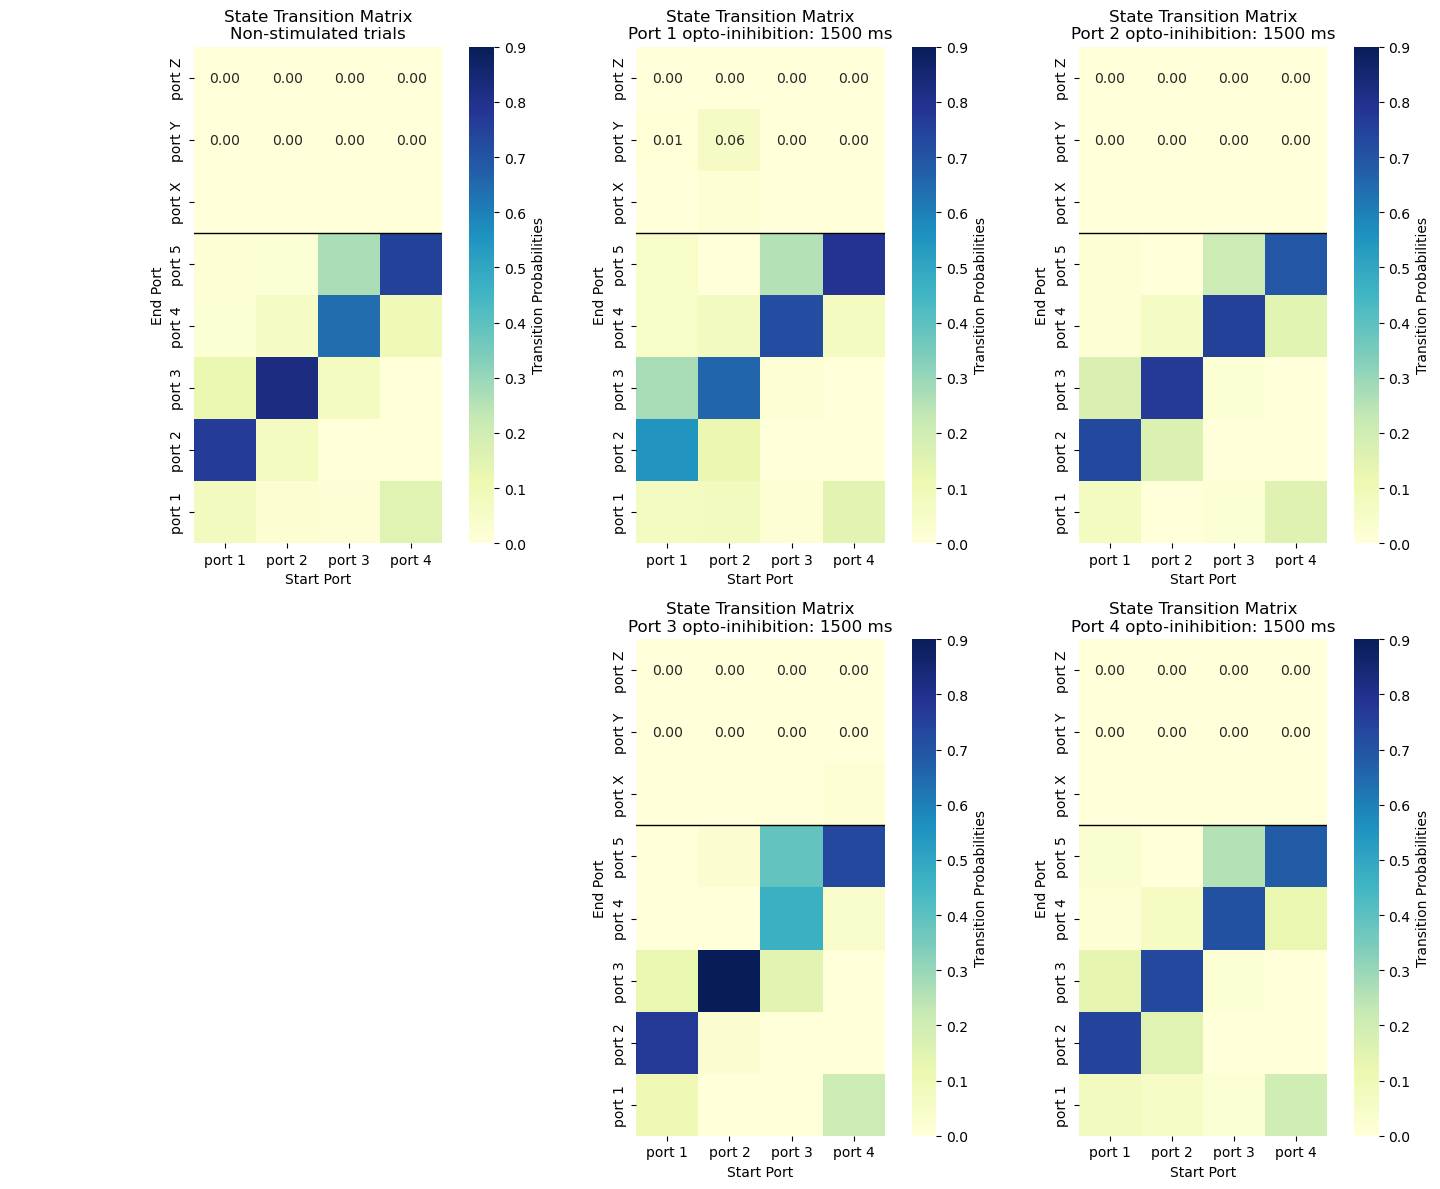

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_vertical_transition_matrix(control_df, normalize=True, display_numbers=True, additional_title= 'Non-stimulated trials', ax=axs[0, 0])
plot_vertical_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, additional_title= 'Port 1 opto-inihibition: 1500 ms', ax=axs[0, 1])
plot_vertical_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, additional_title= 'Port 2 opto-inihibition: 1500 ms', ax=axs[0, 2])
plot_vertical_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, additional_title= 'Port 3 opto-inihibition: 1500 ms', ax=axs[1, 1])
plot_vertical_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, additional_title= 'Port 4 opto-inihibition: 1500 ms', ax=axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.2) # You can adjust this value as needed
plt.show()


In [24]:
def plot_transition_matrix(df, normalize=False, display_numbers=False, additional_title=None, ax=None, colorbar=True,
                           limit_start_ports=False):
    # Create a copy of df
    df_copy = df.copy()

    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by start and end port and count the number of each transition
    transition_counts = df_copy.groupby(['start_poke_port', 'end_poke_port']).size().unstack(fill_value=0)

    # Transpose the transition_counts matrix, this is because sns.heatmap plots the first row at the top of the plot
    transition_counts = transition_counts.transpose()

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)


    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values)

    if normalize:
        # Normalize across rows to get transition probabilities
        row_sums = transition_counts.sum(axis=0, keepdims=True)
        row_sums[row_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / row_sums
        colorbar_label = 'Transition Probabilities'
        title = 'State Transition Matrix'

    else:
        colorbar_label = 'Number of Transitions'
        title = 'Absolute Transition Matrix'

    # Add the additional title if specified by the user
    if additional_title:
        title = title + '\n' + additional_title

    # If no Axes object was provided, create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Determine the number of start ports to include in the plot
    if limit_start_ports:
        start_ports_to_include = 4
    else:
        start_ports_to_include = transition_counts.shape[1]

    # Plotting transition matrix with colorbar length adjusted to match the heatmap
    cax = sns.heatmap(transition_counts[:,:start_ports_to_include], annot=display_numbers, fmt = ".2f", cmap='YlGnBu', vmin=0, vmax=0.9, ax=ax,
                      xticklabels=ordered_ports[:start_ports_to_include], yticklabels=ordered_ports[::-1], cbar=colorbar, 
                      cbar_kws={'shrink': .7})
                      
    ax.set_title(title)
    ax.set_xlabel('Start Port')
    ax.set_ylabel('End Port')
    ax.set_aspect('equal')  # set aspect ratio

    # Set rotation of xticklabels
    cax.set_xticklabels(cax.get_xticklabels(), rotation=0)

    # Add a blue horizontal line in between rows of port 5 and port X
    ax.axhline(y=3, color='b', linewidth=1)

    # Add a blue vertical line in between column of port 5 and port X
    ax.axvline(x=5, color='m', linewidth=1)

    # Add a colorbar with label
    if colorbar:
        cbar = cax.collections[0].colorbar
        cbar.set_label(colorbar_label)

    # Save the figure
    save_path = os.path.join(Output_Folder, current_animal, 'plots', f'{additional_title}_heatmap.png')

    # Ensure the directory exists
    os.makedirs(os.path.join(Output_Folder, current_animal, 'plots'), exist_ok=True)

    plt.tight_layout()

    if ax is None:
        plt.show()  # Only show the plot if no Axes object was provided. If an Axes was provided, plt.show() should be called externally.


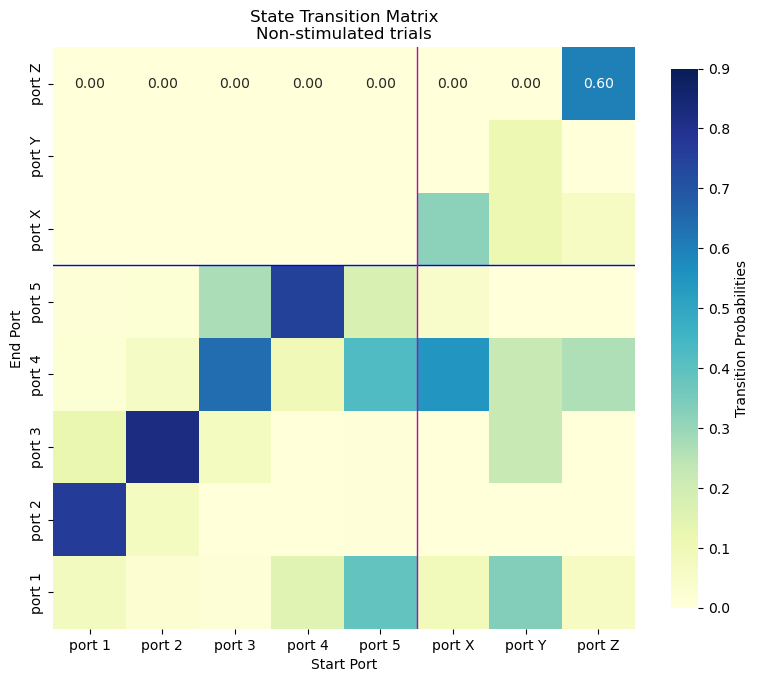

In [25]:

fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(control_df, normalize=True, display_numbers=True, additional_title= 'Non-stimulated trials', ax=ax)
plt.show()

In [26]:

fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(control_df, normalize=True, display_numbers=True, limit_start_ports=True ,additional_title= 'Non-stimulated trials', ax=ax)
plt.show()

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, limit_start_ports=False ,additional_title= 'Port 1 opto-inihibition: 1500 ms', ax=ax)
plt.show()

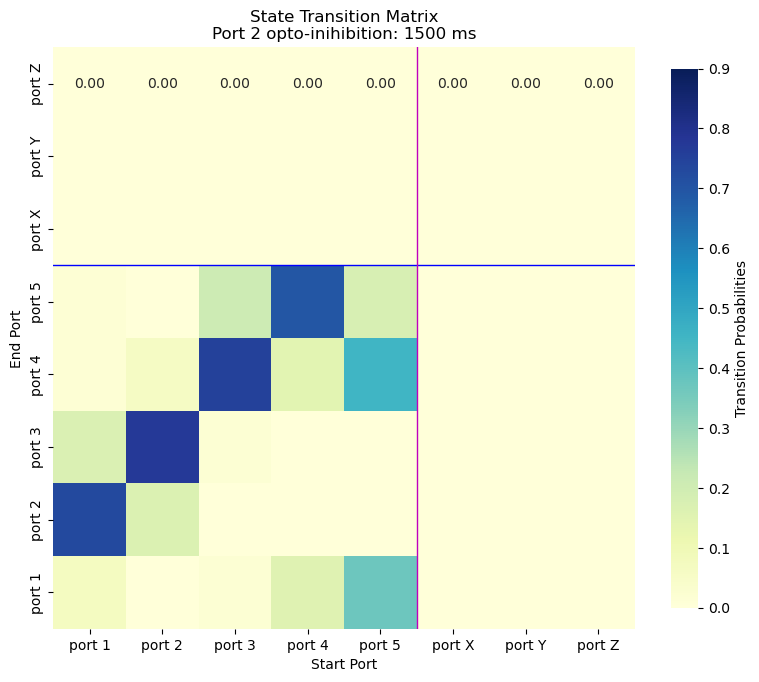

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, limit_start_ports=False ,additional_title= 'Port 2 opto-inihibition: 1500 ms', ax=ax)
plt.show()

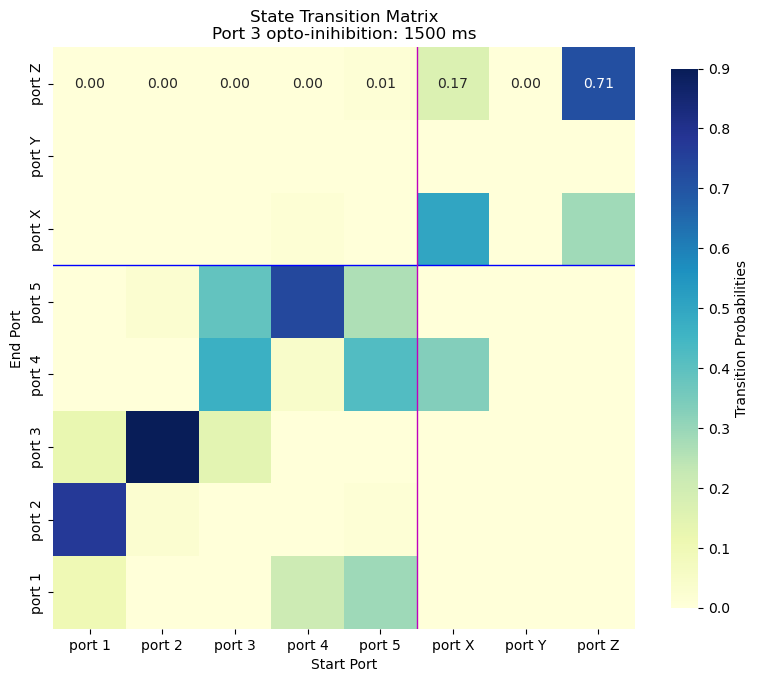

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, limit_start_ports=False ,additional_title= 'Port 3 opto-inihibition: 1500 ms', ax=ax)
plt.show()

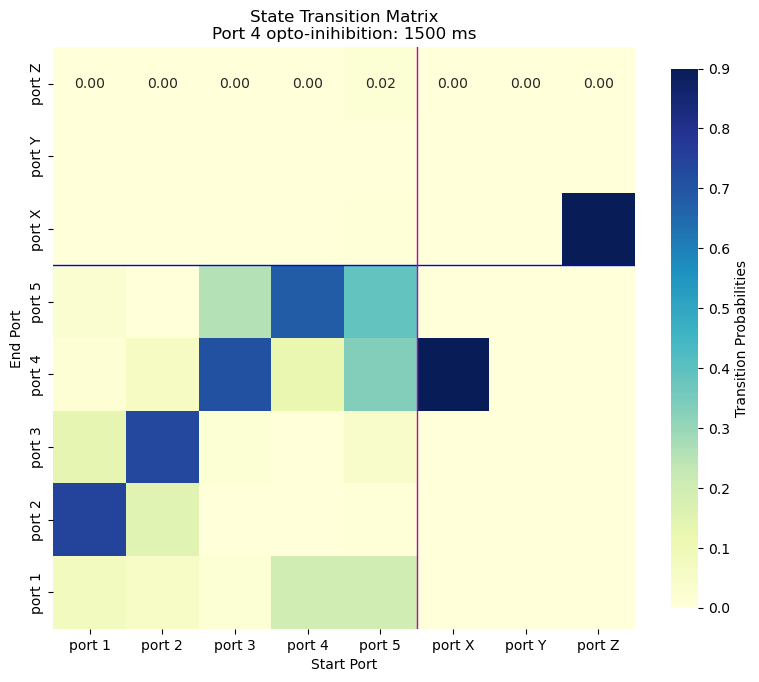

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, limit_start_ports=False ,additional_title= 'Port 4 opto-inihibition: 1500 ms', ax=ax)
plt.show()

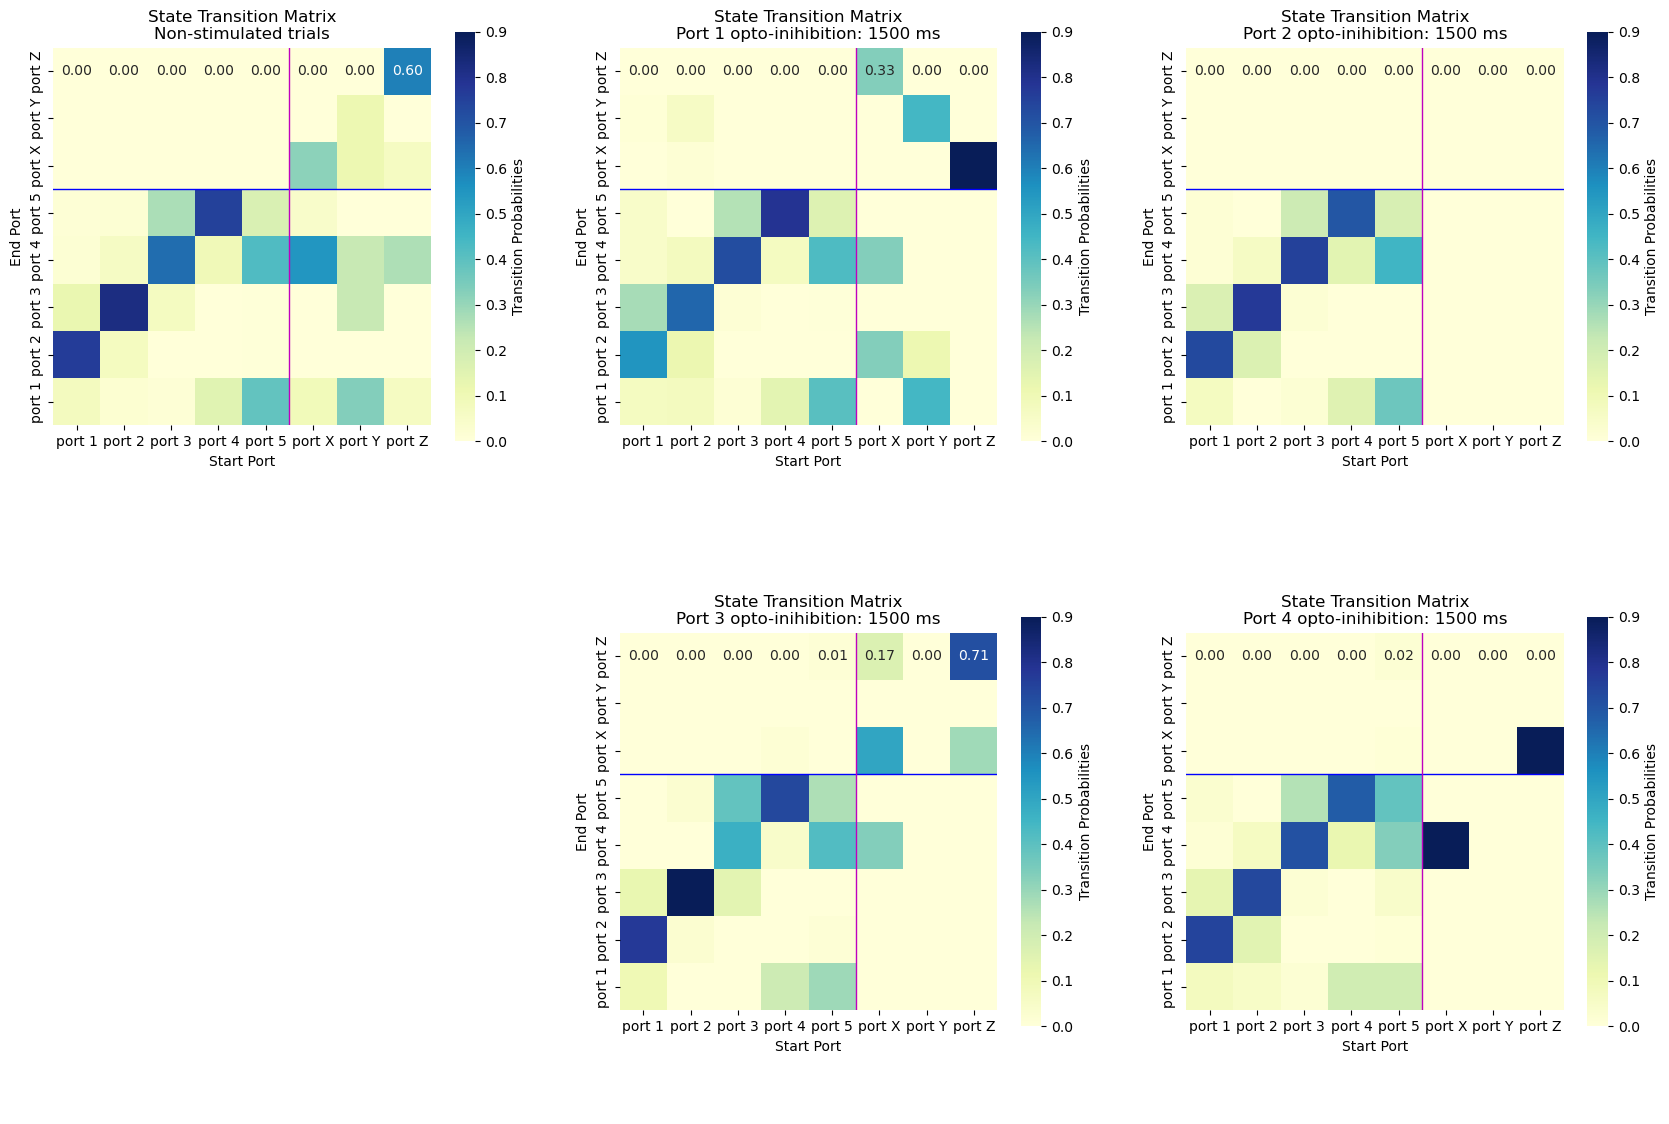

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_transition_matrix(control_df, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Non-stimulated trials', ax=axs[0, 0])
plot_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 1 opto-inihibition: 1500 ms', ax=axs[0, 1])
plot_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 2 opto-inihibition: 1500 ms', ax=axs[0, 2])
plot_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 3 opto-inihibition: 1500 ms', ax=axs[1, 1])
plot_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 4 opto-inihibition: 1500 ms', ax=axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# Adjust spaces between subplots and around the plot
fig.tight_layout()
fig.subplots_adjust(left=0.1, wspace=0.2, hspace=0) # You can adjust this value as needed
plt.show()

In [32]:
def compute_transition_matrix(df, normalize=False):
    """
    Computes the transition matrix from the given dataframe.

    Args:
        df (pandas.DataFrame): The dataframe containing the transition data.
        normalize (bool): Whether to normalize the transition matrix to get transition probabilities.

    Returns:
        numpy.ndarray: The transition matrix.
    """

    # Create a copy of df
    df_copy = df.copy()

    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by start and end port and count the number of each transition
    transition_matrix = df_copy.groupby(['start_poke_port', 'end_poke_port']).size().unstack(fill_value=0)

    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_matrix = np.nan_to_num(transition_matrix.values)

    if normalize:
        # Normalize across rows to get transition probabilities
        row_sums = transition_matrix.sum(axis=0, keepdims=True)
        row_sums[row_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_matrix = transition_matrix / row_sums
    print('in this transition matrix, the rows are the start ports and the columns are the end ports')
    return transition_matrix

In [33]:
# plot transition matrix

transition_matrix = compute_transition_matrix(control_df, normalize=True)
transition_matrix
type(transition_matrix)
# Sum across row (i.e., sum all values in each row)
row_sums = transition_matrix.sum(axis=0)

# Print the result
print("Sum of each row:\n", row_sums)
# print(transition_matrix
# plot transition matrix

sns.heatmap(transition_matrix, cmap='Blues', annot=True, fmt='.2f')
# position x-axis on top
plt.gca().xaxis.tick_top()

in this transition matrix, the rows are the start ports and the columns are the end ports
Sum of each row:
 [1. 1. 1. 1. 1. 1. 1. 1.]


### Analysis for transition times

In [34]:
# find all sequences from a dataframe arranged according to their cumulative_trial_ids

# get all unique cumulative_trial_ids

cumulative_trial_ids = control_df['cumulative_trial_id'].unique()
cumulative_trial_ids.sort()
# cumulative_trial_ids
# access the dataframe at any cumulative trial id

# trial_df = control_df[control_df['cumulative_trial_id'] == cumulative_trial_ids[0]].reset_index(drop=True)
# trial_df.head()

In [35]:
control_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7526 entries, 61391 to 52745
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     7526 non-null   int64  
 1   trial_id                       7526 non-null   int64  
 2   transition_type                7526 non-null   int64  
 3   start_poke_port                7526 non-null   int64  
 4   end_poke_port                  7526 non-null   int64  
 5   start_poke_in_timestamp        7526 non-null   float64
 6   start_poke_out_timestamp       7526 non-null   float64
 7   end_poke_in_timestamp          7526 non-null   float64
 8   end_poke_out_timestamp         7524 non-null   float64
 9   out_in_latency                 7526 non-null   float64
 10  in_in_latency                  7526 non-null   float64
 11  repeat_filter                  7526 non-null   int64  
 12  2s_time_filter_out_in          7526 non-null   i

In [37]:
##TODO - replace the values of opto_condition and opto_stimulated_port with a number rather than the numpy array as all of them are same

def filter_dataframe(df, filter_sequence_from_start_port=True):
    """
    This function filters a given dataframe based on specific conditions and returns a new dataframe.
    """
    # List to store the updated rows
    filtered_rows = []

    # Loop through each unique animal_id
    for animal in df['animal_id'].unique():
        animal_df = df[df['animal_id'] == animal].copy()

        # Get all unique cumulative_trial_ids for the current animal and sort them
        unique_trial_ids = animal_df['cumulative_trial_id'].unique()
        unique_trial_ids.sort()

        for trial_id in unique_trial_ids:
            # Filter DataFrame for specific trial
            trial_df = animal_df[animal_df['cumulative_trial_id'] == trial_id].copy()

            # Find the index of first occurrence based on filter_sequence_from_start_port
            if filter_sequence_from_start_port:
                # Find the index of first occurrence of 2 in start_poke_port
                trial_start_index = trial_df[trial_df['start_poke_port'] == 2].index.min()
            else:
                # Set trial_start_index to the first start_poke_port
                trial_start_index = trial_df.index.min()

            # If there's no valid trial_start_index for the trial, just continue to the next trial
            if pd.isna(trial_start_index):
                continue

            # Filter rows that occur at or after the trial_start_index
            updated_trial_df = trial_df.loc[trial_start_index:].copy()

            # Set reference timestamp
            reference_timestamp = updated_trial_df.loc[trial_start_index, 'start_poke_in_timestamp']

            # Calculate latency to start trial
            latency_to_start_trial = reference_timestamp - trial_df['start_poke_in_timestamp'].iloc[0]

            # Update timestamp columns and create lists
            for timestamp_column in ['start_poke_in_timestamp', 'start_poke_out_timestamp', 
                                    'end_poke_in_timestamp', 'end_poke_out_timestamp']:
                updated_trial_df[timestamp_column] = list(updated_trial_df[timestamp_column] - reference_timestamp)

            # Calculate new in_in_latency and out_in_latency and create lists
            updated_trial_df['in_in_latency'] = list(updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_in_timestamp'])
            updated_trial_df['out_in_latency'] = list(updated_trial_df['end_poke_in_timestamp'] - updated_trial_df['start_poke_out_timestamp'])

            # Condense the updated trial DataFrame to one row
            condensed_row = updated_trial_df.iloc[0]
            array_columns = ['transition_type', 'start_poke_port', 'end_poke_port', 
                            'start_poke_in_timestamp', 'start_poke_out_timestamp', 
                            'end_poke_in_timestamp', 'end_poke_out_timestamp', 
                            'out_in_latency', 'in_in_latency', 'repeat_filter', 
                            '2s_time_filter_out_in', '2s_time_filter_in_in', 
                            'opto_condition', 'opto_stimulated_port', 'training_level',
                            'camera_port_in_times', 'camera_port_out_times',
                            'camera_trial_start_times', 'camera_trial_end_times']
            for column in array_columns:
                condensed_row[column] = np.array(updated_trial_df[column])

            condensed_row['latency_to_start_trial'] = latency_to_start_trial

            # Append condensed row to the filtered DataFrame
            filtered_rows.append(condensed_row)

    # Convert list of rows to DataFrame
    filtered_df = pd.concat(filtered_rows, axis=1).transpose()

    # Reset index of the new DataFrame
    filtered_df.reset_index(drop=True, inplace=True)

    # Drop unnecessary columns
    filtered_df.drop(['led_intensities_ports_2_3_4_5', 'reward_amounts_ports_1_2_3_4'], axis=1, inplace=True)

    return filtered_df

# Usage:
filtered_control_df = filter_dataframe(control_df, filter_sequence_from_start_port=True)


In [39]:
control_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7526 entries, 61391 to 52745
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     7526 non-null   int64  
 1   trial_id                       7526 non-null   int64  
 2   transition_type                7526 non-null   int64  
 3   start_poke_port                7526 non-null   int64  
 4   end_poke_port                  7526 non-null   int64  
 5   start_poke_in_timestamp        7526 non-null   float64
 6   start_poke_out_timestamp       7526 non-null   float64
 7   end_poke_in_timestamp          7526 non-null   float64
 8   end_poke_out_timestamp         7524 non-null   float64
 9   out_in_latency                 7526 non-null   float64
 10  in_in_latency                  7526 non-null   float64
 11  repeat_filter                  7526 non-null   int64  
 12  2s_time_filter_out_in          7526 non-null   i

In [147]:
def plot_timestamp_distribution(df, timestamps, x_range=(0, 5), binwidth=0.02, stat='density', exclude_ports=[], ax=None):
    """
    This function plots the distribution of timestamps for different ports.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains timestamps and port information.
    timestamps (str): The column name in df for the timestamp data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    ax (matplotlib.axes.Axes): Axes object to draw the plot onto.
    """
    
    # List to hold latency data for different ports
    latency_data = []

    # Ordered port labels
    port_labels = {
        2: 'Port 1', 1: 'Port 2', 6: 'Port 3', 3: 'Port 4',
        7: 'Port 5', 4: 'Other ports', 5: 'Other ports', 8: 'Other ports'
    }
    
    # Remove the labels of excluded ports
    for port in exclude_ports:
        if port in port_labels:
            del port_labels[port]
    
    # Define the initial order
    initial_order = ['Port 1', 'Port 2', 'Port 3', 'Port 4', 'Port 5', 'Other ports']
    
    # Filter out the ones that are no longer in port_labels after exclusion
    ordered_ports = [port for port in initial_order if port in port_labels.values()]


    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, timestamps)):
            if port in port_labels.keys():
                latency_data.append((latency, port_labels[port]))
    

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[timestamps, 'ports'])

    # Convert the 'ports' column to an ordered categorical type
    latency_df['ports'] = pd.Categorical(latency_df['ports'], categories=ordered_ports, ordered=True)

    # If no Axes object provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Explicitly Define Color Palette
    palette_colors = {
        "Port 1": "#e74c3c", "Port 2": "#3498db", "Port 3": "#2ecc71",
        "Port 4": "#f39c12", "Port 5": "#8e44ad", "Other ports": "#95a5a6"
    }
    # Filter palette to only include the colors of the ports being plotted
    palette_colors = {port: color for port, color in palette_colors.items() if port in ordered_ports}

    # Plot the distribution of timestamps for each port
    hist_plot = sns.histplot(latency_df, x=timestamps, binwidth=binwidth, hue='ports', element="step", stat=stat, kde=False, palette=palette_colors, ax=ax)

    ax.set_xlim(x_range)
    ax.set_title(f'Distribution of {timestamps} for different ports')
    ax.set_xlabel('time from first correct poke (in s)')
    ax.set_ylabel(stat)

    # Add vertical lines at the median value of each distribution
    for port in latency_df['ports'].cat.categories:  # Using .cat.categories
        median_latency = latency_df[latency_df['ports'] == port][timestamps].median()
        ax.axvline(median_latency, linestyle='--', color=palette_colors[port])

    return ax

ax = plot_timestamp_distribution(filtered_control_df, 'in_in_latency', x_range=(0, 5), binwidth=0.02, stat='density', exclude_ports=[], ax=None)
ax.set_xlabel('PortIN times from first correct poke (in s)')
plt.show()


TypeError: iteration over a 0-d array

TypeError: unhashable type: 'numpy.ndarray'

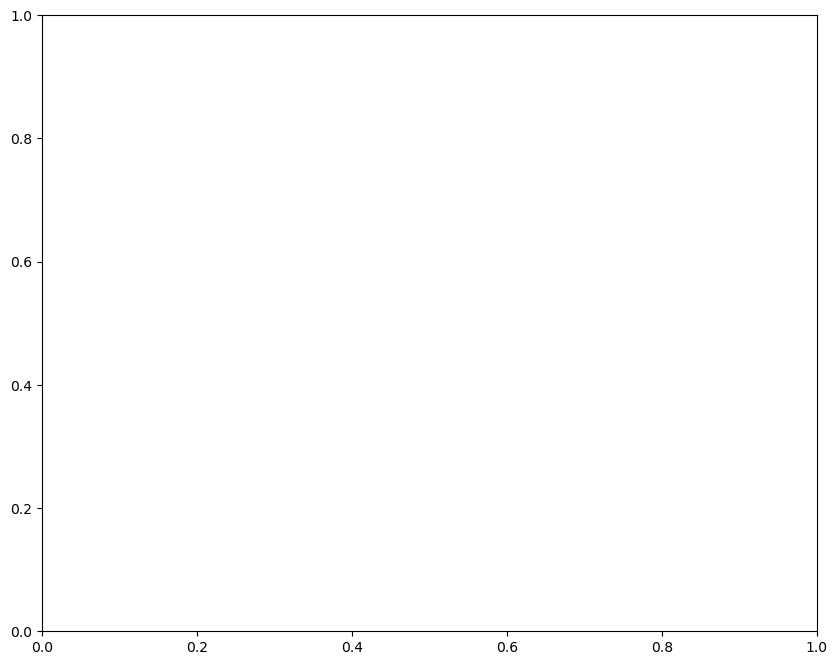

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_timestamp_distribution(filtered_control_df, 'start_poke_in_timestamp', x_range=(-0.1,5), binwidth=0.02, stat = 'density', exclude_ports=[4, 5, 8], ax = ax)
ax.set_xlabel('PortIN times from first correct poke (in s)')
ax.set_ylim(0, 3)
plt.show()

In [ ]:
# filtered_control_df already exists
filtered_optostim_port_1 = filter_dataframe(optostim_port_1, filter_sequence_from_start_port= True)
filtered_optostim_port_2 = filter_dataframe(optostim_port_2, filter_sequence_from_start_port= True)
filtered_optostim_port_3 = filter_dataframe(optostim_port_3, filter_sequence_from_start_port= True)
filtered_optostim_port_4 = filter_dataframe(optostim_port_4, filter_sequence_from_start_port= True)

### Plot the distribution of port_in_times 

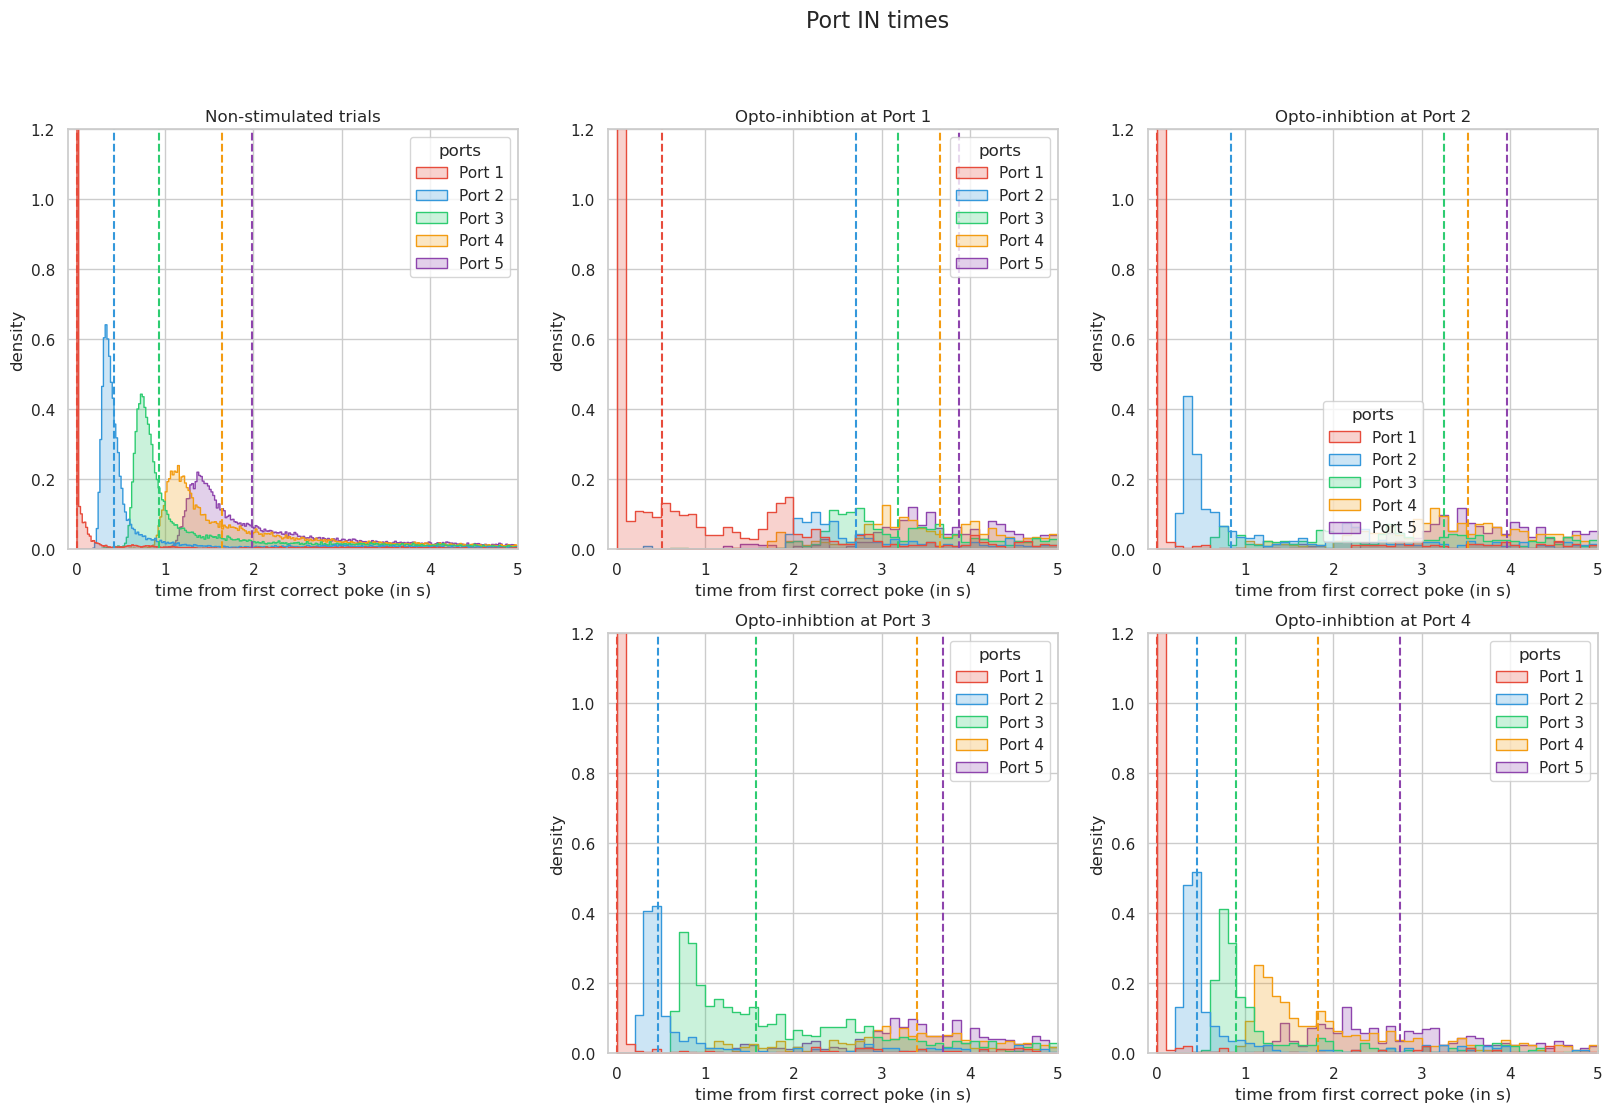

In [ ]:
# fetch all opto data

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_distribution(filtered_control_df, 'start_poke_in_timestamp', x_range=(-0.1,5), binwidth=0.02, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[0, 0])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[0, 1])
plot_timestamp_distribution(filtered_optostim_port_2, 'start_poke_in_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax= axs[0, 2])
plot_timestamp_distribution(filtered_optostim_port_3, 'start_poke_in_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[1, 1])
plot_timestamp_distribution(filtered_optostim_port_4, 'start_poke_in_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# set optional titles
axs[0, 0].set_title('Non-stimulated trials')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# set optional y-axis limits
axs[0, 0].set_ylim(0, 1.2)
axs[0, 1].set_ylim(0, 1.2)
axs[0, 2].set_ylim(0, 1.2)
axs[1, 1].set_ylim(0, 1.2)
axs[1, 2].set_ylim(0, 1.2)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.05) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port IN times", fontsize=16)
plt.show()

### Plot the distribution of port_out_times

In [ ]:
# fetch all opto data

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_distribution(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,5), binwidth=0.02, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[0, 0])
plot_timestamp_distribution(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[0, 1])
plot_timestamp_distribution(filtered_optostim_port_2, 'start_poke_out_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax= axs[0, 2])
plot_timestamp_distribution(filtered_optostim_port_3, 'start_poke_out_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[1, 1])
plot_timestamp_distribution(filtered_optostim_port_4, 'start_poke_out_timestamp', x_range=(-0.1,5), binwidth=0.1, stat = 'density', exclude_ports=[4, 5, 8], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# set optional titles
axs[0, 0].set_title('Non-stimulated trials')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# set optional y-axis limits
axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[0, 2].set_ylim(0, 1)
axs[1, 1].set_ylim(0, 1)
axs[1, 2].set_ylim(0, 1)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.05) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port OUT times", fontsize=16)
plt.show()

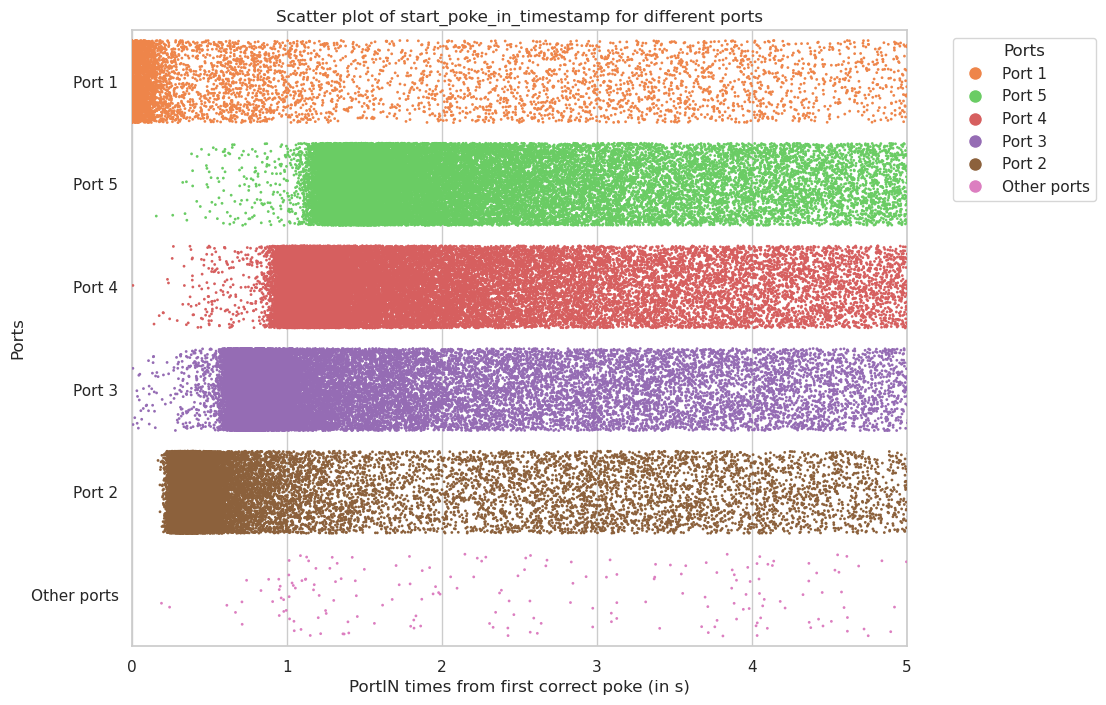

In [ ]:
def plot_timestamp_strip(df, timestamps, x_range=(0, 5), exclude_ports=[], ax=None):
    """
    This function plots a scatter plot of timestamps for different ports.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains timestamps and port information.
    timestamps (str): The column name in df for the timestamp data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    ax (matplotlib.axes.Axes): Axes object to draw the plot onto.
    """

    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels = {2: 'Port 1', 1: 'Port 2',
                           6: 'Port 3', 3: 'Port 4',
                           7: 'Port 5', 4: 'Other ports',
                           5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, timestamps)):
            if port in port_labels.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[timestamps, 'ports'])

    # If no Axes object provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Use a color palette
    full_palette = sns.color_palette("muted", 10)
    palette_colors = full_palette[1:] # start from the third color

    # Generate a color dictionary based on the order of unique ports in the data
    color_dict = {port: palette_colors[i % len(palette_colors)] for i, port in enumerate(latency_df['ports'].unique())}

    # Plot the scatter plot of timestamps for each ports
    strip_plot = sns.stripplot(x=timestamps, y='ports', data=latency_df, size=2, jitter=0.4, palette=color_dict, hue='ports', ax=ax)

    # Set the limits of x-axis to 'zoom' in
    ax.set_xlim(x_range) 

    # Set the title and labels
    ax.set_title(f'Scatter plot of {timestamps} for different ports')
    ax.set_xlabel('Time from first correct poke (in s)')
    ax.set_ylabel('Ports')

    # Create legend with color patches
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=port,
                              markerfacecolor=color_dict[port], markersize=10) for port in latency_df['ports'].unique()]

    # Add legend to the plot
    ax.legend(handles=legend_elements, title="Ports", bbox_to_anchor=(1.05, 1), loc='upper left')

    return ax

ax = plot_timestamp_strip(filtered_control_df, 'start_poke_in_timestamp', x_range=(0,5), exclude_ports=[])
ax.set_xlabel('PortIN times from first correct poke (in s)')
plt.show()

### strip plot for port_in_times

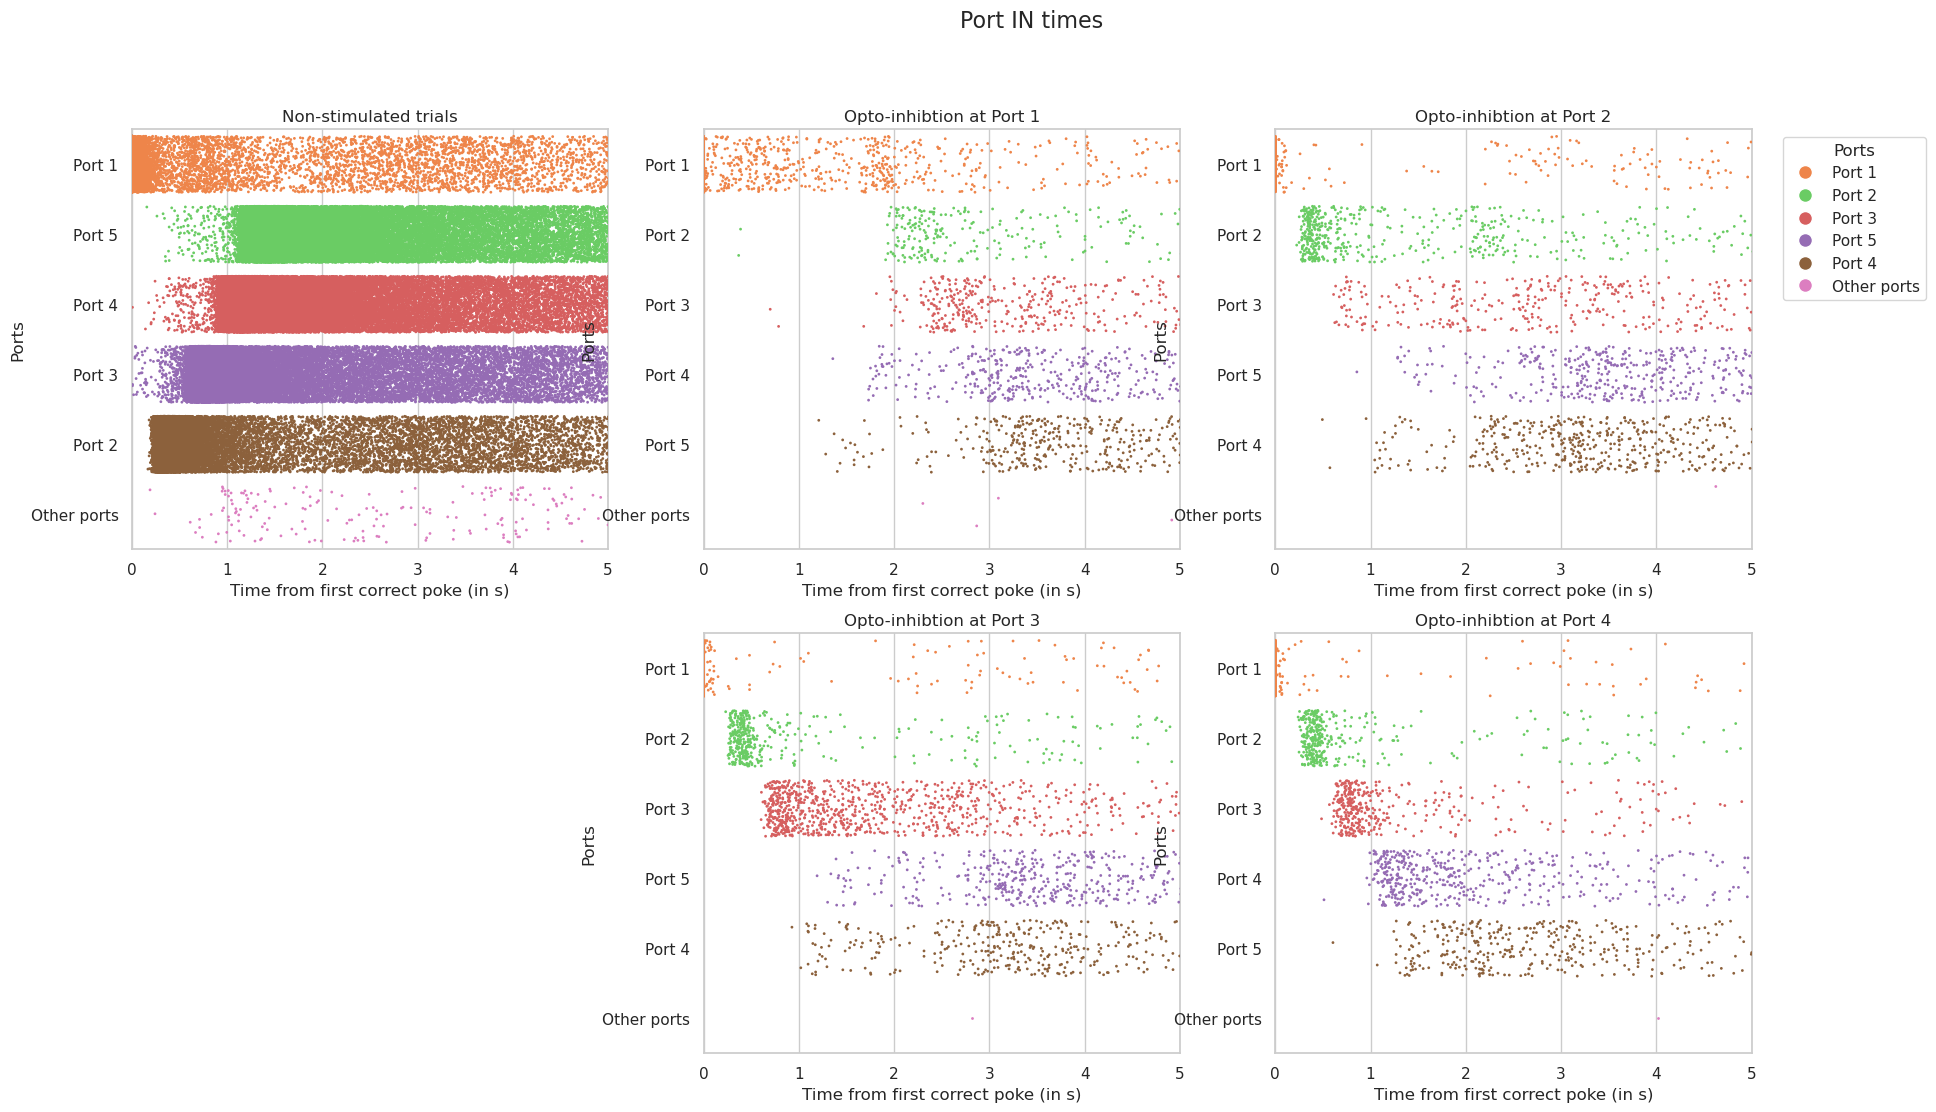

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_strip(filtered_control_df, 'start_poke_in_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[0, 0])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[0, 1])
plot_timestamp_strip(filtered_optostim_port_2, 'start_poke_in_timestamp', x_range=(0,5), exclude_ports=[], ax= axs[0, 2])
plot_timestamp_strip(filtered_optostim_port_3, 'start_poke_in_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[1, 1])
plot_timestamp_strip(filtered_optostim_port_4, 'start_poke_in_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# switch off unneeded legends
axs[0, 0].legend_.remove()
axs[0, 1].legend_.remove()
axs[1, 1].legend_.remove()
axs[1, 2].legend_.remove()

# set optional titles
axs[0, 0].set_title('Non-stimulated trials')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port IN times", fontsize=16)
plt.show()

### strip plot for port_out_times

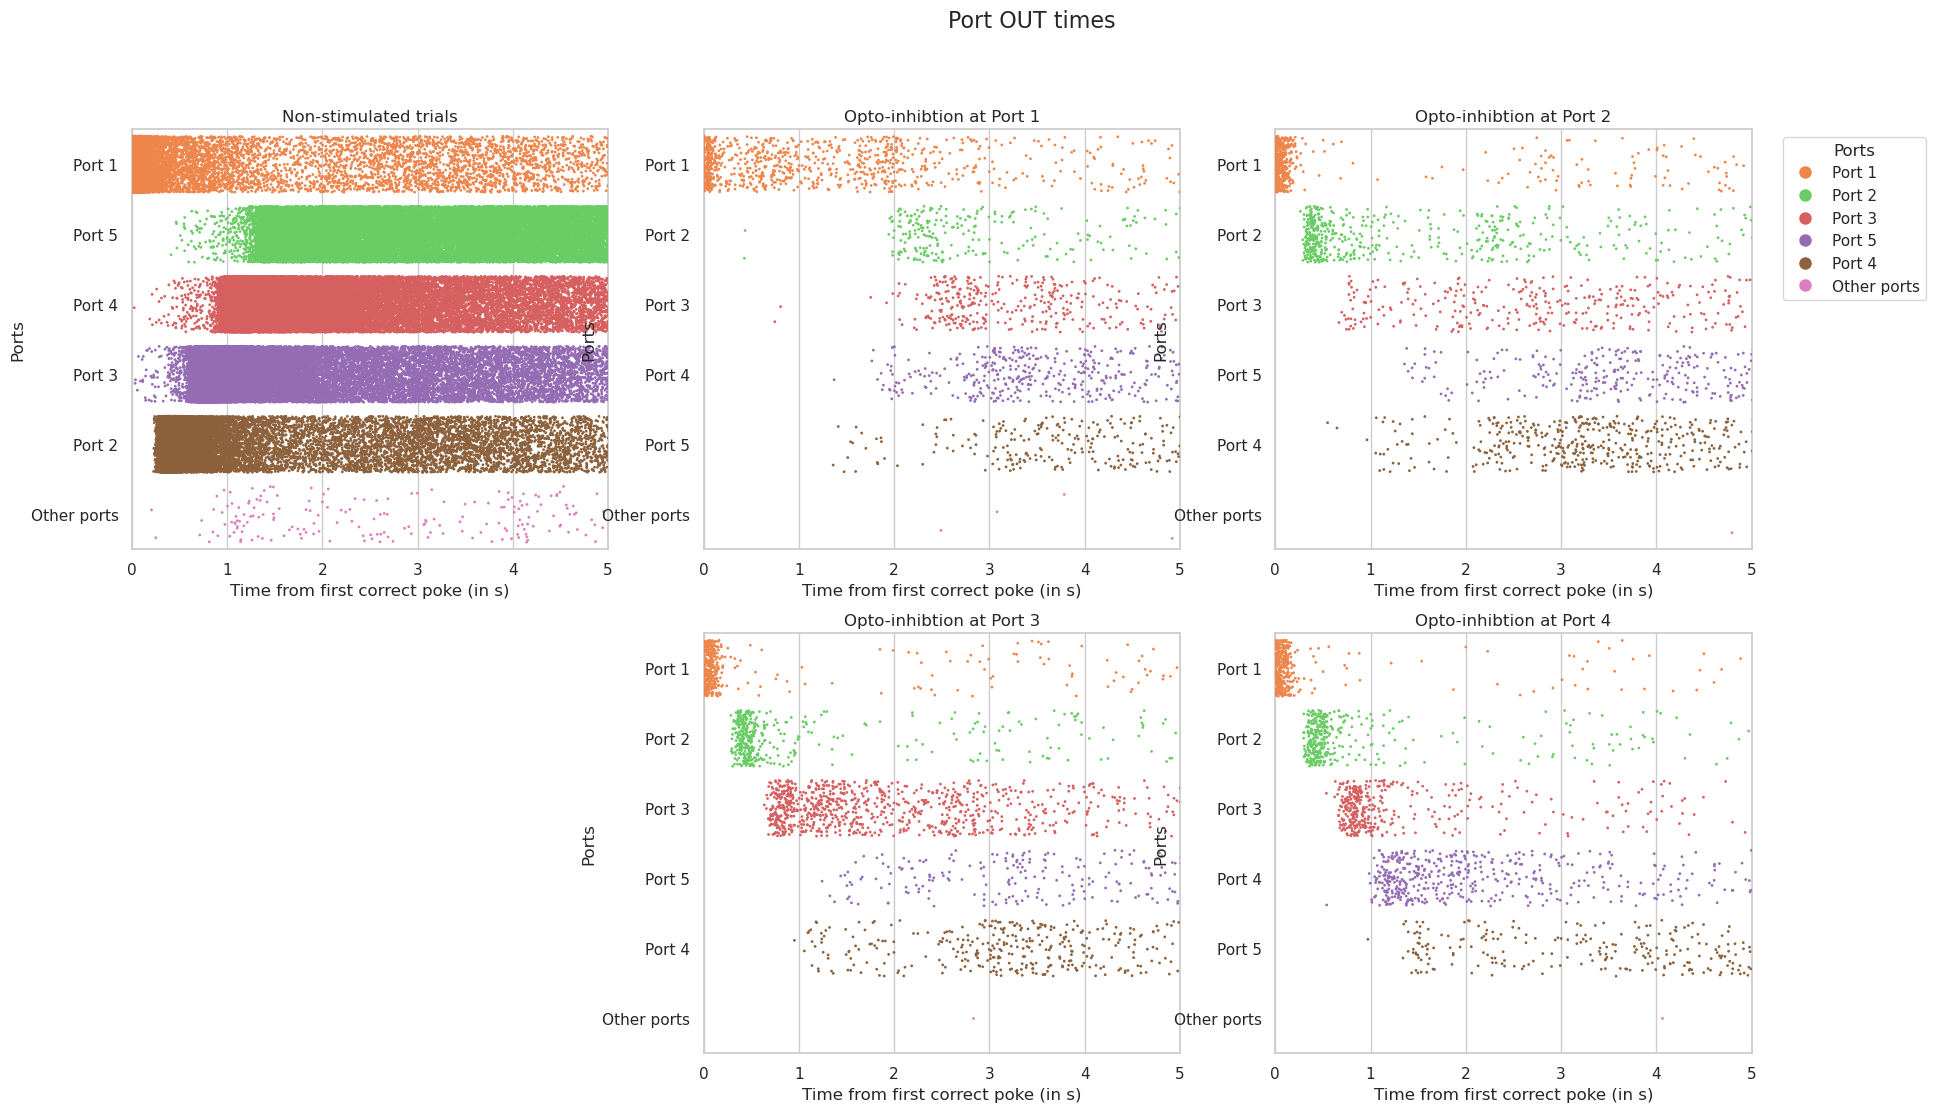

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timestamp_strip(filtered_control_df, 'start_poke_out_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[0, 0])
plot_timestamp_strip(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[0, 1])
plot_timestamp_strip(filtered_optostim_port_2, 'start_poke_out_timestamp', x_range=(0,5), exclude_ports=[], ax= axs[0, 2])
plot_timestamp_strip(filtered_optostim_port_3, 'start_poke_out_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[1, 1])
plot_timestamp_strip(filtered_optostim_port_4, 'start_poke_out_timestamp', x_range=(0,5), exclude_ports=[], ax = axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# switch off unneeded legends
axs[0, 0].legend_.remove()
axs[0, 1].legend_.remove()
axs[1, 1].legend_.remove()
axs[1, 2].legend_.remove()

# set optional titles
axs[0, 0].set_title('Non-stimulated trials')
axs[0, 1].set_title('Opto-inhibtion at Port 1')
axs[0, 2].set_title('Opto-inhibtion at Port 2')
axs[1, 1].set_title('Opto-inhibtion at Port 3')
axs[1, 2].set_title('Opto-inhibtion at Port 4')

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port OUT times", fontsize=16)
plt.show()

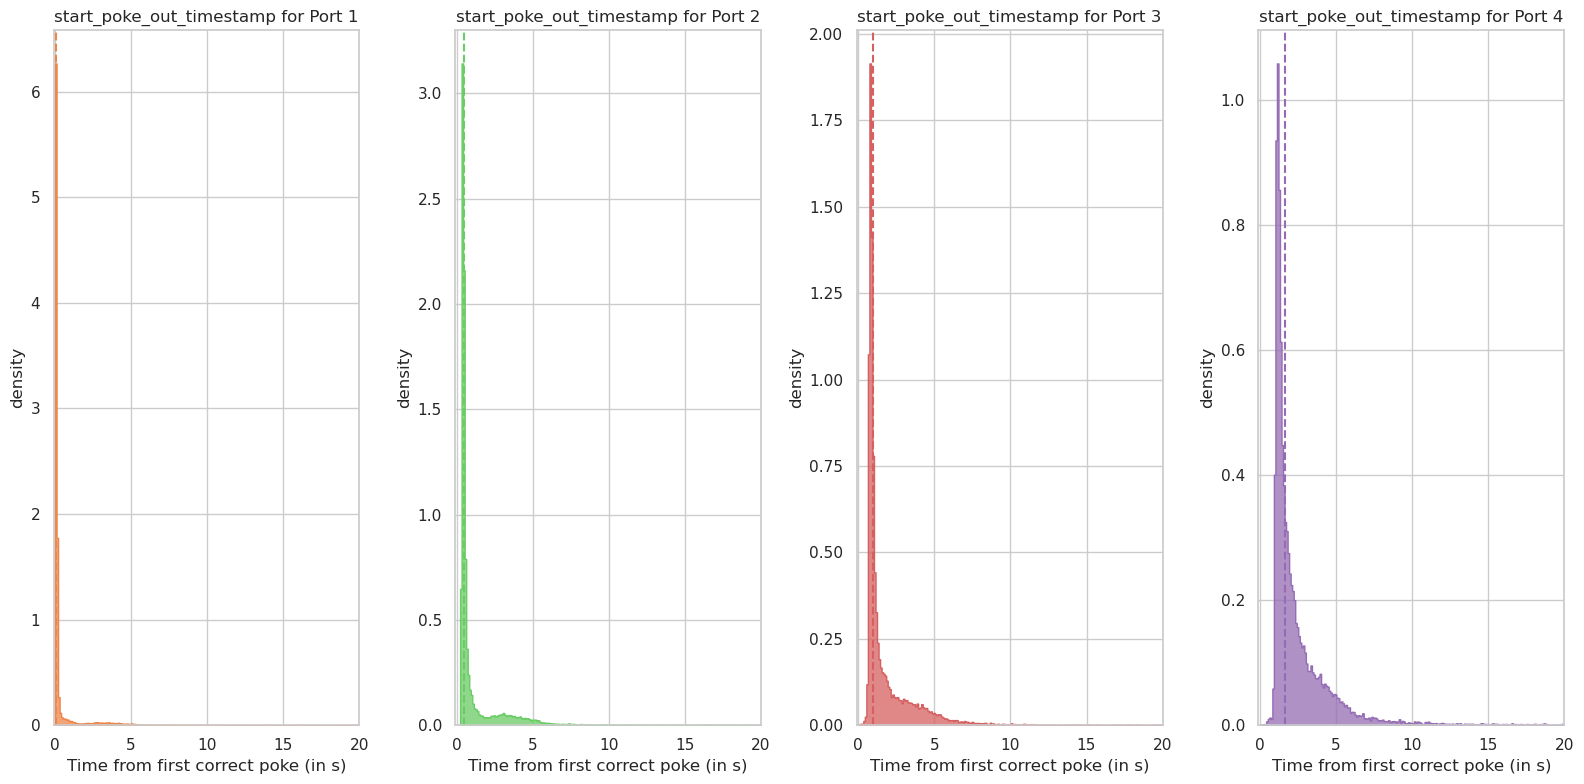

In [ ]:
def plot_timestamp_distribution_subplots(df, timestamps, x_range=(0, 5), binwidth = 0.02, stat = 'density', exclude_ports=[], fig_size=(15, 8), axes=None):
    """
    This function plots the distribution of timestamps for different ports on separate subplots.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains timestamps and port information.
    timestamps (str): The column name in df for the timestamp data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    fig_size (tuple): The size of the entire figure containing all subplots.
    """
    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels = {2: 'Port 1', 1: 'Port 2',
                   6: 'Port 3', 3: 'Port 4',
                   7: 'Port 5', 4: 'Other ports',
                   5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, timestamps)):
            if port in port_labels.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[timestamps, 'ports'])

    # Define a list of all possible ports
    possible_ports = ['Port 1', 'Port 2', 'Port 3', 'Port 4', 'Other ports']

    # Create a list of the ports in your data
    data_ports = latency_df['ports'].unique()

    # Create a new ordered_ports list that only includes ports in possible_ports that are also in your data
    ordered_ports = [port for port in possible_ports if port in data_ports]

    if axes is None:
        # Create a figure to hold the subplots
        fig, axes = plt.subplots(nrows=1, ncols=max(1, len(ordered_ports)), figsize=fig_size, sharex=True)
        if len(ordered_ports) == 1:
            axes = np.array([axes])  # Make sure axes is an array to handle single plot scenario

    # Use a color palette
    full_palette = sns.color_palette("muted", len(ordered_ports) + 1)  # Added 1 for starting from the second color
    palette_colors = full_palette[1:] 

    # Plot the distribution of timestamps for each port on a separate subplot
    for i, port in enumerate(ordered_ports):
        port_df = latency_df[latency_df['ports'] == port]
        ax = axes[i]
        sns.histplot(port_df, x=timestamps, color=palette_colors[i], element="step", binwidth=binwidth, stat=stat, ax=ax)

        # Set the title and labels
        ax.set_title(f'{timestamps} for {port}')
        ax.set_xlabel('Time from first correct poke (in s)')
        ax.set_ylabel(stat)

        # Set the limits of x-axis to 'zoom' in
        ax.set_xlim(x_range)

        # Add a vertical line at the median value of the distribution
        median_latency = port_df[timestamps].median()
        ax.axvline(median_latency, linestyle='--', color=palette_colors[i])

    # Reduce the vertical space between subplots
    plt.tight_layout()

    return ax.figure, axes



fig, axes = plot_timestamp_distribution_subplots(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,20), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(16, 8))
plt.show()


### plot_timestamp_distribution_subplots port_in_times

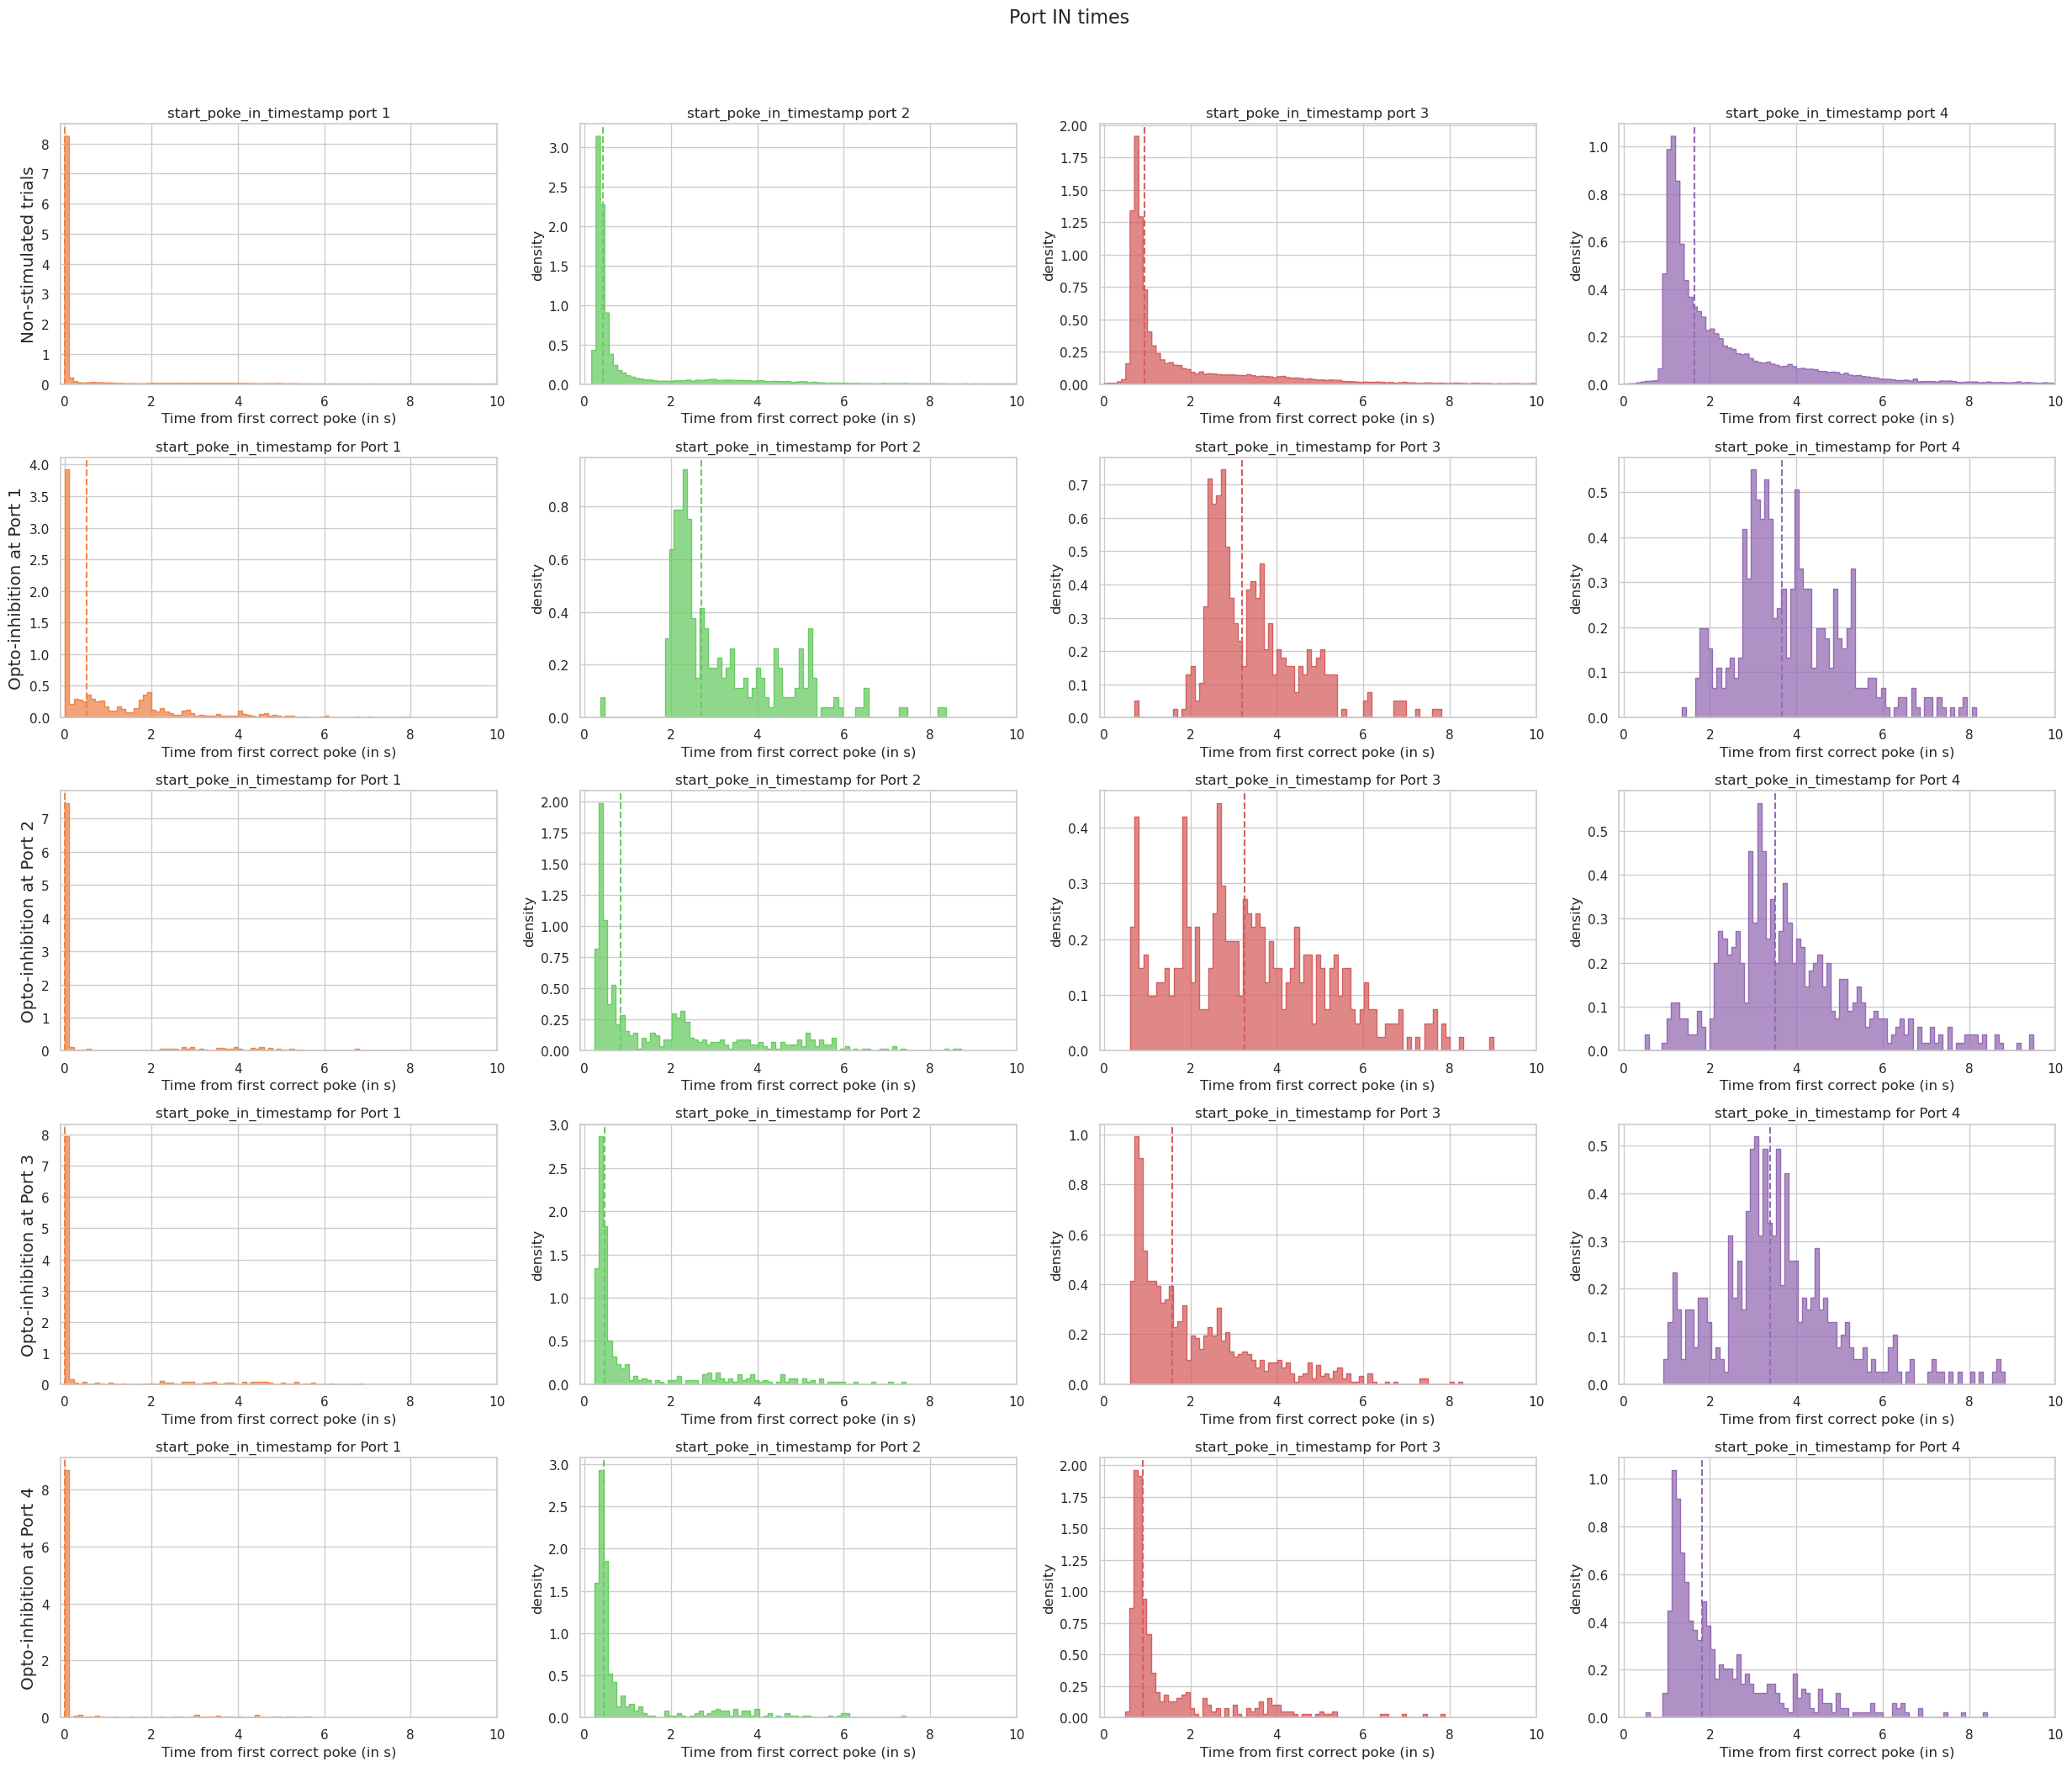

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(24, 20))

plot_timestamp_distribution_subplots(filtered_control_df, 'start_poke_in_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[0, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_1, 'start_poke_in_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[1, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_2, 'start_poke_in_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes= axs[2, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_3, 'start_poke_in_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[3, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_4, 'start_poke_in_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[4, :])

# set optional titles
# Define row and column labels
row_labels = ['Non-stimulated trials', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['start_poke_in_timestamp port 1', 'start_poke_in_timestamp port 2', 'start_poke_in_timestamp port 3', 'start_poke_in_timestamp port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port IN times", fontsize=16, y=1.05)
plt.show()

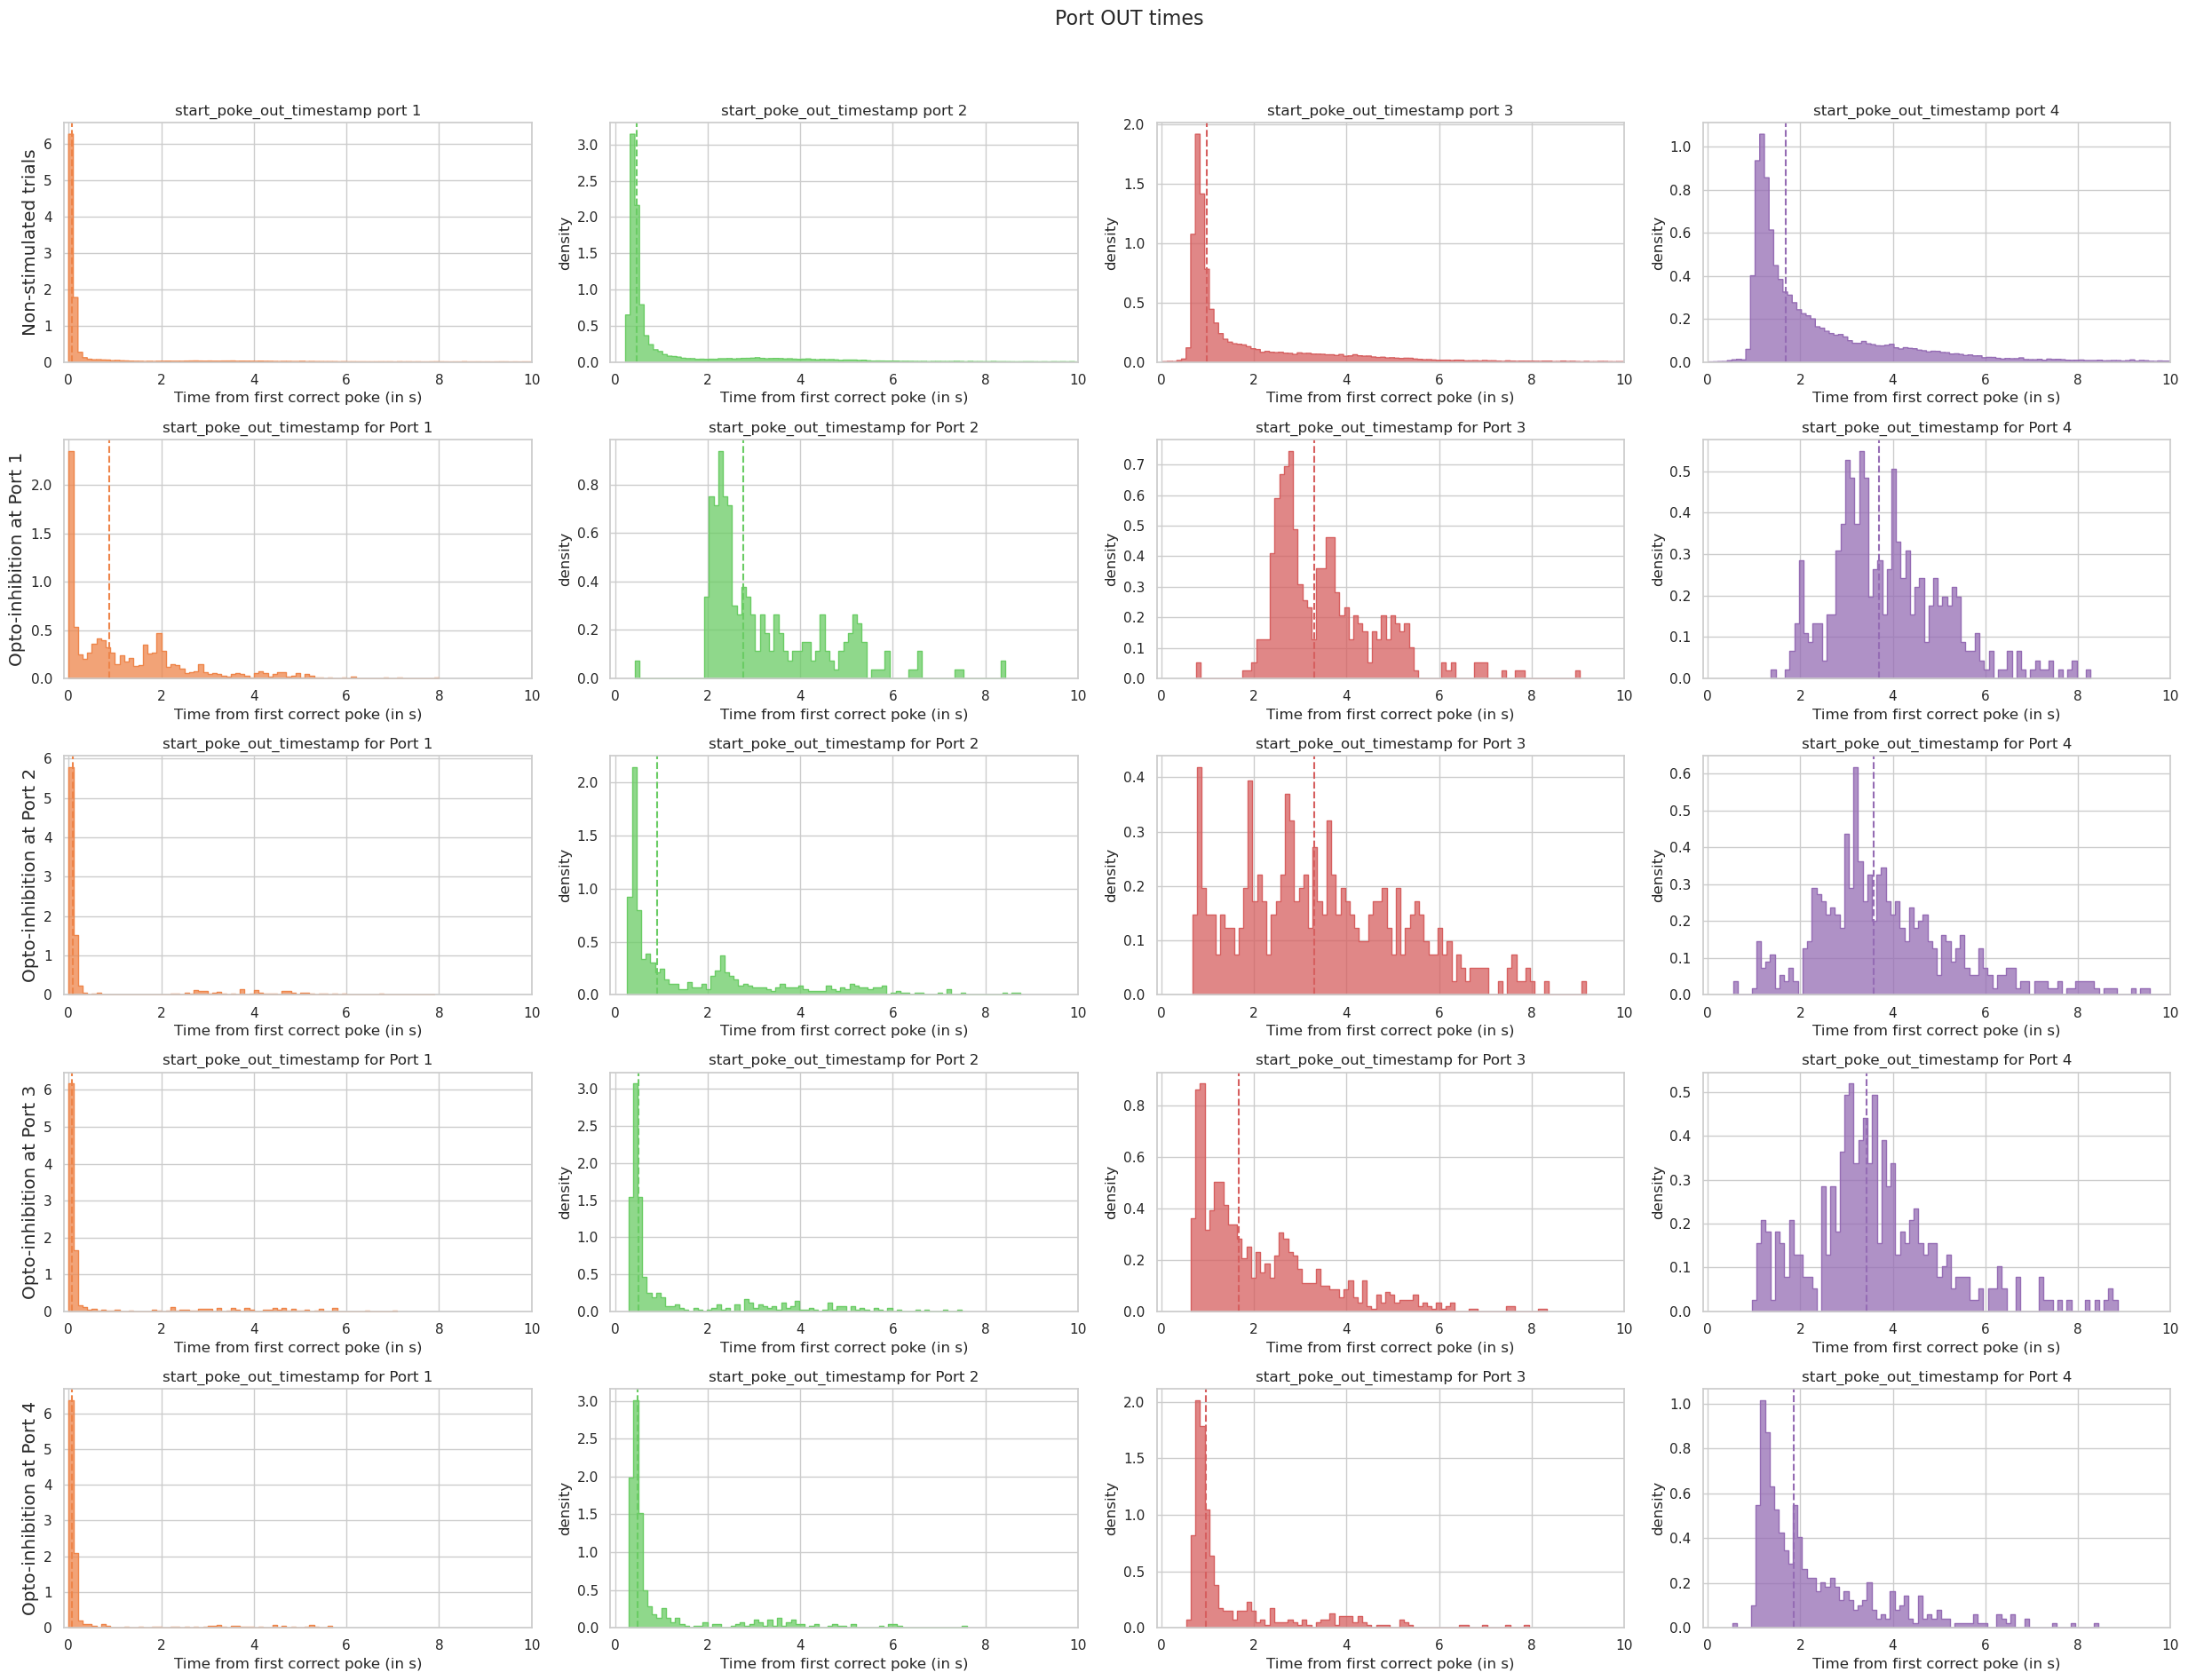

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(24, 18))

plot_timestamp_distribution_subplots(filtered_control_df, 'start_poke_out_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[0, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_1, 'start_poke_out_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[1, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_2, 'start_poke_out_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes= axs[2, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_3, 'start_poke_out_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[3, :])
plot_timestamp_distribution_subplots(filtered_optostim_port_4, 'start_poke_out_timestamp', x_range=(-0.1,10), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(12, 8), axes = axs[4, :])

# set optional titles
# Define row and column labels
row_labels = ['Non-stimulated trials', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['start_poke_out_timestamp port 1', 'start_poke_out_timestamp port 2', 'start_poke_out_timestamp port 3', 'start_poke_out_timestamp port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Port OUT times", fontsize=16, y=1.05)
plt.show()

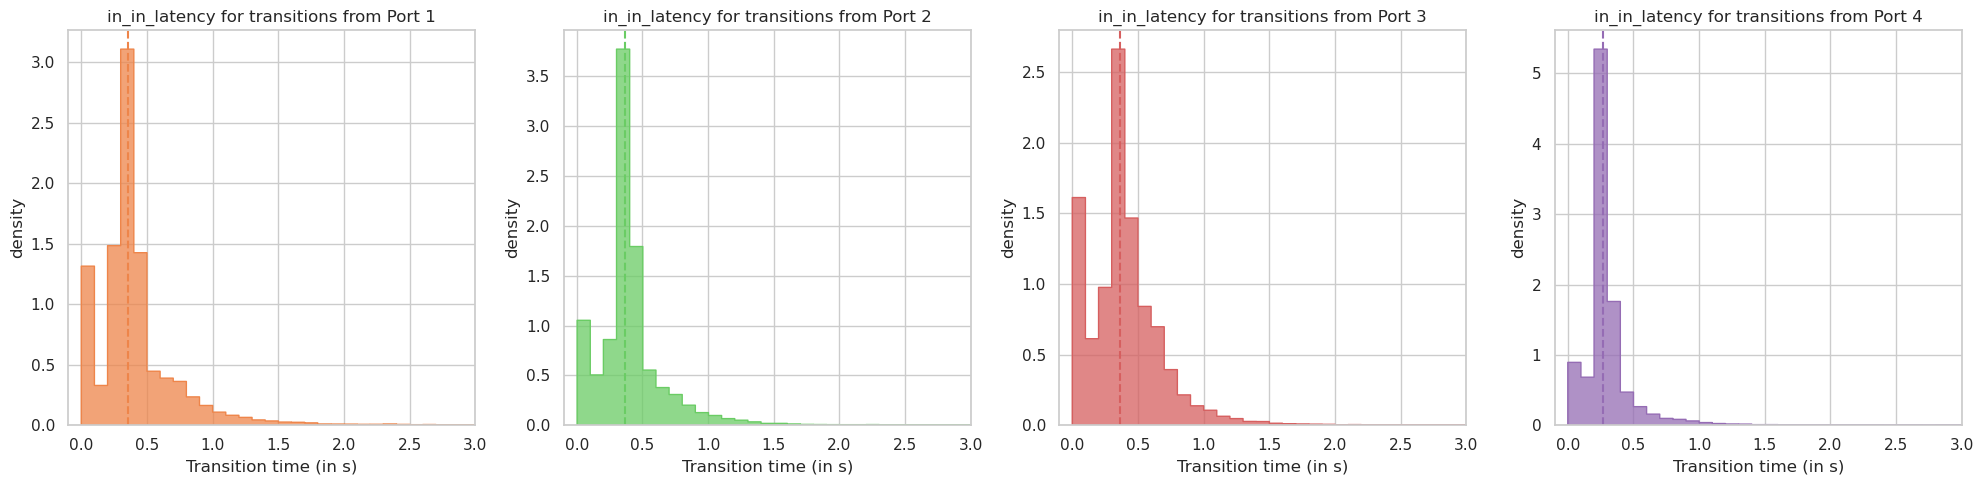

In [ ]:
def plot_latency_distribution_subplots(df, latencies, x_range=(0, 5), binwidth = 0.02, stat = 'density', exclude_ports=[], fig_size=(20, 5), axes=None):
    """
    This function plots the distribution of latencies for different ports on separate subplots.

    Parameters:
    df (pandas.DataFrame): Input DataFrame which contains latencies and port information.
    latencies (str): The column name in df for the latency data to plot.
    x_range (tuple): The range of x values to display in the plot.
    exclude_ports (list): List of ports to exclude from the plot.
    fig_size (tuple): The size of the entire figure containing all subplots.
    axes (list of matplotlib.axes.Axes or matplotlib.axes.Axes): List of Axes objects where the plots will be drawn or a single Axes object.
    """
    # List to hold latency data for different ports
    latency_data = []
    # Label each port
    port_labels_offsets = {2: 'Port 1', 1: 'Port 2',
                           6: 'Port 3', 3: 'Port 4',
                           7: 'Port 5', 4: 'Other ports',
                           5: 'Other ports', 8: 'Other ports'}

    for row in df.itertuples(index=False):
        for port, latency in zip(row.start_poke_port, getattr(row, latencies)):
            if port in port_labels_offsets.keys() and port not in exclude_ports:
                latency_data.append((latency, port_labels_offsets[port]))

    # Convert the list to a DataFrame
    latency_df = pd.DataFrame(latency_data, columns=[latencies, 'ports'])

    # Define a list of all possible ports
    possible_ports = ['Port 1', 'Port 2', 'Port 3', 'Port 4', 'Other ports']

    # Create a list of the ports in your data
    data_ports = latency_df['ports'].unique()

    # Create a new ordered_ports list that only includes ports in possible_ports that are also in your data
    ordered_ports = [port for port in possible_ports if port in data_ports]

    # Create a figure to hold the subplots
    if axes is None:
        fig, axes = plt.subplots(nrows=1, ncols=max(1, len(ordered_ports)), figsize=fig_size, sharex=True)
        if len(ordered_ports) == 1:
            axes = np.array([axes])  # Make sure axes is an array to handle single plot scenario

    # Use a color palette
    full_palette = sns.color_palette("muted", len(latency_df['ports'].unique()) + 1)  # Added 1 for starting from the second color
    palette_colors = full_palette[1:] 

    # Plot the distribution of latencies for each port on a separate subplot
    for i, port in enumerate(ordered_ports):
        port_df = latency_df[latency_df['ports'] == port]
        ax = axes[i]
        sns.histplot(port_df, x=latencies, color=palette_colors[i], element="step", binwidth = binwidth, stat = stat, ax=ax)

        # Set the title and labels
        ax.set_title(f'{latencies} for transitions from {port}')
        ax.set_xlabel('Transition time (in s)')
        ax.set_ylabel(stat)

        # Set the limits of x-axis to 'zoom' in
        ax.set_xlim(x_range)

        # Add a vertical line at the median value of the distribution
        median_latency = port_df[latencies].median()
        ax.axvline(median_latency, linestyle='--', color=palette_colors[i])

    # Reduce the vertical space between subplots
    plt.tight_layout()

    return ax.figure, axes



fig, axes = plot_latency_distribution_subplots(filtered_control_df, 'in_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5))
plt.show()


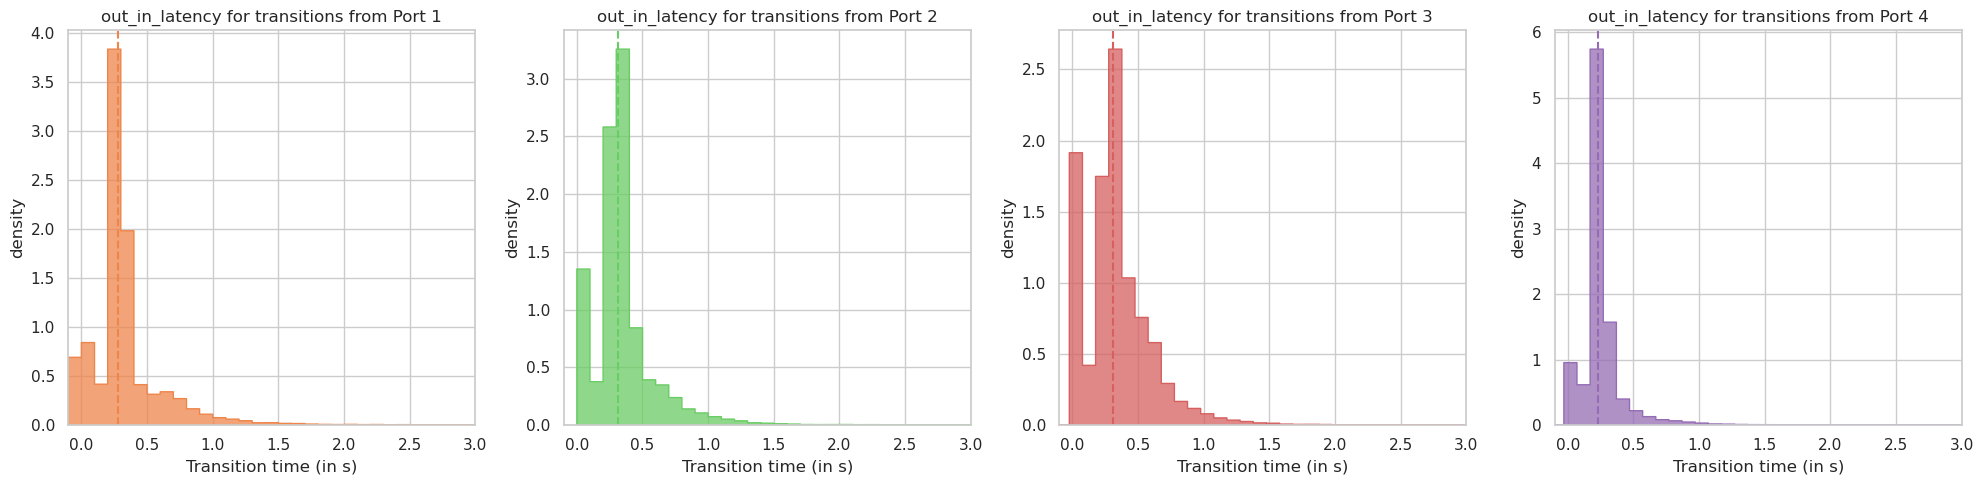

In [ ]:
fig, axes = plot_latency_distribution_subplots(filtered_control_df, 'out_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5))
plt.show()

### plot_latency_distribution_subplots for in_in_latency

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(24, 18))

plot_latency_distribution_subplots(filtered_control_df, 'in_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[0, :])
plot_latency_distribution_subplots(filtered_optostim_port_1, 'in_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[1, :])
plot_latency_distribution_subplots(filtered_optostim_port_2, 'in_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes= axs[2, :])
plot_latency_distribution_subplots(filtered_optostim_port_3, 'in_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[3, :])
plot_latency_distribution_subplots(filtered_optostim_port_4, 'in_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[4, :])

# You can hide the unused subplot with this line
# axs[1, 0].axis('off')

# Define row and column labels
row_labels = ['Non-stimulated trials', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['in_in_latency for transitions from port 1', 'in_in_latency for transitions from port 2', 'in_in_latency for transitions from port 3', 'in_in_latency for transitions from port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Latency start port IN to end port IN (in s)", fontsize=16, y = 1.05)
plt.show()

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(24, 18))

plot_latency_distribution_subplots(filtered_control_df, 'out_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[0, :])
plot_latency_distribution_subplots(filtered_optostim_port_1, 'out_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[1, :])
plot_latency_distribution_subplots(filtered_optostim_port_2, 'out_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes= axs[2, :])
plot_latency_distribution_subplots(filtered_optostim_port_3, 'out_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[3, :])
plot_latency_distribution_subplots(filtered_optostim_port_4, 'out_in_latency', x_range=(-0.1,3), binwidth = 0.1, stat = 'density', exclude_ports=[7, 4, 5, 8], fig_size=(20, 5), axes = axs[4, :])

# You can hide the unused subplot with this line
# axs[1, 0].axis('off')

# Define row and column labels
row_labels = ['Non-stimulated trials', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']
col_labels = ['out_in_latency for transitions from port 1', 'out_in_latency for transitions from port 2', 'out_in_latency for transitions from port 3', 'out_in_latency for transitions from port 4']

# Use for loop to set labels
for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=90, size='large')

for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

# Adjust spaces between subplots and around the plot
# fig.tight_layout()
fig.subplots_adjust(left=0.0) # You can adjust this value as needed

# Add main title for the figure
plt.suptitle("Latency start port OUT to end port IN (in s)", fontsize=16, y = 1.05)
plt.show()

### Plot basic transition summaries 

In [ ]:
# copy_df = trial_df.copy().reset_index()
# copy_df['2s_time_filter_out_in'].iloc[4] = 0
# copy_df['2s_time_filter_out_in']

# split trial_df into trial_df_1, trial_df_2, at rows where 2s_time_filter_out_in is False

def split_dataframe(df, column):
    """
    Splits the given DataFrame into multiple DataFrames based on the specified column.
    The DataFrame is split whenever the specified column has a False value.

    Args:
    df (pandas.DataFrame): The DataFrame to be split.
    column (str): The name of the column based on which the DataFrame will be split.

    Returns:
    list: A list containing the resulting DataFrames.
    """

    # Initialize an empty list to store the resulting DataFrames
    df_list = []

    # Initialize an empty DataFrame for the first segment
    df_segment = pd.DataFrame()

    # Iterate over the rows of the input DataFrame
    for index, row in df.iterrows():

        # If the current row in the specified column is True, 
        # add the row to the current segment
        if row[column]:
            df_segment = pd.concat([df_segment, pd.DataFrame(row).T])
        # If the current row in the specified column is False,
        # append the current segment to df_list and start a new segment
        else:
            df_list.append(df_segment)
            df_segment = pd.DataFrame()
            df_segment = pd.concat([df_segment, pd.DataFrame(row).T])

    # If the last segment is not empty, append it to df_list
    if not df_segment.empty:
        df_list.append(df_segment)

    # Return the list of DataFrames
    return df_list

# df_list = split_dataframe(copy_df, '2s_time_filter_out_in')



In [ ]:
def generate_transition_lists():
    """
    Generate lists of correct, error, and neutral transitions. 

    Correct transitions follow the sequence 2 -> 1 -> 6 -> 3 -> 7 -> 2, 
    Neutral transitions are those where the start and end ports are the same or transitions to irrelevant ports [4, 5, 8],
    Error transitions are all others.
    
    Returns:
    correct_transitions (list): List of correct transitions.
    error_transitions (list): List of error transitions.
    neutral_transitions (list): List of neutral transitions.
    """

    # Generate all possible transitions from 1-8 to 1-8
    all_transitions = [10*i + j for i in range(1, 9) for j in range(1, 9)]

    # Define the correct sequence
    correct_sequence = [2, 1, 6, 3, 7, 2]

    # Generate correct transitions based on the correct sequence
    correct_transitions = [10*correct_sequence[i] + correct_sequence[i+1] for i in range(len(correct_sequence)-1)]
    # The sequence wraps around, so manually add the last transition to complete the cycle
    correct_transitions.append(72)

    # Generate neutral transitions
    # Neutral transitions start and end at the same port
    same_port_transitions = [11*i for i in range(1, 9)]
    # Neutral transitions also include transitions to irrelevant ports (4, 5, 8)
    irrelevant_port_transitions = [10*i + j for i in [4, 5, 8] for j in range(1, 9)]
    neutral_transitions = same_port_transitions + irrelevant_port_transitions

    # Generate error transitions
    # Error transitions are all others that are not correct or neutral
    error_transitions = list(set(all_transitions) - set(correct_transitions) - set(neutral_transitions))

    return correct_transitions, error_transitions, neutral_transitions

# Call the function to get the transition lists
correct_transitions, error_transitions, neutral_transitions = generate_transition_lists()

In [ ]:
def get_transition_labels(df):
    """
    For each list in the 'transition_type' column, classify the transitions.
    Transitions are classified as 'correct', 'neutral', 'error', or based on predefined lists.
    'correct' transitions are those where transitions are in the correct_transitions list.
    'neutral' transitions are those where transitions are in the neutral_transitions list.
    'error' transitions are those where transitions are in the error_transitions list.
    transitions are those where transitions are in the repeat_transitions list.

    Args:
    df (pandas.DataFrame): The DataFrame with the transitions data.
                           The DataFrame should have 'transition_type' column containing lists of transitions.

    Returns:
    tuple: A tuple containing:
           1) A list of lists with the transition classifications.
           2) A dictionary with the counts of 'correct', 'neutral', 'error', and transitions.
    """
    
    correct_transitions = [21,16,63,37,72]
    error_transitions = [23,24,25,26,27,28,12,13,14,15,17,18,61,62,64,65,67,68,31,32,34,35,36,38]
    neutral_transitions = [11,22,33,66,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,71,73,74,75,76,77,78,81,82,83,84,85,86,87,88]

    all_labels = []
    correct_count = 0
    neutral_count = 0
    error_count = 0

    for transition_list in df['transition_type']:
        labels = []
        for transition in transition_list:
            if transition in correct_transitions:
                labels.append('correct')
                correct_count += 1
            elif transition in neutral_transitions:
                labels.append('neutral')
                neutral_count += 1
            else:
                labels.append('error')
                error_count += 1
        all_labels.append(labels)

    counts = {
        'correct': correct_count,
        'neutral': neutral_count,
        'error': error_count,        
    }

    return all_labels, counts


In [ ]:
_ , counts = get_transition_labels(filtered_control_df)
print(counts.values())
print(counts.items())

dict_values([105405, 46337, 15561])
dict_items([('correct', 105405), ('neutral', 46337), ('error', 15561)])


### plot transition types

In [ ]:
# Dataframes list
dataframes_list = [
    filtered_control_df, 
    filtered_optostim_port_1, 
    filtered_optostim_port_2, 
    filtered_optostim_port_3, 
    filtered_optostim_port_4
]

# Names for the dataframes (to be used in legend or x-axis)
df_names = [
    "Non-stimulated trials",
    "Optostim Port 1",
    "Optostim Port 2",
    "Optostim Port 3",
    "Optostim Port 4"
]

def get_counts_for_all_dfs(dfs):
    """
    Compute transition labels and counts for a list of dataframes.
    
    Args:
    dfs (list): List of dataframes to process.
    
    Returns:
    pandas.DataFrame: DataFrame containing transition counts for each dataframe in long format.
    """
    counts_list = []
    for df in dfs:
        _, count = get_transition_labels(df)
        counts_list.append(count)

    # Convert list of dictionaries to DataFrame
    counts_df = pd.DataFrame(counts_list)
    counts_df['df_name'] = df_names

    # Convert the DataFrame from wide to long format
    long_format_df = counts_df.melt(id_vars='df_name', value_vars=['correct', 'neutral', 'error'],
                                    var_name='transition_type', value_name='count')

    return long_format_df

# Get the long format DataFrame
transition_counts_long_df = get_counts_for_all_dfs(dataframes_list)

transition_counts_long_df.head()

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=transition_counts_long_df, x='df_name', y='count', hue='transition_type', ax = ax)

<Axes: xlabel='df_name', ylabel='count'>

In [ ]:
# Calculate total counts for each df_name
transition_counts_long_df['total'] = transition_counts_long_df.groupby('df_name')['count'].transform('sum')

# Calculate the percentage
transition_counts_long_df['percentage'] = (transition_counts_long_df['count'] / transition_counts_long_df['total']) * 100

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=transition_counts_long_df, x='df_name', y='percentage', hue='transition_type', ax=ax)
ax.set_ylabel("Percentage")
ax.grid(False)
ax.legend(loc='upper right')
plt.show()

### Length of sequences

In [ ]:

def get_repeat_transitions(df):

    repeat_transitions = [11, 22, 33, 44, 55, 66, 77, 88]

    all_labels = []
    repeat_count = 0
    no_repeat_count = 0

    for transition_list in df['transition_type']:
        labels = []
        for transition in transition_list:
            if transition in repeat_transitions:
                labels.append('repeat')
                repeat_count += 1
            else:
                labels.append('other_ports')
                no_repeat_count += 1
        all_labels.append(labels)

    counts = {
        'repeat': repeat_count,
        'other_ports': no_repeat_count
    }

    return all_labels, counts

In [ ]:
all_l , counts = get_repeat_transitions(filtered_control_df)
print(counts.values())
print(counts.items())

dict_values([36088, 131215])
dict_items([('repeat', 36088), ('other_ports', 131215)])


In [ ]:
# do some basic calculations
# length of the sequence

def remove_consecutive_repeats(arr):
    """
    Removes consecutive repeated elements from a numpy array.

    Parameters:
    - arr (array-like): Input array from which consecutive repeated elements need to be removed.

    Returns:
    - list: Array with consecutive repeated elements removed.
    """
    
    # Handle the case of an empty array
    if arr.size == 0:
        return []
    
    # Initialize the result list with the first element of the input array
    new_arr = [arr[0]]
    
    # Iterate over the input array starting from the second element
    for item in arr[1:]:
        # If the current item is different from the last item in the result list, append it
        if item != new_arr[-1]:
            new_arr.append(item)
    
    return new_arr

def get_lengths_of_sequences(df, column_name, remove_consecutive_repeats_flag=False):
    """
    Calculate the lengths of a specified column for each unique trial in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - column_name (str): The column whose lengths for unique trials are to be calculated.
    - remove_consecutive_repeats_flag (bool, optional): Flag to determine if consecutive repeats in the data should be removed.
        Default is False.

    Returns:
    - list: A list of lengths for each unique trial.
    """

    # Get all unique cumulative_trial_ids and sort them
    unique_trial_ids = df['cumulative_trial_id'].unique()
    unique_trial_ids.sort()

    # Create an empty list to store the lengths of column_name for each unique trial ID
    lengths = []

    # Loop through the unique_trial_ids
    for trial_id in unique_trial_ids:
        # Filter the DataFrame for the current trial_id
        trial_df = df[df['cumulative_trial_id'] == trial_id]
        data_list = trial_df[column_name].iloc[0]  # Get the list for this trial

        # If remove_consecutive_repeats_flag is True, filter out consecutive repeats
        if remove_consecutive_repeats_flag:
            filtered_data = remove_consecutive_repeats(data_list)
        else:
            filtered_data = data_list

        # Get the length of the filtered data and append it to the lengths list
        length = len(filtered_data)
        lengths.append(length)

    return lengths



In [101]:
# List of DataFrames
dataframes_list = [filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]

# Column name to analyze (e.g., 'start_poke_port')
column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Non-stimulated controls', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

def plot_mean_length(dataframes_list, column_name, data_labels, title, remove_consecutive_repeats_flag = False):
    """
    Function to plot statistics for a list of dataframes.
    
    Args:
    - dataframes_list: List of dataframes to process.
    - column_name: The column of interest in the dataframe.
    - data_labels: Labels to use in the bar plot for each dataframe.
    - title: Title for the plot.
    - remove_consecutive_repeats_flag: Flag to determine if consecutive repeats in the data should be removed.
    
    Returns:
    None
    """

    # Create a dictionary to store statistics for each DataFrame
    statistics_dict = {}

    # List to store the data samples for t-tests
    data_samples = []

    # Loop through the list of DataFrames
    for index, df in enumerate(dataframes_list):
        # Get the lengths for the current DataFrame and column_name
        lengths_list = get_lengths_of_sequences(df, column_name, remove_consecutive_repeats_flag=remove_consecutive_repeats_flag)

        # Calculate basic statistics
        stats = {
            'mean': sum(lengths_list) / len(lengths_list),
            'std': pd.Series(lengths_list).std(),
            'sem': pd.Series(lengths_list).sem()
        }

        statistics_dict[data_labels[index]] = stats

        # Append the lengths_list to data_samples for t-tests
        data_samples.append(lengths_list)

    # Perform t-tests between Control and other groups
    control_data = data_samples[0]
    t_test_results = {}
    for i, group_data in enumerate(data_samples[1:], start=1):
        t_stat, p_value = ttest_ind(control_data, group_data)
        t_test_results[data_labels[i]] = {'T-Statistic': t_stat, 'P-Value': p_value, 'Significant': p_value < 0.05}

    # Create a DataFrame from the statistics dictionary for easier plotting
    statistics_df = pd.DataFrame(statistics_dict).transpose()

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Use Set3 palette for the bar plot
    ax = sns.barplot(x=data_labels, y='mean', data=statistics_df, palette="Set3", errwidth=1.5, edgecolor='black', width=0.4)

    # Add error bars with SEM
    ax.errorbar(range(len(statistics_df)), statistics_df['mean'], yerr=statistics_df['sem'], fmt='none', c='k', capsize=5)

    ax.set_ylabel('Mean length')
    plt.xticks(rotation=30, ha='right', va='top')
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Print t-test results
    for group, result in t_test_results.items():
        print(f"T-Test: Control vs {group}")
        print(f"T-Statistic: {result['T-Statistic']}")
        print(f"P-Value: {result['P-Value']}")
        if result['Significant']:
            print("Result: Significant difference\n")
        else:
            print("Result: No significant difference\n")

# Plot for rILT opto-inhibition
plot_mean_length(dataframes_list, column_name, data_labels, title="rILT Opto-inhibition", remove_consecutive_repeats_flag=False)


NameError: name 'filtered_optostim_port_1' is not defined

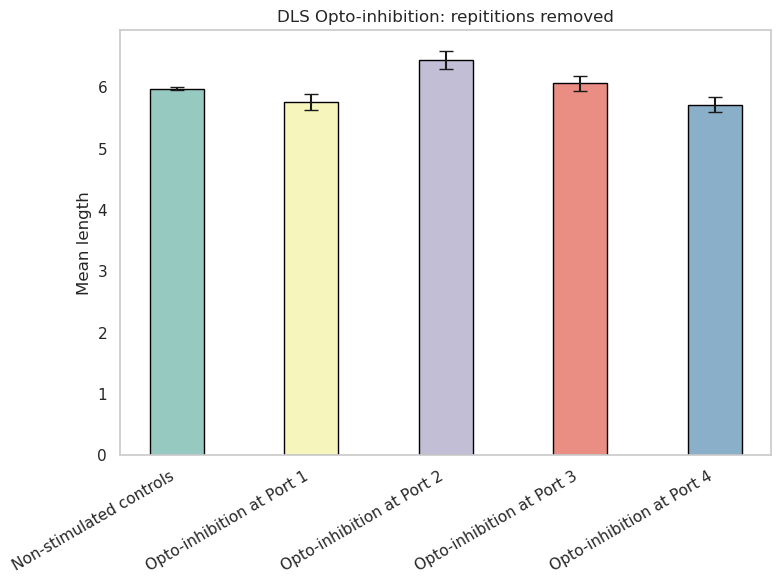

T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: 1.520441209209819
P-Value: 0.1284338983683309
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: -3.2546353681081372
P-Value: 0.0011394094553807323
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: -0.5682550021644941
P-Value: 0.5698754604235199
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 1.775560779916957
P-Value: 0.07583784154949827
Result: No significant difference



In [ ]:
# Plot for rILT opto-inhibition with repititions removed
plot_mean_length(dataframes_list, column_name, data_labels, title="rILT Opto-inhibition: repititions removed", remove_consecutive_repeats_flag=True)


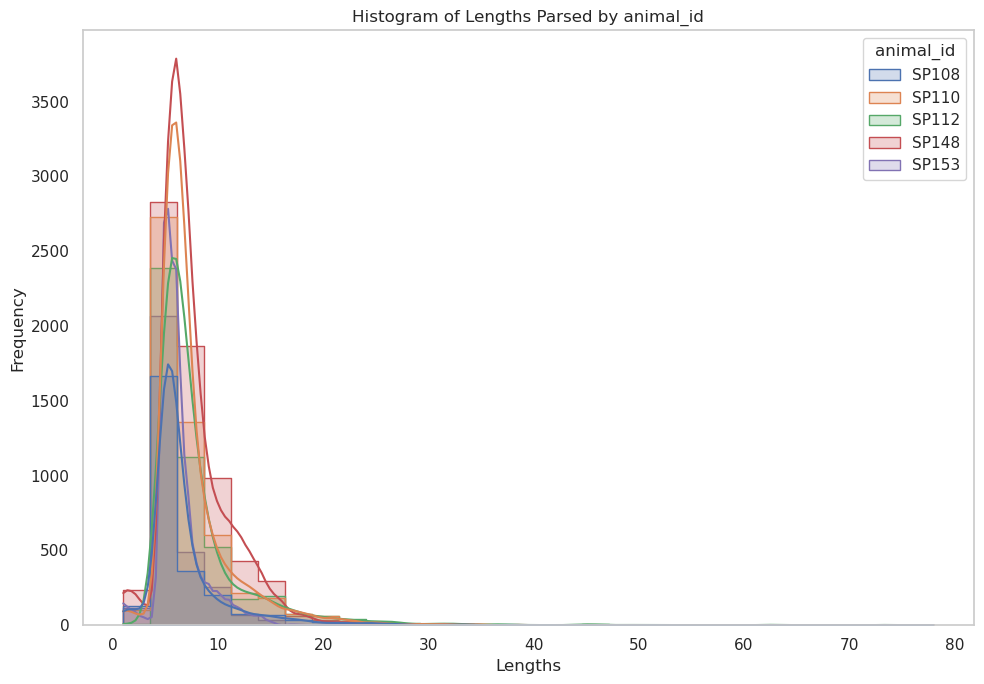

In [ ]:
# Extract lengths and animal_id columns from filtered_control_df
df_control = filtered_control_df[[column_name, 'animal_id']]
# Calculate lengths of lists in 'start_poke_port' column
df_control['lengths'] = df_control['start_poke_port'].apply(len)

# Ensure the animal_id column is treated as a string (or category)
df_control['animal_id'] = df_control['animal_id'].astype(str)

# Plot histogram parsed by animal_id
plt.figure(figsize=(10, 7))
sns.histplot(data=df_control, x='lengths', hue='animal_id', bins=30, kde=True, element='step')

# Note:
# - 'element' is set to 'step' to avoid overlapping bars. It will create step-like plots.
# - 'common_norm' is set to False to ensure each animal's distribution is not normalized by the others.

plt.xlabel('Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths Parsed by animal_id')
plt.grid(False)
plt.tight_layout()
plt.show()

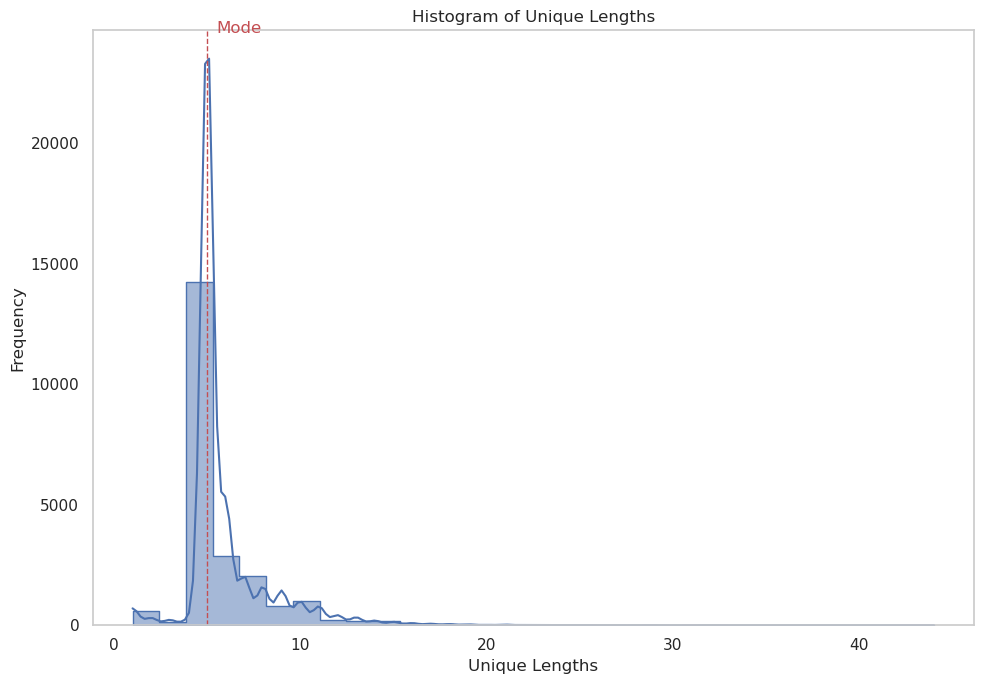

In [ ]:
# Apply the function to 'start_poke_port' column
df_control['unique_start_poke_port'] = df_control['start_poke_port'].apply(remove_consecutive_repeats)

# Calculate lengths of the transformed lists
df_control['unique_lengths'] = df_control['unique_start_poke_port'].apply(len)

# Ensure the animal_id column is treated as a string (or category)
df_control['animal_id'] = df_control['animal_id'].astype(str)

# Plot histogram parsed by animal_id using the new 'unique_lengths' column
plt.figure(figsize=(10, 7))
sns.histplot(data=df_control, x='unique_lengths', bins=30, kde=True, element='step')

# Calculate the mode and plot a vertical line
mode_value = df_control['unique_lengths'].mode().iloc[0]
plt.axvline(mode_value, color='r', linestyle='dashed', linewidth=1)

# Add a small text to indicate the mode
plt.text(mode_value+0.5, plt.ylim()[1]-100, 'Mode', color='r')

plt.xlabel('Unique Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Lengths')
plt.grid(False)
plt.tight_layout()
plt.show()

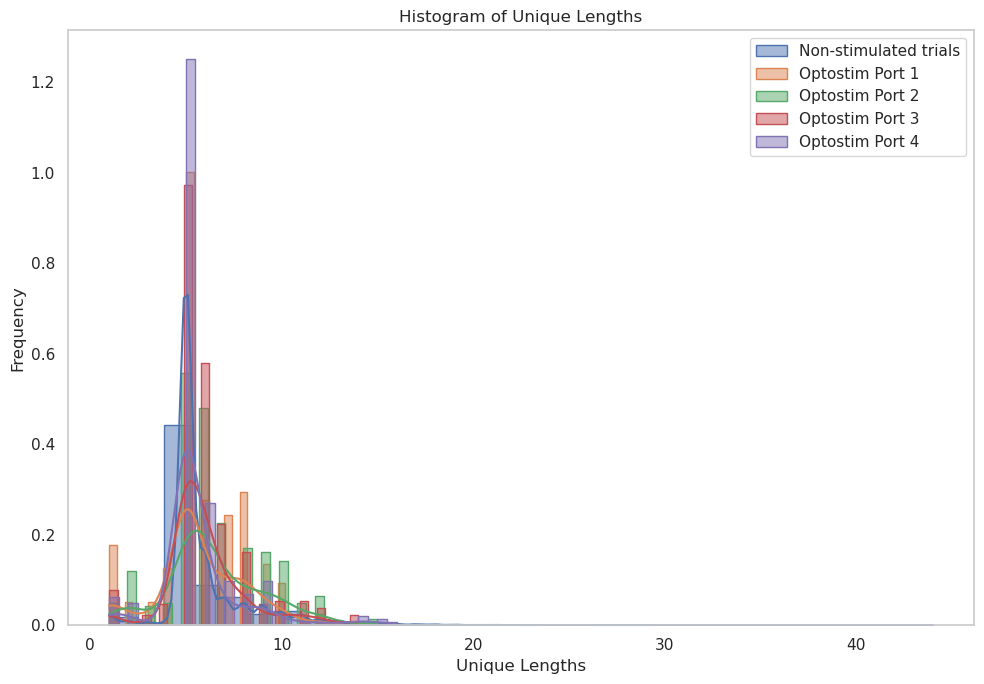

In [ ]:
# List of DataFrames
dataframes_list = [filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]
titles = ['Non-stimulated trials', 'Optostim Port 1', 'Optostim Port 2', 'Optostim Port 3', 'Optostim Port 4']


plt.figure(figsize=(10, 7))

for idx, dataframe in enumerate(dataframes_list):
    # Extract lengths and animal_id columns
    df = dataframe[[column_name, 'animal_id']]
    df['lengths'] = df['start_poke_port'].apply(len)
    df['animal_id'] = df['animal_id'].astype(str)
    df['unique_start_poke_port'] = df['start_poke_port'].apply(remove_consecutive_repeats)
    df['unique_lengths'] = df['unique_start_poke_port'].apply(len)

    # Plot histogram parsed by animal_id using the new 'unique_lengths' column
    sns.histplot(data=df, x='unique_lengths', bins=30, kde=True, element='step', stat='density',label=titles[idx])

# Configure the plot
plt.xlabel('Unique Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Lengths')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


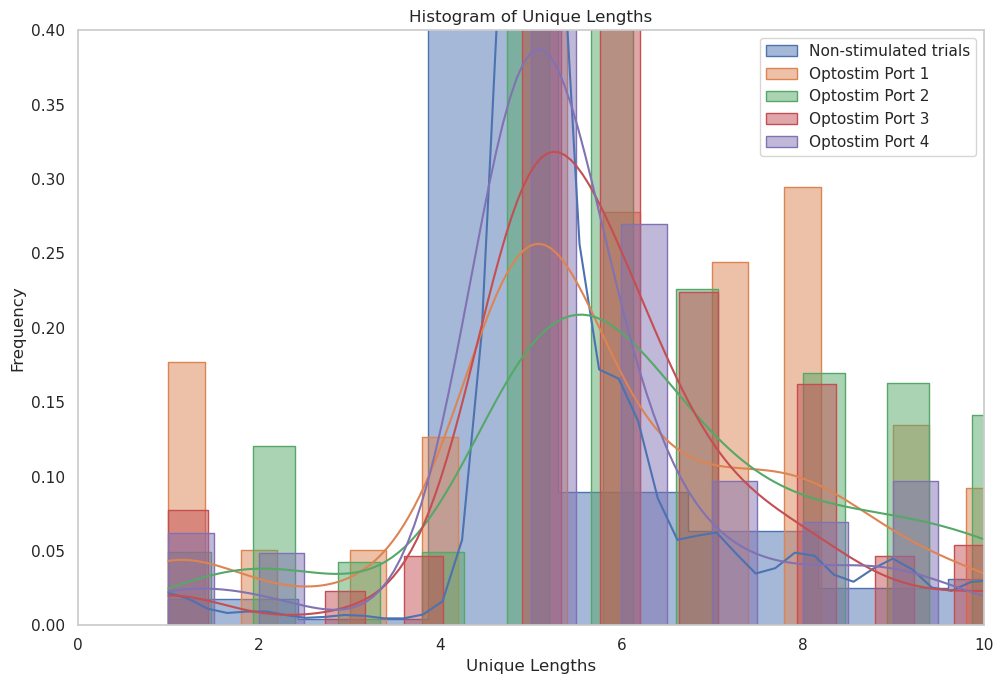

In [ ]:
plt.figure(figsize=(10, 7))

for idx, dataframe in enumerate(dataframes_list):
    # Extract lengths and animal_id columns
    df = dataframe[[column_name, 'animal_id']]
    df['lengths'] = df['start_poke_port'].apply(len)
    df['animal_id'] = df['animal_id'].astype(str)
    df['unique_start_poke_port'] = df['start_poke_port'].apply(remove_consecutive_repeats)
    df['unique_lengths'] = df['unique_start_poke_port'].apply(len)

    # Plot histogram parsed by animal_id using the new 'unique_lengths' column
    sns.histplot(data=df, x='unique_lengths', bins=30, kde=True, element='step', stat='density',label=titles[idx])

# Configure the plot
plt.xlabel('Unique Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Lengths')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.xlim(0, 10)
plt.ylim(0, 0.4)

plt.show()


In [ ]:
# create the sequence performend by the mouse in the chosen trial

perfect_sequence = '21637'
start_port = perfect_sequence[0]

def get_sequence_info(df):
    """
    This function extracts the start poke port from the dataframe and returns it as a string, 
    and the in-in latency as a list of numerical values.

    Args:
    df (pandas.DataFrame): The DataFrame with the transitions data. 
                           The DataFrame should have 'start_poke_port' and 'in_in_latency' columns.

    Returns:
    str, list: The first output is a string that contains the 'start_poke_port' values 
               and the second output is a list that contains the 'in_in_latency' numerical values.
    """
    # Convert 'start_poke_port' to string and join all elements into a single string
    start_poke_ports = ''.join(map(str, df['start_poke_port'].tolist()))

    # convert 'end_poke_port' to string and join all elements into a single string
    end_poke_ports = ''.join(map(str, df['end_poke_port'].tolist()))
    
    # Keep 'in_in_latency' as a list of floats
    in_in_latencies = df['in_in_latency'].tolist()

    # Keep 'out_in_latency' as a list of floats
    out_in_latencies = df['out_in_latency'].tolist()

    return start_poke_ports, end_poke_ports, in_in_latencies, out_in_latencies

Edit distance statistics:
Mean distance: 2.5451943289055863
Median distance: 1.0
Min distance: 0.0
Max distance: 20.0
Standard deviation of distances: 3.157735004512081


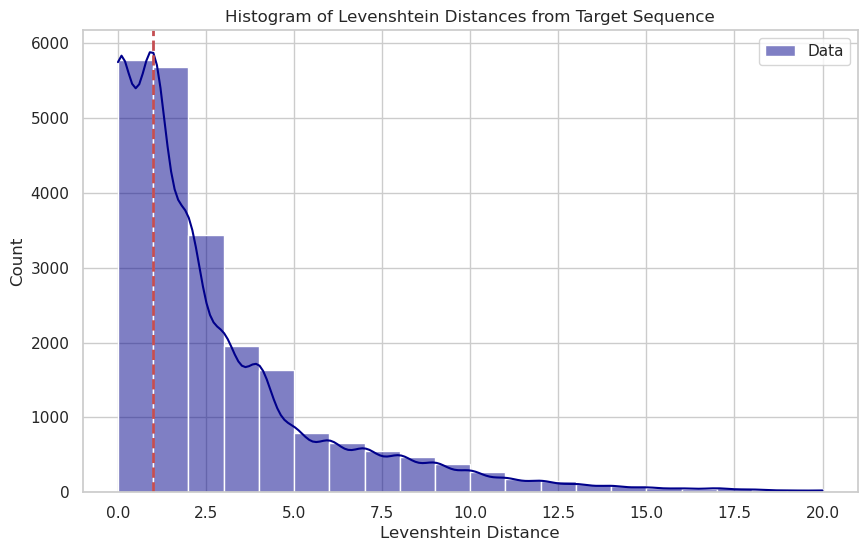

In [ ]:
def compute_levenshtein_distance(test_sequence, target_sequence='21637', start_port='2'):
    """
    Compute the Levenshtein distance between the test sequence and the target sequence.

    The Levenshtein distance is the minimum number of single-character edits 
    (insertions, deletions or substitutions) required to change one sequence into the other.

    Parameters:
    test_sequence (str): The sequence to compare against the target. 
                         This sequence should be a string representation of poke ports.
    target_sequence (str): The target sequence. This is the sequence to which we are comparing 
                           the test sequence. Default is '21637'.
    start_port (str): The poke port number at which the sequence starts, represented as a string. Default is '2'.

    Returns:
    float: The Levenshtein distance between the test sequence and the target sequence.
    """

    # Disregard anything before the first occurrence of start_port in the test sequence
    test_sequence = test_sequence[test_sequence.index(start_port):] if start_port in test_sequence else test_sequence

    size_x = len(test_sequence) + 1
    size_y = len(target_sequence) + 1
    matrix = np.zeros((size_x, size_y))

    # Initialize the first row and first column
    matrix[:, 0] = range(size_x)
    matrix[0, :] = range(size_y)

    # Compute the rest of the matrix
    for x in range(1, size_x):
        for y in range(1, size_y):
            if test_sequence[x - 1] == target_sequence[y - 1]:
                matrix[x, y] = min(
                    matrix[x - 1, y] + 1,     # Deletion
                    matrix[x - 1, y - 1],     # Substitution
                    matrix[x, y - 1] + 1      # Insertion
                )
            else:
                matrix[x, y] = min(
                    matrix[x - 1, y] + 1,     # Deletion
                    matrix[x - 1, y - 1] + 1, # Substitution
                    matrix[x, y - 1] + 1      # Insertion
                )

    # The final Levenshtein distance is the value in the bottom right corner of the matrix
    return matrix[size_x - 1, size_y - 1]

# print(compute_levenshtein_distance(start_poke_ports, perfect_sequence, start_port))bin

def get_edit_distance_statistics(df, max_edit_distance=20):
    """
    Calculate Levenshtein distances for sequences in a DataFrame and return edit distance statistics.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data for analysis.
            It should have a column 'cumulative_trial_id' representing the trial IDs.

    Returns:
        dict: A dictionary containing statistics and the distances array.
            The dictionary has the following keys:
                - 'mean_distance': The mean Levenshtein distance.
                - 'median_distance': The median Levenshtein distance.
                - 'min_distance': The minimum Levenshtein distance.
                - 'max_distance': The maximum Levenshtein distance.
                - 'std_distance': The standard deviation of Levenshtein distances.
                - 'distances_array': A numpy array containing all the Levenshtein distances.
    """
    # Group the DataFrame by 'animal_id' and 'cumulative_trial_id'
    grouped = df.groupby(['animal_id', 'cumulative_trial_id'])

    # Create a list to store all sequences
    sequences = []

    # Loop over all unique animal_id-cumulative_trial_id pairs and compute the sequences
    for (animal, trial_id), group in grouped:
        # Get the start poke ports and in_in_latencies sequences for this group
        start_poke_ports, _, _, _ = get_sequence_info(group.reset_index(drop=True))  # Define this function separately
        # Append the sequence to the list as a concatenated string
        sequences.append(''.join(str(p) for p in start_poke_ports))

    # Now we have a list of all sequences and we can compute the Levenshtein distance for all pairs of sequences
    # Create a list to store all Levenshtein distances
    distances = []

    # Loop over each sequence to compute Levenshtein distance
    for sequence in sequences:
        # Compute the Levenshtein distance between the sequence and the target_sequence (target_sequence is not defined in the code)
        distance = compute_levenshtein_distance(sequence)  # Define this function separately
        distances.append(distance)

    # Convert the list to a numpy array for easier calculations
    distance_array = np.array(distances)

    # Discard sequences with an edit distance greater than max_edit_distance
    distance_array = distance_array[distance_array <= max_edit_distance]

    # Calculate statistics
    mean_distance = np.mean(distance_array)
    median_distance = np.median(distance_array)
    min_distance = np.min(distance_array)
    max_distance = np.max(distance_array)
    std_distance = np.std(distance_array)

    # Create the result dictionary
    edit_statistics = {
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'min_distance': min_distance,
        'max_distance': max_distance,
        'std_distance': std_distance,
        'distances_array': distance_array
    }

    return edit_statistics


optostim_port_1 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 1]
optostim_port_2 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 2]
optostim_port_3 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 3]
optostim_port_4 = opto_df_1_5[opto_df_1_5['opto_stimulated_port'] == 4]

edit_statistics = get_edit_distance_statistics(control_df)

# Print the statistics for the DataFrame
print("Edit distance statistics:")
print(f"Mean distance: {edit_statistics['mean_distance']}")
print(f"Median distance: {edit_statistics['median_distance']}")
print(f"Min distance: {edit_statistics['min_distance']}")
print(f"Max distance: {edit_statistics['max_distance']}")
print(f"Standard deviation of distances: {edit_statistics['std_distance']}")

# Now, plot the histogram of distances
plt.figure(figsize=(10, 6))
sns.histplot(edit_statistics['distances_array'], bins=20, kde=True, color='darkblue', label='Data', binwidth=1)

# Plot the median as a vertical line in red
median_distance = edit_statistics['median_distance']
plt.axvline(median_distance, color='r', linestyle='dashed', linewidth=2)

plt.title("Histogram of Levenshtein Distances from Target Sequence")
plt.xlabel("Levenshtein Distance")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
def plot_edit_distance_histograms(edit_statistics_list, labels, control_bins=50, other_bins=5, plot_type='peak_density'):
    """
    Plot histograms of Levenshtein distances for multiple DataFrames.

    Parameters:
        edit_statistics_list (list): A list of edit distance statistics dictionaries for each DataFrame.
            Each dictionary should contain 'distances_array' key.
        labels (list): A list of labels for each DataFrame (e.g., ['Port 1', 'Port 2', ...]).
        control_bins (int): Number of bins for the 'control' DataFrame.
        other_bins (int): Number of bins for other DataFrames.
        plot_type (str): Either 'peak_density' or 'median' to determine what to plot.
    """
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set1", n_colors=len(edit_statistics_list))

    for idx, stats in enumerate(edit_statistics_list):
        distances_array = stats['distances_array']
        if labels[idx] == 'control':
            bins = control_bins
        else:
            bins = other_bins
        sns.kdeplot(data=distances_array, color=colors[idx], label=labels[idx])
        
        if plot_type == 'peak_density':
            # Create a Gaussian kernel density estimate
            kde = gaussian_kde(distances_array)

            # Generate points for the x axis
            x_points = np.linspace(distances_array.min(), distances_array.max(), 500)

            # Evaluate the KDE on these points
            densities = kde.evaluate(x_points)

            # Find the x value that corresponds to the peak of the density
            peak_density_x = x_points[np.argmax(densities)]

            # Plot a vertical line at the peak
            plt.axvline(peak_density_x, color=colors[idx], linestyle='--', alpha=0.5)
        elif plot_type == 'median':
            median_val = np.median(distances_array)
            plt.axvline(median_val, color=colors[idx], linestyle='--', alpha=0.5)
     
    plt.title("Histogram of Levenshtein Distances from Target Sequence")
    plt.xlabel("Levenshtein Distance")
    plt.ylabel("Density")
    plt.legend()
    sns.despine()
    plt.gca().set_aspect('auto')

    # Find the first 99 percentile of the data and set xlim accordingly
    percentile_99 = np.percentile(np.concatenate([stats['distances_array'] for stats in edit_statistics_list]), 99)
    plt.xlim(0, percentile_99)

    # Switch off the grid
    plt.grid(False)
    

    plt.show()


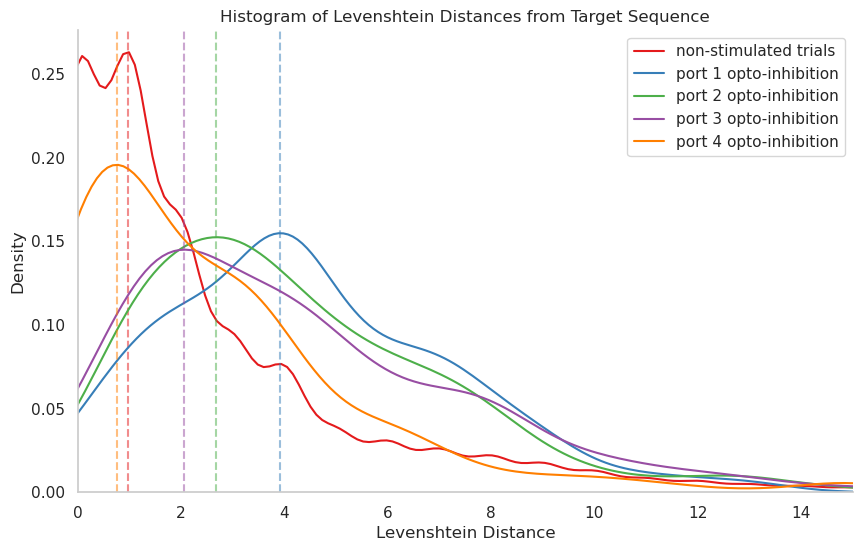

In [ ]:
# Calculate edit statistics for each DataFrame
edit_statistics_control = get_edit_distance_statistics(control_df)
edit_statistics_port_1_opto = get_edit_distance_statistics(optostim_port_1)
edit_statistics_port_2_opto = get_edit_distance_statistics(optostim_port_2)
edit_statistics_port_3_opto = get_edit_distance_statistics(optostim_port_3)
edit_statistics_port_4_opto = get_edit_distance_statistics(optostim_port_4)

# Create a list of edit statistics and port labels
edit_statistics_list = [edit_statistics_control, edit_statistics_port_1_opto, edit_statistics_port_2_opto, edit_statistics_port_3_opto, edit_statistics_port_4_opto]
labels = ['non-stimulated trials', 'port 1 opto-inhibition', 'port 2 opto-inhibition', 'port 3 opto-inhibition', 'port 4 opto-inhibition']

# Plot the histograms for all DataFrames in the same plot
plot_edit_distance_histograms(edit_statistics_list, labels, control_bins=50, other_bins=5, plot_type='peak_density')



In [ ]:
def plot_cdfs_and_perform_ks(edit_statistics_list, labels):
    """
    Plot CDFs of Levenshtein distances for multiple DataFrames and perform KS test between each pair of DataFrames.

    Parameters:
        edit_statistics_list (list): A list of edit distance statistics dictionaries for each DataFrame.
            Each dictionary should contain 'distances_array' key.
        labels (list): A list of labels for each DataFrame (e.g., ['Port 1', 'Port 2', ...]).
    """
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set1", n_colors=len(edit_statistics_list))

    for idx, stats in enumerate(edit_statistics_list):
        distances_array = stats['distances_array']
        ecdf = ECDF(distances_array) # Calculate ECDF
        plt.plot(ecdf.x, ecdf.y, color=colors[idx], label=labels[idx])

    plt.title("Cumulative Distribution Function of Levenshtein Distances")
    plt.xlabel("Levenshtein Distance")
    plt.ylabel("CDF")
    plt.legend()
    sns.despine()
    plt.gca().set_aspect('auto')
    plt.show()

    # Perform KS test between each pair of dataframes and print the results
    for i in range(len(edit_statistics_list)):
        for j in range(i + 1, len(edit_statistics_list)):
            ks_stat, p_value = ks_2samp(edit_statistics_list[i]['distances_array'], 
                                        edit_statistics_list[j]['distances_array'])
            print(f"K-S statistic between {labels[i]} and {labels[j]}: {ks_stat:.2f}")
            print(f"P-value: {p_value:.2f}")

# Calculate edit statistics for each DataFrametrial_df = control_df[control_df['cumulative_trial_id'] == cumulative_trial_ids[0]].reset_index(drop=True)
# trial_df.head()
edit_statistics_control = get_edit_distance_statistics(control_df)
edit_statistics_port_1_opto = get_edit_distance_statistics(optostim_port_1)
edit_statistics_port_2_opto = get_edit_distance_statistics(optostim_port_2)
edit_statistics_port_3_opto = get_edit_distance_statistics(optostim_port_3)
edit_statistics_port_4_opto = get_edit_distance_statistics(optostim_port_4)

# Create a list of edit statistics and port labels
edit_statistics_list = [edit_statistics_control, edit_statistics_port_1_opto, edit_statistics_port_2_opto, edit_statistics_port_3_opto, edit_statistics_port_4_opto]
labels = ['non-stimulated trials', 'port 1 opto-inhibition', 'port 2 opto-inhibition', 'port 3 opto-inhibition', 'port 4 opto-inhibition']

# Plot the CDFs for all DataFrames and perform KS tests
plot_cdfs_and_perform_ks(edit_statistics_list, labels)


K-S statistic between non-stimulated trials and port 1 opto-inhibition: 0.40
P-value: 0.00
K-S statistic between non-stimulated trials and port 2 opto-inhibition: 0.35
P-value: 0.00
K-S statistic between non-stimulated trials and port 3 opto-inhibition: 0.33
P-value: 0.00
K-S statistic between non-stimulated trials and port 4 opto-inhibition: 0.09
P-value: 0.01
K-S statistic between port 1 opto-inhibition and port 2 opto-inhibition: 0.12
P-value: 0.02
K-S statistic between port 1 opto-inhibition and port 3 opto-inhibition: 0.11
P-value: 0.04
K-S statistic between port 1 opto-inhibition and port 4 opto-inhibition: 0.37
P-value: 0.00
K-S statistic between port 2 opto-inhibition and port 3 opto-inhibition: 0.05
P-value: 0.73
K-S statistic between port 2 opto-inhibition and port 4 opto-inhibition: 0.31
P-value: 0.00
K-S statistic between port 3 opto-inhibition and port 4 opto-inhibition: 0.29
P-value: 0.00


### calculate truncations and restarts in sequences

In [ ]:
# calculate performance percent of trials containing the perfect sequence
# filter by only perfect trials

def filter_by_perfect_trials(df, col_name):
    perfect_sequence = [2, 1, 6, 3, 7]
    
    # This list will store the indices of the rows that match the criteria
    valid_rows = []

    # Iterate over each row
    for index, row in df.iterrows():
        list_of_integers = row[col_name]
        
        # Convert integer to a list if it's an integer
        if isinstance(list_of_integers, int):
            list_of_integers = [list_of_integers]
        
        # Convert numpy.ndarray to a list
        if isinstance(list_of_integers, np.ndarray):
            list_of_integers = list(list_of_integers)

        temp_idx = 0  # Keep track of current index in list_of_integers

        # Check if each number in perfect_sequence exists in the right order in list_of_integers
        for num in perfect_sequence:
            if num in list_of_integers[temp_idx:]:
                # Get the index of the next occurrence of the number in the sequence
                next_idx = list_of_integers.index(num, temp_idx)
                
                # Check if all the numbers between temp_idx and next_idx are the same
                if all(x == num for x in list_of_integers[temp_idx:next_idx]):
                    temp_idx = next_idx + 1
                else:
                    break
            else:
                break
        else:  # The else part of for loop executes only if the loop completed without a break
            valid_rows.append(index)
    
    # Filter dataframe using the indices of valid rows
    return df.loc[valid_rows]


perfect_trials_control = filter_by_perfect_trials(filtered_control_df, 'start_poke_port')
perfect_trials_opto_1 = filter_by_perfect_trials(filtered_optostim_port_1, 'start_poke_port')
perfect_trials_opto_2 = filter_by_perfect_trials(filtered_optostim_port_2, 'start_poke_port')
perfect_trials_opto_3 = filter_by_perfect_trials(filtered_optostim_port_3, 'start_poke_port')
perfect_trials_opto_4 = filter_by_perfect_trials(filtered_optostim_port_4, 'start_poke_port')


# perfect_trials_control.head()
# print the count and percent of trials containing the perfect sequence

print("Non-stimulated trials:")
print(f"Number of trials: {len(filtered_control_df)}")
print(f"Number of trials containing the perfect sequence: {len(perfect_trials_control)}")
print(f"Percentage of trials containing the perfect sequence: {len(perfect_trials_control) / len(filtered_control_df) * 100:.2f}%")

print("\nPort 1 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_1)}")
print(f"Number of trials containing the perfect sequence: {len(perfect_trials_opto_1)}")
print(f"Percentage of trials containing the perfect sequence: {len(perfect_trials_opto_1) / len(filtered_optostim_port_1) * 100:.2f}%")

print("\nPort 2 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_2)}")
print(f"Number of trials containing the perfect sequence: {len(perfect_trials_opto_2)}")
print(f"Percentage of trials containing the perfect sequence: {len(perfect_trials_opto_2) / len(filtered_optostim_port_2) * 100:.2f}%")

print("\nPort 3 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_3)}")
print(f"Number of trials containing the perfect sequence: {len(perfect_trials_opto_3)}")
print(f"Percentage of trials containing the perfect sequence: {len(perfect_trials_opto_3) / len(filtered_optostim_port_3) * 100:.2f}%")

print("\nPort 4 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_4)}")
print(f"Number of trials containing the perfect sequence: {len(perfect_trials_opto_4)}")
print(f"Percentage of trials containing the perfect sequence: {len(perfect_trials_opto_4) / len(filtered_optostim_port_4) * 100:.2f}%")


Non-stimulated trials:
Number of trials: 22477
Number of trials containing the perfect sequence: 5817
Percentage of trials containing the perfect sequence: 25.88%

Port 1 opto-inhibition:
Number of trials: 297
Number of trials containing the perfect sequence: 13
Percentage of trials containing the perfect sequence: 4.38%

Port 2 opto-inhibition:
Number of trials: 303
Number of trials containing the perfect sequence: 9
Percentage of trials containing the perfect sequence: 2.97%

Port 3 opto-inhibition:
Number of trials: 299
Number of trials containing the perfect sequence: 12
Percentage of trials containing the perfect sequence: 4.01%

Port 4 opto-inhibition:
Number of trials: 289
Number of trials containing the perfect sequence: 68
Percentage of trials containing the perfect sequence: 23.53%


In [ ]:
def perfect_sequence_summary(original_df, perfect_trials_df):
    percentages = []
    for animal_id in original_df['animal_id'].unique():
        total_trials = len(original_df[original_df['animal_id'] == animal_id])
        perfect_trials = len(perfect_trials_df[perfect_trials_df['animal_id'] == animal_id])
        percentages.append((animal_id, perfect_trials / total_trials * 100))
    return percentages

categories = [
    ('Non-stimulated trials', filtered_control_df, perfect_trials_control),
    ('Port 1 opto-inhibition', filtered_optostim_port_1, perfect_trials_opto_1),
    ('Port 2 opto-inhibition', filtered_optostim_port_2, perfect_trials_opto_2),
    ('Port 3 opto-inhibition', filtered_optostim_port_3, perfect_trials_opto_3),
    ('Port 4 opto-inhibition', filtered_optostim_port_4, perfect_trials_opto_4)
]

data = []
for category, original_df, perfect_trials_df in categories:
    for animal_id, percent in perfect_sequence_summary(original_df, perfect_trials_df):
        data.append((category, percent, animal_id))

# Create dataframe
df_percent_animals = pd.DataFrame(data, columns=['Category', 'Percentage', 'Animal_ID'])

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Percentage', data=df_percent_animals, palette="Set3", width=0.5)
plt.title('Percentage of Trials Containing the Perfect Sequence')
plt.ylabel('Percentage (%) perfect trials')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:

# def get_performance_percent

def filter_by_correct_trials(df, col_name):
    perfect_sequence = [2, 1, 6, 3, 7]
    
    # This list will store the indices of the rows that match the criteria
    valid_rows = []

    # Iterate over each row
    for index, row in df.iterrows():
        list_of_integers = row[col_name]
        
        # Convert integer to a list if it's an integer
        if isinstance(list_of_integers, int):
            list_of_integers = [list_of_integers]
        
        # Convert numpy.ndarray to a list
        if isinstance(list_of_integers, np.ndarray):
            list_of_integers = list(list_of_integers)

        temp_idx = 0  # Keep track of current index in list_of_integers

        # Check if each number in perfect_sequence exists in the right order in list_of_integers
        for num in perfect_sequence:
            if num in list_of_integers[temp_idx:]:
                temp_idx = list_of_integers.index(num, temp_idx) + 1
            else:
                break
        else:  # The else part of for loop executes only if the loop completed without a break
            valid_rows.append(index)
    
    # Filter correct and incorrect dataframes using the indices of valid rows and return them
    return df.loc[valid_rows], df.loc[~df.index.isin(valid_rows)]


correct_trials_controls, incorrect_trials_controls = filter_by_correct_trials(filtered_control_df, 'start_poke_port')
correct_trials_opto_1, incorrect_trials_opto_1 = filter_by_correct_trials(filtered_optostim_port_1, 'start_poke_port')
correct_trials_opto_2, incorrect_trials_opto_2 = filter_by_correct_trials(filtered_optostim_port_2, 'start_poke_port')
correct_trials_opto_3, incorrect_trials_opto_3 = filter_by_correct_trials(filtered_optostim_port_3, 'start_poke_port')
correct_trials_opto_4, incorrect_trials_opto_4 = filter_by_correct_trials(filtered_optostim_port_4, 'start_poke_port')

# print the count and percent of trials containing the perfect sequence

print("Non-stimulated trials:")
print(f"Number of trials: {len(filtered_control_df)}")
print(f"Number of correct trials: {len(correct_trials_controls)}")
print(f"Number of incorrect trials: {len(incorrect_trials_controls)}")
print(f"Percentage of correct trials: {len(correct_trials_controls) / len(filtered_control_df) * 100:.2f}%")
print(f"Percentage of incorrect trials: {len(incorrect_trials_controls) / len(filtered_control_df) * 100:.2f}%")

print("\nPort 1 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_1)}")
print(f"Number of correct trials: {len(correct_trials_opto_1)}")
print(f"Number of incorrect trials: {len(incorrect_trials_opto_1)}")
print(f"Percentage of correct trials: {len(correct_trials_opto_1) / len(filtered_optostim_port_1) * 100:.2f}%")
print(f"Percentage of incorrect trials: {len(incorrect_trials_opto_1) / len(filtered_optostim_port_1) * 100:.2f}%")

print("\nPort 2 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_2)}")
print(f"Number of correct trials: {len(correct_trials_opto_2)}")
print(f"Number of incorrect trials: {len(incorrect_trials_opto_2)}")
print(f"Percentage of correct trials: {len(correct_trials_opto_2) / len(filtered_optostim_port_2) * 100:.2f}%")
print(f"Percentage of incorrect trials: {len(incorrect_trials_opto_2) / len(filtered_optostim_port_2) * 100:.2f}%")

print("\nPort 3 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_3)}")
print(f"Number of correct trials: {len(correct_trials_opto_3)}")
print(f"Number of incorrect trials: {len(incorrect_trials_opto_3)}")
print(f"Percentage of correct trials: {len(correct_trials_opto_3) / len(filtered_optostim_port_3) * 100:.2f}%")
print(f"Percentage of incorrect trials: {len(incorrect_trials_opto_3) / len(filtered_optostim_port_3) * 100:.2f}%")

print("\nPort 4 opto-inhibition:")
print(f"Number of trials: {len(filtered_optostim_port_4)}")
print(f"Number of correct trials: {len(correct_trials_opto_4)}")
print(f"Number of incorrect trials: {len(incorrect_trials_opto_4)}")
print(f"Percentage of correct trials: {len(correct_trials_opto_4) / len(filtered_optostim_port_4) * 100:.2f}%")
print(f"Percentage of incorrect trials: {len(incorrect_trials_opto_4) / len(filtered_optostim_port_4) * 100:.2f}%")



Non-stimulated trials:
Number of trials: 22477
Number of correct trials: 20914
Number of incorrect trials: 1563
Percentage of correct trials: 93.05%
Percentage of incorrect trials: 6.95%

Port 1 opto-inhibition:
Number of trials: 297
Number of correct trials: 184
Number of incorrect trials: 113
Percentage of correct trials: 61.95%
Percentage of incorrect trials: 38.05%

Port 2 opto-inhibition:
Number of trials: 303
Number of correct trials: 216
Number of incorrect trials: 87
Percentage of correct trials: 71.29%
Percentage of incorrect trials: 28.71%

Port 3 opto-inhibition:
Number of trials: 299
Number of correct trials: 266
Number of incorrect trials: 33
Percentage of correct trials: 88.96%
Percentage of incorrect trials: 11.04%

Port 4 opto-inhibition:
Number of trials: 289
Number of correct trials: 262
Number of incorrect trials: 27
Percentage of correct trials: 90.66%
Percentage of incorrect trials: 9.34%


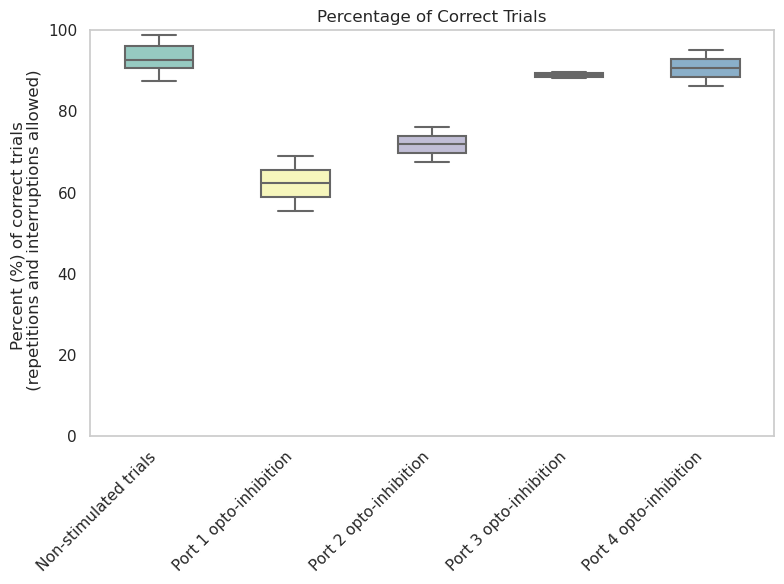

In [ ]:
# plot the percent of correct trials
def correct_percent_per_animal(original_df, correct_trials_df):
    percentages = []
    for animal_id in original_df['animal_id'].unique():
        total_trials = len(original_df[original_df['animal_id'] == animal_id])
        num_correct_trials = len(correct_trials_df[correct_trials_df['animal_id'] == animal_id])
        percentages.append((animal_id, num_correct_trials / total_trials * 100))
    return percentages

categories = [
    ('Non-stimulated trials', filtered_control_df, correct_trials_controls),
    ('Port 1 opto-inhibition', filtered_optostim_port_1, correct_trials_opto_1),
    ('Port 2 opto-inhibition', filtered_optostim_port_2, correct_trials_opto_2),
    ('Port 3 opto-inhibition', filtered_optostim_port_3, correct_trials_opto_3),
    ('Port 4 opto-inhibition', filtered_optostim_port_4, correct_trials_opto_4)
]

data = []
for category, original_df, correct_trials_df in categories:
    for animal_id, percent in correct_percent_per_animal(original_df, correct_trials_df):
        data.append((category, percent, animal_id))

# Create dataframe
df_correct_percent_animals = pd.DataFrame(data, columns=['Category', 'Percentage', 'Animal_ID'])

# Plotting
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Percentage', data=df_correct_percent_animals, palette="Set3", width=0.5)
plt.title('Percentage of Correct Trials')
plt.ylabel('Percent (%) of correct trials \n (repetitions and interruptions allowed)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
def categorize_sequence_structure(df, col_name):
    perfect_sequence = [2, 1, 6, 3, 7]
    analysis_df = pd.DataFrame(columns=['perfect_sequence_exists', 'repetition_exists', 'jumbled_integers_exist', 'incorrect_sequences'])

    for _, row in df.iterrows():
        list_of_integers = row[col_name]
        
        # Convert numpy.ndarray to a list
        if isinstance(list_of_integers, np.ndarray):
            list_of_integers = list(list_of_integers)
            
        temp_seq = list_of_integers[:]
        
        # Find if perfect_sequence exists in the right order, but not consecutively
        perfect_sequence_exists = all(x in temp_seq for x in perfect_sequence)
        
        for x in perfect_sequence:
            if x in temp_seq:
                idx = temp_seq.index(x)
                temp_seq = temp_seq[idx+1:]

        jumbled_exists = False
        if perfect_sequence_exists:
            repetition_exists = any(list_of_integers.count(seq_elem) > 1 for seq_elem in perfect_sequence)
            
            # Get indices of perfect_sequence in list_of_integers
            indices = []
            temp_list = list_of_integers.copy()
            for num in perfect_sequence:
                if num in temp_list:
                    indices.append(temp_list.index(num))
                    temp_list[indices[-1]] = None  # Ensure we don't get the same index next time if there's a repetition
            
            # Check for jumbled sequence
            for i in range(1, len(indices)):
                if indices[i] <= indices[i-1]:
                    jumbled_exists = True
                    break
                
                # Check for jumbled sequence between two indices
                intervening_sequence = list_of_integers[indices[i-1]+1:indices[i]]
                for num in intervening_sequence:
                    if num in perfect_sequence and perfect_sequence.index(num) < i:
                        jumbled_exists = True
                        break
                
                if jumbled_exists:
                    break
            
            incorrect = False
        else:
            repetition_exists = False
            incorrect = True

        analysis_df.loc[_] = [perfect_sequence_exists, repetition_exists, jumbled_exists, incorrect]

    return analysis_df


def print_summary(analysis_df):
    total_trials = len(analysis_df)
    
    perfect_count = analysis_df['perfect_sequence_exists'].sum()
    repetition_count = analysis_df['repetition_exists'].sum()
    jumbled_count = analysis_df['jumbled_integers_exist'].sum()
    incorrect = analysis_df['incorrect_sequences'].sum()
    
    print(f"Perfect sequence exists: {perfect_count} ({perfect_count/total_trials*100:.2f}%)")
    print(f"Repetition exists: {repetition_count} ({repetition_count/total_trials*100:.2f}%)")
    print(f"Jumbled sequence exists: {jumbled_count} ({jumbled_count/total_trials*100:.2f}%)\n")
    print(f"incorrect: {incorrect} ({incorrect/total_trials*100:.2f}%)\n")

# Sample usage
print("Non-stimulated trials:")
print_summary(categorize_sequence_structure(filtered_control_df, 'start_poke_port'))

# Assuming the other dataframes are named correctly
print("Opto 1:")
print_summary(categorize_sequence_structure(filtered_optostim_port_1, 'start_poke_port'))

print("Opto 2:")
print_summary(categorize_sequence_structure(filtered_optostim_port_2, 'start_poke_port'))

print("Opto 3:")
print_summary(categorize_sequence_structure(filtered_optostim_port_3, 'start_poke_port'))

print("Opto 4:")
print_summary(categorize_sequence_structure(filtered_optostim_port_4, 'start_poke_port'))


Non-stimulated trials:
Perfect sequence exists: 21073 (93.75%)
Repetition exists: 15295 (68.05%)
Jumbled sequence exists: 15253 (67.86%)

incorrect: 1404 (6.25%)

Opto 1:
Perfect sequence exists: 193 (64.98%)
Repetition exists: 180 (60.61%)
Jumbled sequence exists: 180 (60.61%)

incorrect: 104 (35.02%)

Opto 2:
Perfect sequence exists: 230 (75.91%)
Repetition exists: 221 (72.94%)
Jumbled sequence exists: 221 (72.94%)

incorrect: 73 (24.09%)

Opto 3:
Perfect sequence exists: 267 (89.30%)
Repetition exists: 255 (85.28%)
Jumbled sequence exists: 255 (85.28%)

incorrect: 32 (10.70%)

Opto 4:
Perfect sequence exists: 264 (91.35%)
Repetition exists: 197 (68.17%)
Jumbled sequence exists: 196 (67.82%)

incorrect: 25 (8.65%)



In [ ]:
def analyze_truncated_sequences(df, col_name):
    """
    Analyze elements of a Pandas DataFrame column which are lists of integers 
    and determine if the sequence is truncated at a particular number of the perfect sequence [2, 1, 6, 3, 7].
    
    Args:
    df: A Pandas DataFrame.
    col_name: The name of the column in the DataFrame which contains the lists of integers.
    
    Returns:
    A Pandas DataFrame with the count, percentage, and truncation probability of sequences truncated at each number.
    """
    
    perfect_sequence = [2, 1, 6, 3, 7]
    
    # Dictionary to store count of sequences truncated at each number
    truncation_counts = {num: 0 for num in perfect_sequence}
    
    total_sequences = len(df)
    
    for _, row in df.iterrows():
        list_of_integers = row[col_name]
        
        # Convert numpy.ndarray to a list
        if isinstance(list_of_integers, np.ndarray):
            list_of_integers = list(list_of_integers)
        
        # Track the last matched element of the perfect sequence
        last_matched = None
        temp_seq = list_of_integers[:]
        for x in perfect_sequence:
            if x in temp_seq:
                last_matched = x
                idx = temp_seq.index(x)
                temp_seq = temp_seq[idx+1:]
            else:
                break
        
        # For sequences ending in 7 after the perfect sequence, we won't consider them truncated
        if last_matched == 7 and set(list_of_integers).issuperset(perfect_sequence):
            continue
        
        # Increment truncation count if sequence was truncated
        if last_matched is not None and last_matched != perfect_sequence[-1]:
            truncation_counts[last_matched] += 1
    
    # Convert the truncation counts to a DataFrame and compute percentage and truncation probability
    truncation_df = pd.DataFrame(list(truncation_counts.items()), columns=["Truncated_At", "Count"])
    truncation_df['Percentage'] = (truncation_df['Count'] / total_sequences) * 100
    truncation_df['Truncation_Probability'] = (truncation_df['Count'] / total_sequences) 
    
    return truncation_df




# Sample usage
truncation_analysis_df = analyze_truncated_sequences(filtered_control_df, 'start_poke_port')
print(truncation_analysis_df)

trunc_opto_1 = analyze_truncated_sequences(filtered_optostim_port_1, 'start_poke_port')
print(trunc_opto_1)

trunc_opto_2 = analyze_truncated_sequences(filtered_optostim_port_2, 'start_poke_port')
print(trunc_opto_2)

trunc_opto_3 = analyze_truncated_sequences(filtered_optostim_port_3, 'start_poke_port')
print(trunc_opto_3)

trunc_opto_4 = analyze_truncated_sequences(filtered_optostim_port_4, 'start_poke_port')
print(trunc_opto_4)


   Truncated_At  Count  Percentage  Truncation_Probability
0             2   1048    4.662544                0.046625
1             1    327    1.454820                0.014548
2             6    151    0.671798                0.006718
3             3     37    0.164613                0.001646
4             7      0    0.000000                0.000000
   Truncated_At  Count  Percentage  Truncation_Probability
0             2     90   30.303030                0.303030
1             1     21    7.070707                0.070707
2             6      2    0.673401                0.006734
3             3      0    0.000000                0.000000
4             7      0    0.000000                0.000000
   Truncated_At  Count  Percentage  Truncation_Probability
0             2     17    5.610561                0.056106
1             1     56   18.481848                0.184818
2             6     13    4.290429                0.042904
3             3      1    0.330033                0.0033

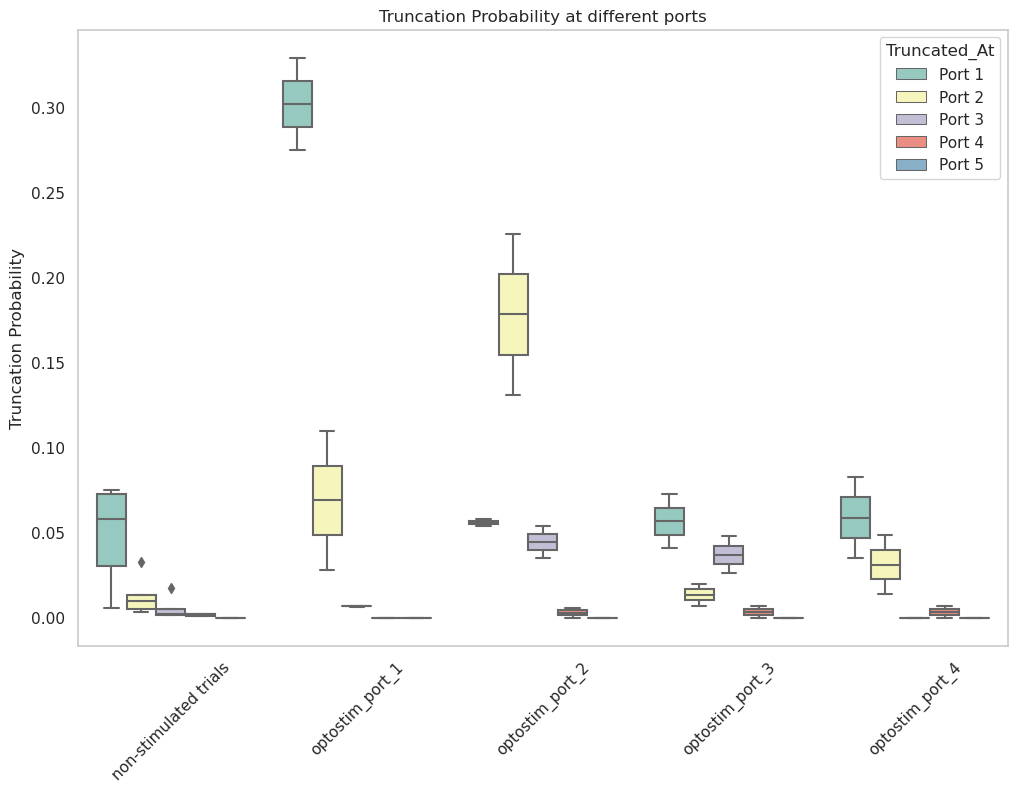

In [ ]:
port_mapping = {2: 'Port 1', 1: 'Port 2', 6: 'Port 3', 3: 'Port 4', 7: 'Port 5'}

def analyze_truncated_sequences_by_animal(df, col_name):
    perfect_sequence = [2, 1, 6, 3, 7]
    
    results = []
    
    for animal_id, group in df.groupby('animal_id'):
        truncation_counts = {num: 0 for num in perfect_sequence}
        total_sequences = len(group)
        
        for _, row in group.iterrows():
            list_of_integers = row[col_name]
            
            # Convert numpy.ndarray to a list
            if isinstance(list_of_integers, np.ndarray):
                list_of_integers = list(list_of_integers)
            
            last_matched = None
            temp_seq = list_of_integers[:]
            for x in perfect_sequence:
                if x in temp_seq:
                    last_matched = x
                    idx = temp_seq.index(x)
                    temp_seq = temp_seq[idx+1:]
                else:
                    break
            
            if last_matched == 7 and set(list_of_integers).issuperset(perfect_sequence):
                continue
            
            if last_matched is not None and last_matched != perfect_sequence[-1]:
                truncation_counts[last_matched] += 1
        
        for num, count in truncation_counts.items():
            percentage = (count / total_sequences) * 100
            truncation_probability = (count / total_sequences) 
            results.append([animal_id, num, percentage, truncation_probability])
    
    truncation_df = pd.DataFrame(results, columns=["animal_id", "Truncated_At", "Percentage", "Truncation_Probability"])

    # create a new column with the truncation_port with the mapping port_mapping
    truncation_df['Truncated_At'] = truncation_df['Truncated_At'].map(port_mapping)
    
    return truncation_df

# Assuming example DataFrames are provided:
# filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4
datasets = ['non-stimulated trials', 'optostim_port_1', 'optostim_port_2', 'optostim_port_3', 'optostim_port_4']
dfs = [filtered_control_df, filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]

all_data = pd.DataFrame()

for dataset, df in zip(datasets, dfs):
    truncation_df = analyze_truncated_sequences_by_animal(df, 'start_poke_port')
    truncation_df['dataset'] = dataset
    all_data = pd.concat([all_data, truncation_df])



# Plotting the data with box-and-whisker plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=all_data, x="dataset", y="Truncation_Probability", hue="Truncated_At", palette="Set3")

plt.title('Truncation Probability at different ports')
plt.ylabel('Truncation Probability')
plt.xlabel('')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


In [ ]:
# Calculate baseline truncation probability for 'non-stimulated trials'
baseline_truncation = analyze_truncated_sequences_by_animal(filtered_control_df, 'start_poke_port')
baseline_truncation['dataset'] = 'non-stimulated trials'

# Create a dictionary for easy lookup of baseline probabilities
baseline_dict = {}
for index, row in baseline_truncation.iterrows():
    baseline_dict[(row['animal_id'], row['Truncated_At'])] = row['Truncation_Probability']

# Define the datasets and their corresponding DataFrames
datasets = ['optostim_port_1', 'optostim_port_2', 'optostim_port_3', 'optostim_port_4']
dfs = [filtered_optostim_port_1, filtered_optostim_port_2, filtered_optostim_port_3, filtered_optostim_port_4]

normalized_truncation_data = pd.DataFrame()

# Normalize and concatenate the data for each dataset
for dataset, df in zip(datasets, dfs):
    truncation_df = analyze_truncated_sequences_by_animal(df, 'start_poke_port')

    # Normalize the Truncation_Probability
    def normalize(row):
        baseline_value = baseline_dict.get((row['animal_id'], row['Truncated_At']), None)
        if baseline_value is not None and baseline_value != 0:
            return row['Truncation_Probability'] / baseline_value
        else:
            return 0  # or return some default value if appropriate

    truncation_df['Normalized_Truncation_Probability'] = truncation_df.apply(normalize, axis=1)
    
    truncation_df['dataset'] = dataset
    normalized_truncation_data = pd.concat([normalized_truncation_data, truncation_df])


# Print the normalized data
# print(normalized_truncation_data)
    
# Plotting the data with box-and-whisker plots

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=normalized_truncation_data, x="dataset", y="Normalized_Truncation_Probability", hue="Truncated_At", palette="Set3", ax=ax, linewidth=0.7)


plt.title('Truncation Probability at different ports')
plt.ylabel('Normalized Truncation Probability')
plt.xlabel('')
# plt.xticks(rotation=45)
plt.grid(False)
plt.show()


In [ ]:
# write a function to plot transition matrix from filtered data
def plot_transition_matrix_from_filtered_df(df, normalize=False, display_numbers=False, additional_title=None, ax=None, colorbar=True,
                           limit_start_ports=False):

    # Expand lists in start_poke_port and end_poke_port to rows
    df = df.apply(lambda x: pd.Series(zip(x['start_poke_port'], x['end_poke_port'])), axis=1).stack().reset_index(level=1, drop=True)
    df = df.apply(lambda x: pd.Series({'start_poke_port': x[0], 'end_poke_port': x[1]}))

    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping
    df['start_poke_port'] = df['start_poke_port'].map(port_mapping)
    df['end_poke_port'] = df['end_poke_port'].map(port_mapping)

    # Group and count transitions as before
    transition_counts = df.groupby(['start_poke_port', 'end_poke_port']).size().unstack(fill_value=0)

    # Transpose the transition_counts matrix, this is because sns.heatmap plots the first row at the top of the plot
    transition_counts = transition_counts.transpose()

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)


    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values)

    if normalize:
        # Normalize across rows to get transition probabilities
        row_sums = transition_counts.sum(axis=0, keepdims=True)
        row_sums[row_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / row_sums
        colorbar_label = 'Transition Probabilities'
        title = 'State Transition Matrix'

    else:
        colorbar_label = 'Number of Transitions'
        title = 'Absolute Transition Matrix'

    # Add the additional title if specified by the user
    if additional_title:
        title = title + '\n' + additional_title

    # If no Axes object was provided, create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # Determine the number of start ports to include in the plot
    if limit_start_ports:
        start_ports_to_include = 4
    else:
        start_ports_to_include = transition_counts.shape[1]

    # Plotting transition matrix with colorbar length adjusted to match the heatmap
    cax = sns.heatmap(transition_counts[:,:start_ports_to_include], annot=display_numbers, fmt = ".2f", cmap='YlGnBu', vmin=0, vmax=0.9, ax=ax,
                      xticklabels=ordered_ports[:start_ports_to_include], yticklabels=ordered_ports[::-1], cbar=colorbar, 
                      cbar_kws={'shrink': .7})
                      
    ax.set_title(title)
    ax.set_xlabel('Start Port')
    ax.set_ylabel('End Port')
    ax.set_aspect('equal')  # set aspect ratio

    # Set rotation of xticklabels
    cax.set_xticklabels(cax.get_xticklabels(), rotation=0)

    # Add a blue horizontal line in between rows of port 5 and port X
    ax.axhline(y=3, color='b', linewidth=1)

    # Add a blue vertical line in between column of port 5 and port X
    ax.axvline(x=5, color='m', linewidth=1)

    # Add a colorbar with label
    if colorbar:
        cbar = cax.collections[0].colorbar
        cbar.set_label(colorbar_label)

    # Save the figure
    save_path = os.path.join(Output_Folder, current_animal, 'plots', f'{additional_title}_heatmap.png')

    # Ensure the directory exists
    os.makedirs(os.path.join(Output_Folder, current_animal, 'plots'), exist_ok=True)

    plt.tight_layout()

    if ax is None:
        plt.show()  # Only show the plot if no Axes object was provided. If an Axes was provided, plt.show() should be called externally.

    
 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix_from_filtered_df(correct_trials_controls, normalize=True, display_numbers=True, additional_title= 'Control Trials', ax=ax)
plt.show()

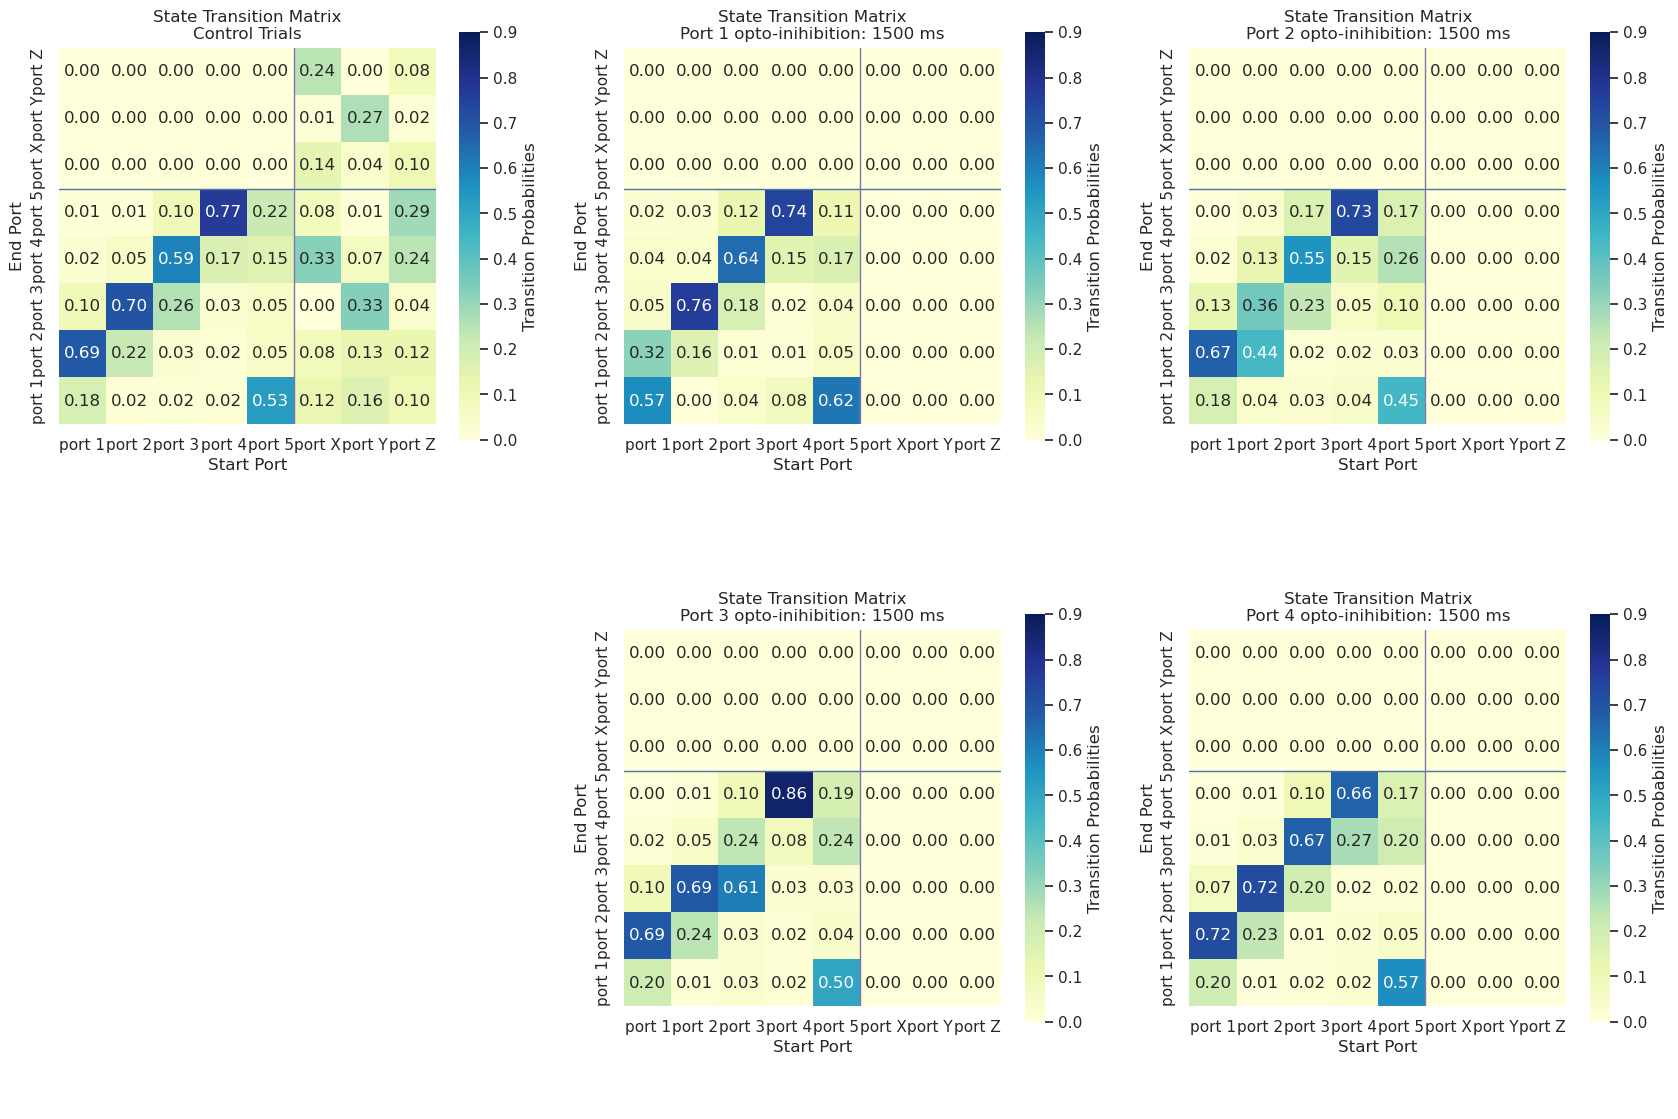

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_transition_matrix_from_filtered_df(correct_trials_controls, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Control Trials', ax=axs[0, 0])
plot_transition_matrix_from_filtered_df(correct_trials_opto_1, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 1 opto-inihibition: 1500 ms', ax=axs[0, 1])
plot_transition_matrix_from_filtered_df(correct_trials_opto_2, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 2 opto-inihibition: 1500 ms', ax=axs[0, 2])
plot_transition_matrix_from_filtered_df(correct_trials_opto_3, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 3 opto-inihibition: 1500 ms', ax=axs[1, 1])
plot_transition_matrix_from_filtered_df(correct_trials_opto_4, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 4 opto-inihibition: 1500 ms', ax=axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# Adjust spaces between subplots and around the plot
fig.tight_layout()
fig.subplots_adjust(left=0.1, wspace=0.2, hspace=0) # You can adjust this value as needed
plt.show()

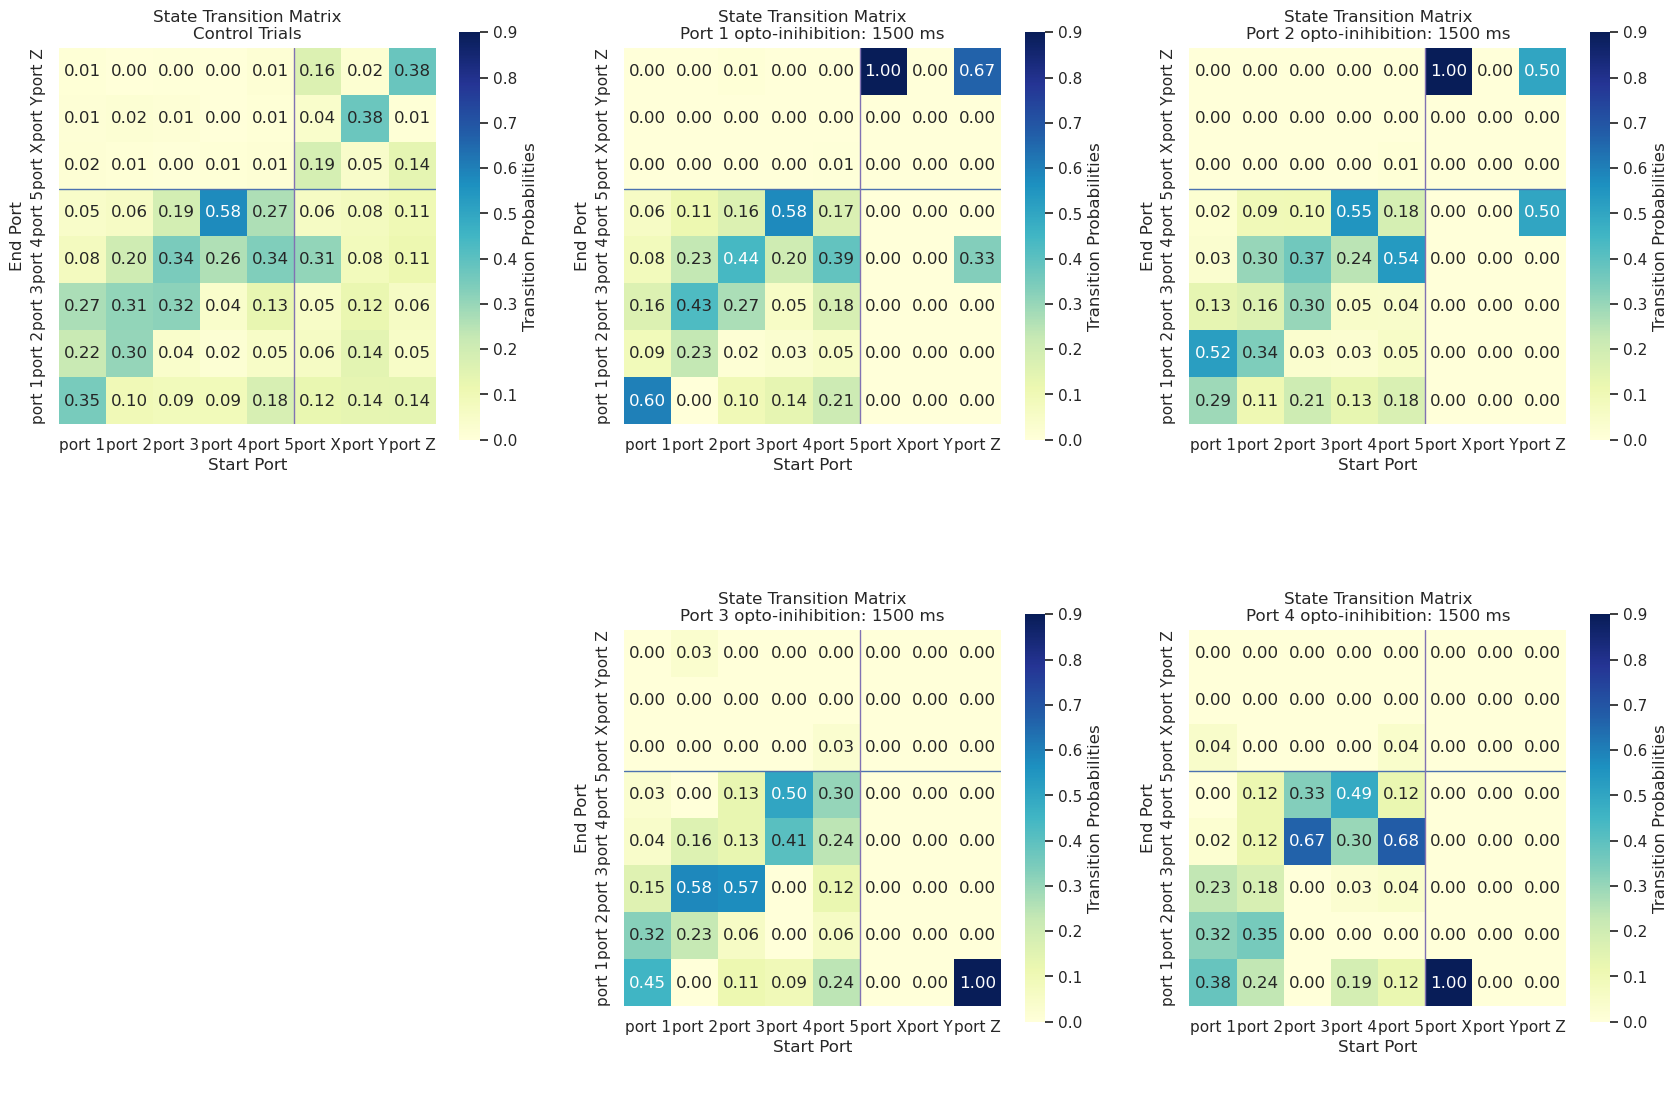

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_transition_matrix_from_filtered_df(incorrect_trials_controls, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Control Trials', ax=axs[0, 0])
plot_transition_matrix_from_filtered_df(incorrect_trials_opto_1, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 1 opto-inihibition: 1500 ms', ax=axs[0, 1])
plot_transition_matrix_from_filtered_df(incorrect_trials_opto_2, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 2 opto-inihibition: 1500 ms', ax=axs[0, 2])
plot_transition_matrix_from_filtered_df(incorrect_trials_opto_3, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 3 opto-inihibition: 1500 ms', ax=axs[1, 1])
plot_transition_matrix_from_filtered_df(incorrect_trials_opto_4, normalize=True, display_numbers=True, limit_start_ports=False, additional_title= 'Port 4 opto-inihibition: 1500 ms', ax=axs[1, 2])

# You can hide the unused subplot with this line
axs[1, 0].axis('off')

# Adjust spaces between subplots and around the plot
fig.tight_layout()
fig.subplots_adjust(left=0.1, wspace=0.2, hspace=0) # You can adjust this value as needed
plt.show()

### Plot entry to port summary

In [ ]:
# extract and accumulate all start_poke_port lists from filtered data 

def get_all_port_entries(df):
    all_start_poke_port = []

    for _, row in df.iterrows():
        all_start_poke_port.extend(row['start_poke_port'])
    # convert to numpy array
    all_start_poke_port = np.array(all_start_poke_port)
    return all_start_poke_port

all_start_poke_port_control = get_all_port_entries(filtered_control_df)
all_start_poke_port_opto_1 = get_all_port_entries(filtered_optostim_port_1)
all_start_poke_port_opto_2 = get_all_port_entries(filtered_optostim_port_2)
all_start_poke_port_opto_3 = get_all_port_entries(filtered_optostim_port_3)
all_start_poke_port_opto_4 = get_all_port_entries(filtered_optostim_port_4)

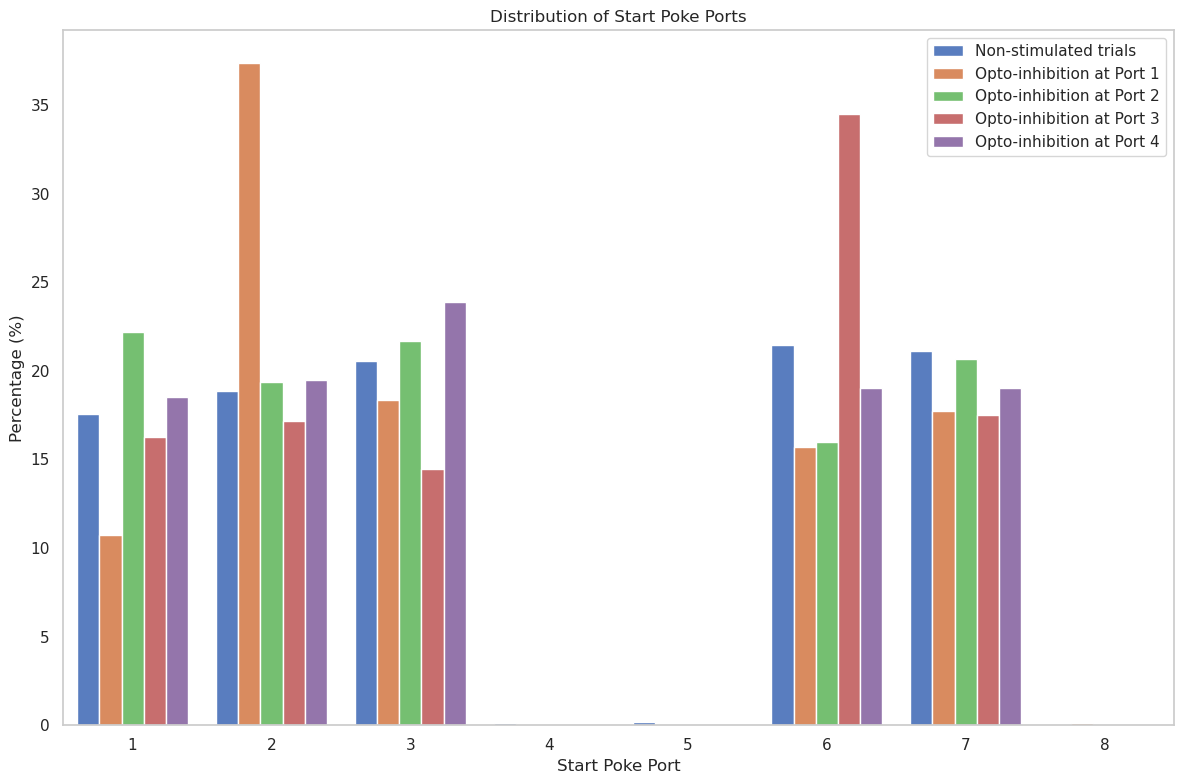

In [ ]:
# visualize the distribution of start_poke_port entries in 
# Data labels for the bar plot
dataframes_list_0 = [all_start_poke_port_control, all_start_poke_port_opto_1, all_start_poke_port_opto_2, all_start_poke_port_opto_3, all_start_poke_port_opto_4]

data_labels = ['Non-stimulated trials', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

# Combine all data into a single DataFrame for easier plotting
combined_data = pd.DataFrame()
for idx, data in enumerate(dataframes_list_0):
    temp_df = pd.DataFrame(data, columns=['Start Poke Port'])
    temp_df['Condition'] = data_labels[idx]
    combined_data = pd.concat([combined_data, temp_df])

# Convert 'Start Poke Port' to categorical type for correct ordering
combined_data['Start Poke Port'] = combined_data['Start Poke Port'].astype(str)

# Compute the count for each unique value of Start Poke Port within each Condition
grouped_counts = combined_data.groupby(['Start Poke Port', 'Condition']).size().reset_index(name='Count')

# Compute the total count for each Condition
total_counts = combined_data.groupby('Condition').size()

# Compute the percentage
grouped_counts['Percentage'] = grouped_counts.apply(lambda row: (row['Count'] / total_counts[row['Condition']]) * 100, axis=1)

# Create a categorical bar plot with percentages
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_counts, x='Start Poke Port', y='Percentage', hue='Condition', errorbar=None, palette="muted")

plt.title('Distribution of Start Poke Ports')
plt.ylabel('Percentage (%)')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# Filter the combined_data for only Non-stimulated trials
non_stimulated_data = combined_data[combined_data['Condition'] == 'Non-stimulated trials']

# Plot the counts for Start Poke Port for Non-stimulated trials
plt.figure(figsize=(10, 6))
sns.countplot(data=non_stimulated_data, x='Start Poke Port', order=sorted(non_stimulated_data['Start Poke Port'].unique()), palette="Set2")
plt.title('Distribution of Start Poke Ports for Non-stimulated trials')
plt.ylabel('Count')
plt.xlabel('Start Poke Port')
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
# List of DataFrames
dataframes_list_1 = [correct_trials_controls, correct_trials_opto_1, correct_trials_opto_2, correct_trials_opto_3, correct_trials_opto_4]

# Column name to analyze (e.g., 'start_poke_port')
column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Non-stimulated trials', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

# Plot for rILT opto-inhibition for only correct trials
plot_mean_length(dataframes_list_1, column_name, data_labels, title="rILT Opto-inhibition: Correct trials only", remove_consecutive_repeats_flag=False)


T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: -4.738544545474222
P-Value: 2.1858582007348266e-06
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: -5.648459021790165
P-Value: 1.668400316654435e-08
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: -7.176389721531284
P-Value: 7.724421121230498e-13
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 0.8384029622440592
P-Value: 0.40182668711257075
Result: No significant difference



In [ ]:
# List of DataFrames
dataframes_list = [correct_trials_controls, correct_trials_opto_1, correct_trials_opto_2, correct_trials_opto_3, correct_trials_opto_4]

# Column name to analyze (e.g., 'start_poke_port')
column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']


# Plot for rILT opto-inhibition for only correct trials no repeats
plot_mean_length(dataframes_list, column_name, data_labels, title="rILT Opto-inhibition: Correct trials only repetitions removed", remove_consecutive_repeats_flag=True)

T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: -1.2793470170077987
P-Value: 0.20080814852979362
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: -5.359320176002585
P-Value: 8.561260698125145e-08
Result: Significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: -1.314313214247653
P-Value: 0.18877430907971327
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 1.2472482384130097
P-Value: 0.2123389376207633
Result: No significant difference



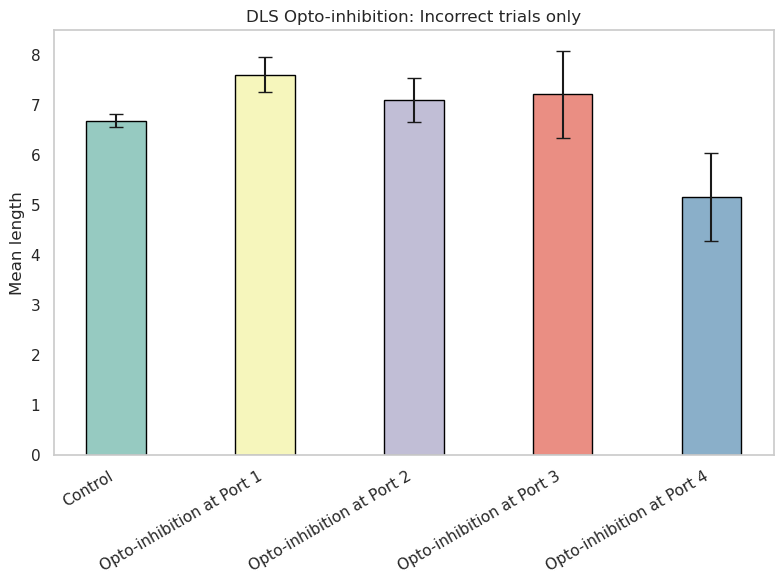

T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: -1.8572016645086802
P-Value: 0.06346902326166386
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: -0.7363933023131797
P-Value: 0.4616028118431905
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: -0.5902305003206688
P-Value: 0.5551252686011039
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 1.538713044194956
P-Value: 0.12408669052660132
Result: No significant difference



In [ ]:
# List of DataFrames
dataframes_list = [incorrect_trials_controls, incorrect_trials_opto_1, incorrect_trials_opto_2, incorrect_trials_opto_3, incorrect_trials_opto_4]

# Column name to analyze (e.g., 'start_poke_port')
column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

# Plot for rILT opto-inhibition for only incorrect trials
plot_mean_length(dataframes_list, column_name, data_labels, title="rILT Opto-inhibition: Incorrect trials only", remove_consecutive_repeats_flag=False)

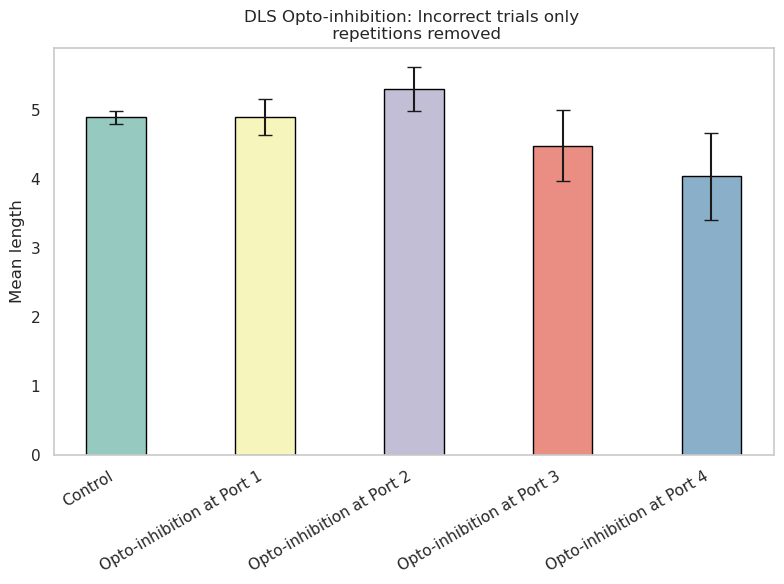

T-Test: Control vs Opto-inhibition at Port 1
T-Statistic: 0.0018786610976226888
P-Value: 0.9985012841077889
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 2
T-Statistic: -1.021467857893026
P-Value: 0.30719222828846665
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 3
T-Statistic: 0.6421244292544015
P-Value: 0.520890777256522
Result: No significant difference

T-Test: Control vs Opto-inhibition at Port 4
T-Statistic: 1.2171936275191786
P-Value: 0.22372329920877332
Result: No significant difference



In [ ]:
# List of DataFrames
dataframes_list = [incorrect_trials_controls, incorrect_trials_opto_1, incorrect_trials_opto_2, incorrect_trials_opto_3, incorrect_trials_opto_4]

# Column name to analyze (e.g., 'start_poke_port')
column_name = 'start_poke_port'

# Data labels for the bar plot
data_labels = ['Control', 'Opto-inhibition at Port 1', 'Opto-inhibition at Port 2', 'Opto-inhibition at Port 3', 'Opto-inhibition at Port 4']

# Plot for rILT opto-inhibition for only incorrect trials no repeats
plot_mean_length(dataframes_list, column_name, data_labels, title="rILT Opto-inhibition: Incorrect trials only \n repetitions removed", remove_consecutive_repeats_flag=True)